In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
import nltk
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings('ignore')
import unicodedata

In [359]:
data = pd.read_csv(f'C:\\Users\\juanp\\OneDrive\\Desktop\\CURSO TURING\\propiedades_limpias.csv', sep=',', encoding='utf-8-sig')
print(data.shape)

(474, 10)


Anteriormente hicimos un proceso de Machine Learning para intentar clasificar de manera correcta las ciudades pero ahora llegamos a la parte de otro modelamiento por lo que tenemos que preguntarnos, que queremos modelar <br>
Ya que ya se hizo uno de clasificacion propongo uno de prediccion 

In [360]:
data.head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
0,3300000000,"envigado, loma del escobero, las palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...,Casa campestre en venta,loma escobero,medellin
1,350000000,"cn solares de la morada et vii y viii, br send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam...",Casa en venta,hacienda castillo,cali
2,1200000000,"la calera, la plazuela, alto de la virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,centro,bogota
3,194000000,"loma del atravesado, las palmas, la mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,vereda planta,medellin
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,NaN,Casa en venta,niza,bogota


In [361]:
data['georeferencia'].value_counts()

georeferencia
san antonio prado                     19
poblado                               12
rionegro                              12
centro                                11
laureles                              11
                                      ..
tintal                                 1
villa adriana                          1
punto mayor                            1
barrio mesa                            1
parque industrial portos sabana 80     1
Name: count, Length: 318, dtype: int64

Georeferencia tiene 318 valores unicos con pocas repeticiones por valor, incluso despues de estar normalizado lo cual podria generar ruido en el modelamiento pero esto se analiza posteriormente 

In [362]:
num_cols = ['habitaciones', 'baños', 'parqueaderos', 'area']
cat_cols = ['ciudad_final', 'tipo_propiedad', 'descripcion', "ubicacion", 'georeferencia']
target = 'precio'
#data = data.drop(columns=['georeferencia'])

In [363]:
data[num_cols] = data[num_cols].replace('No encontrado', np.nan)
data[cat_cols] = data[cat_cols].replace('No encontrado', np.nan)
# 3) Convertir a tipo numérico
data[num_cols] = data[num_cols].astype(float)

In [364]:
# Buscando valores vacios
data.isnull().sum()

precio             0
ubicacion          0
habitaciones       8
baños             24
parqueaderos      95
area               8
descripcion       27
tipo_propiedad     0
georeferencia      0
ciudad_final       0
dtype: int64

coerce para tratar con los errores <br>
Non-numeric strings:

Examples: "abc", "unknown", "N/A", "No encontrado", "--".
These cannot be interpreted as numbers.
Mixed data types:

Examples: "123abc", "45.67%", "1,000".
These contain numeric characters but also include non-numeric characters, making them invalid.
Empty strings:

Example: "".
An empty string is not a valid numeric value.
Whitespace-only strings:

Example: "   ".
Strings with only spaces or tabs are invalid.
Special characters:

Examples: "@", "#", "!".
These are not numeric values.
Malformed numbers:

Examples: "1.2.3", "123,456.78.90".
These do not follow a valid numeric format.
Non-standard numeric formats:

Examples: "1,000" (if commas are not handled), "1e3" (scientific notation, if not expected).

In [365]:
def limpiar_columna_numerica(df, columna):
    """Limpia y convierte una columna a numérica."""
    df[columna] = pd.to_numeric(df[columna], errors='coerce')  # 'coerce' convierte no válidos a NaN
    return df

for col in num_cols:
    limpiar_columna_numerica(data, col)

# Viendo que valores quedaron como nulos
data.isnull().sum()

precio             0
ubicacion          0
habitaciones       8
baños             24
parqueaderos      95
area               8
descripcion       27
tipo_propiedad     0
georeferencia      0
ciudad_final       0
dtype: int64



Por que se esta haciendo esto? <br>
Primero que todo se va a tokenizar la columna posteriormente y este no puede tener valores faltantes, <br>
despues, se va a eliminar las filas que tengan mas de X valores faltantes, en este caso 3, ya que no se puede hacer nada con esas filas <br>
Y realmente no hay manera de saber tratar datos de este tipo de lenguaje natural de alguna manera entonces es mejor llenarlos con algo para que por ahora al procesamiento que se esta haciendo no presente problemas


In [366]:
# A pesar de no poder hacer nada con la descripcion, no se va a eliminar dado que eliminarlo quitaria mas datos de la base de datos con otras columnas que si se pueden usar
data['descripcion'] = data['descripcion'].fillna("")

# Analisis datos faltantes

In [367]:
data[~data['area'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
data[~data['habitaciones'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
data[~data['baños'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
data[~data['parqueaderos'].apply(lambda x: str(x).replace('.', '', 1).isdigit())].head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
3,194000000,"loma del atravesado, las palmas, la mesa",3.0,1.0,NaN,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,vereda planta,medellin
5,170000000,"boston, buenos aires, miraflores",3.0,2.0,NaN,75.0,casa con 2 pisos independientes con espacios g...,Casa en venta,trece noviembre,medellin
21,4500000000,"finca a la venta, sector don diego palomino, c...",NaN,NaN,NaN,NaN,,Finca en venta,bonda sector macinga,desconocida
72,1350000,"la ferreria, san antonio de prado, prado",3.0,2.0,NaN,44.0,,Apartamento en arriendo,san antonio prado,medellin
78,1150000,"san antonio de prado, prado, la ferreria",3.0,1.0,NaN,45.0,Apartamento para arriendo en el sector de San ...,Apartamento en arriendo,san antonio prado,medellin


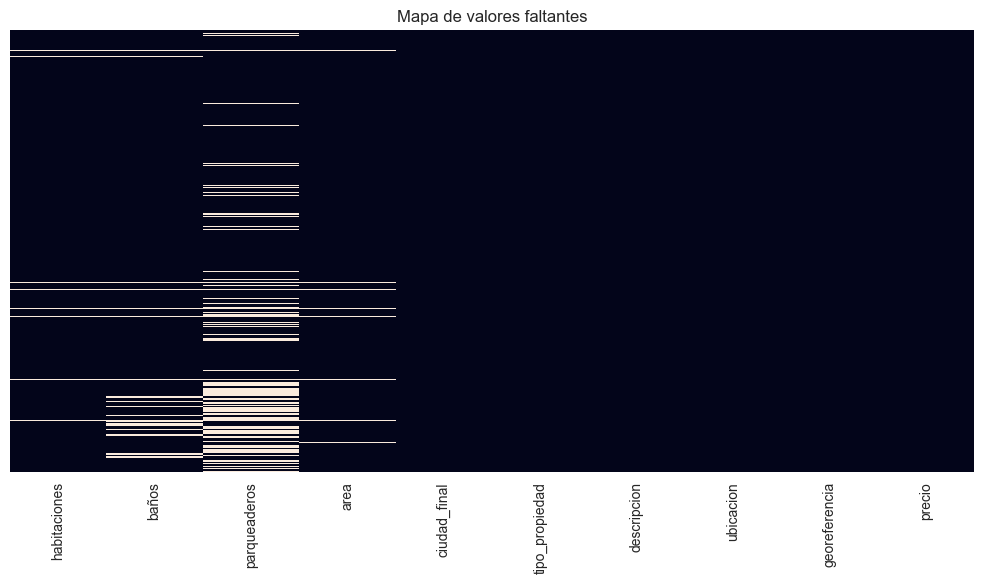

In [368]:
# Visualizar datos faltantes
plt.figure(figsize=(10, 6))
sns.heatmap(data[num_cols + cat_cols + [target]].isnull(), cbar=False, yticklabels=False)
plt.title('Mapa de valores faltantes')
plt.tight_layout()

Recordemos que descripcion se lleno con un "" (un caracter vacio) ya que no hacerlo iba a impedir que se pudiera tokenizar y esto pasa con multiples modelos donde directamente no podemos modelar si hay presencia de datos faltantes <br>
Los datos faltantes tambien podrian influir en un sesgo o generar ruido si no hay una distribucion aleatoria en estos datos en nuestro caso se ve que parqueaderos es la que mayor tiene datos faltantes asi que seguramente esta variable entre con mucho ruido si no se hace un tratamiento a estos datos <br>
Algunos modelos omiten todo un dato si al menos una de las variables esta vacia por lo que tambien se perderia informacion <br>

In [369]:
# Data frame completo mostrando todas las columnas pero donde hay valores faltantes
data[data.isnull().any(axis=1)]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
3,194000000,"loma del atravesado, las palmas, la mesa",3.0,1.0,NaN,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,vereda planta,medellin
5,170000000,"boston, buenos aires, miraflores",3.0,2.0,NaN,75.0,casa con 2 pisos independientes con espacios g...,Casa en venta,trece noviembre,medellin
21,4500000000,"finca a la venta, sector don diego palomino, c...",NaN,NaN,NaN,NaN,,Finca en venta,bonda sector macinga,desconocida
27,2400000,"ditaires, santa catalina, la ferreria",NaN,NaN,0.0,29.0,"Posiciona tu negocio en este local de 28,60 m,...",Local Comercial en arriendo o venta,san andres,medellin
72,1350000,"la ferreria, san antonio de prado, prado",3.0,2.0,NaN,44.0,,Apartamento en arriendo,san antonio prado,medellin
...,...,...,...,...,...,...,...,...,...,...
462,15000000,"nicolas de federman, la porciuncula, polo club",5.0,0.0,NaN,615.0,"Oportunidad única en el barrio de San Miguel, ...",Bodega en arriendo,siete agosto,bogota
464,14000000,"laureles, rosales, las acacias",5.0,0.0,NaN,720.0,"Bodega ubicada en un cuarto piso, está en un s...",Bodega en arriendo,laureles,desconocida
467,16500000,"castropol, simesa, san diego",5.0,0.0,NaN,460.0,Arriendo Bodega en Barrio Colombia. Primer pis...,Bodega en arriendo,barrio colombia,bogota
469,15000000,"el tintal a.s.d., predio caldas, morabia",5.0,0.0,NaN,432.0,"Arriendo magnifica bodega comercial de 432 m²,...",Bodega en arriendo,fontibon,bogota


In [370]:
data[data.isnull().sum(axis=1) > 3] # cuantas filas tienen mas de 3 valores nulos

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
21,4500000000,"finca a la venta, sector don diego palomino, c...",NaN,NaN,NaN,NaN,,Finca en venta,bonda sector macinga,desconocida
270,10000000011,te presentamos esta finca ubicado en la direcc...,NaN,NaN,NaN,NaN,,Finca en venta,santuario,desconocida
277,488488000,te presentamos confortable casa ubicada en sec...,NaN,NaN,NaN,NaN,,Casa en venta,pontevedra,desconocida
298,669000002115975,te presentamos esta confortable casa ubicada e...,NaN,NaN,NaN,NaN,,Casa en venta,san cayetano,desconocida
306,208200000321879,te presentamos confortable apartamento ubicado...,NaN,NaN,NaN,NaN,,Apartamento en venta,tena,bogota
374,1500000000,te presentamos esta confortable casa campestre...,NaN,NaN,NaN,NaN,,Casa campestre en venta,otros,medellin
418,3750000034121000,bodega industrial en dorado area de 1.950 metr...,NaN,NaN,NaN,NaN,,Bodega en arriendo,dorado,medellin


Entre mas datos faltantes tenga un dato menos util es y la posibilidad de que sea un dato erroneo aumentan

In [371]:
# Busquemos datos que digan lote en la descripcion o en el tipo de propiedad
data[(data['descripcion'].str.contains('lote', case=False, na=False) | data['tipo_propiedad'].str.contains('lote', case=False, na=False)) & data.isnull().any(axis=1)]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
422,9900000,"santa barbara occidental, los cedritos, el con...",3.0,NaN,0.0,300.0,"Bodega construida con licencia, trifasica , mu...",Bodega en arriendo,prado veraniego norte,bogota
425,3200000,"santa monica, granada, prados del norte",3.0,0.0,NaN,302.0,"SE ALQUILA BODEGA EN EL BARRIO SAN NICOLÁS, US...",Bodega en arriendo,san nicolas,desconocida


In [372]:
# Veamos mas datos en donde habitaciones, baños y parqueaderos son nulos
data[(data['habitaciones'].isnull() | data['baños'].isnull() | data['parqueaderos'].isnull()) & data.isnull().any(axis=1)] #112 filas, mucho

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
3,194000000,"loma del atravesado, las palmas, la mesa",3.0,1.0,NaN,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,vereda planta,medellin
5,170000000,"boston, buenos aires, miraflores",3.0,2.0,NaN,75.0,casa con 2 pisos independientes con espacios g...,Casa en venta,trece noviembre,medellin
21,4500000000,"finca a la venta, sector don diego palomino, c...",NaN,NaN,NaN,NaN,,Finca en venta,bonda sector macinga,desconocida
27,2400000,"ditaires, santa catalina, la ferreria",NaN,NaN,0.0,29.0,"Posiciona tu negocio en este local de 28,60 m,...",Local Comercial en arriendo o venta,san andres,medellin
72,1350000,"la ferreria, san antonio de prado, prado",3.0,2.0,NaN,44.0,,Apartamento en arriendo,san antonio prado,medellin
...,...,...,...,...,...,...,...,...,...,...
462,15000000,"nicolas de federman, la porciuncula, polo club",5.0,0.0,NaN,615.0,"Oportunidad única en el barrio de San Miguel, ...",Bodega en arriendo,siete agosto,bogota
464,14000000,"laureles, rosales, las acacias",5.0,0.0,NaN,720.0,"Bodega ubicada en un cuarto piso, está en un s...",Bodega en arriendo,laureles,desconocida
467,16500000,"castropol, simesa, san diego",5.0,0.0,NaN,460.0,Arriendo Bodega en Barrio Colombia. Primer pis...,Bodega en arriendo,barrio colombia,bogota
469,15000000,"el tintal a.s.d., predio caldas, morabia",5.0,0.0,NaN,432.0,"Arriendo magnifica bodega comercial de 432 m²,...",Bodega en arriendo,fontibon,bogota


Filtrando por los datos que tienen datos faltantes buscamos la palabra "parquea" dentro de las columnas de descripcion y ubicacion

In [373]:
data[
    (data['descripcion'].str.contains('parquea', case=False, na=False) | 
     data['ubicacion'].str.contains('parquea', case=False, na=False)) & 
    data['parqueaderos'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
210,3000000,"santa rosa de lima, los colores, estadio",6.0,3.0,NaN,180.0,Espectacular Casa está disponible para Arriend...,Casa en arriendo,manrique,medellin
445,50875000,"simon bolivar sb (centro), guasimalito, la azu...",4.0,0.0,NaN,2034.0,"Bodega en arriendo en Bello, parque empresaria...",Bodega en arriendo,villas copacabana,medellin
451,9000000,"alejandria, patio bonito, santa maria de los a...",4.0,3.0,NaN,280.0,"Bodega en arriendo cerca a estacion de metro, ...",Bodega en arriendo,guayabal,desconocida
461,27900000,"la candelaria, medellin, villanueva",5.0,2.0,NaN,500.0,"La bodega en El Chagualo, con 500 m2, es una e...",Bodega en arriendo,chagualo,medellin


In [374]:
data[
    (data['descripcion'].str.contains(r'\b(parquea|parqueadero|parqueo|estacionamiento|aparca|aparcamiento|parking|garaje)\b', case=False, na=False)| 
     data['ubicacion'].str.contains(r'\b(parquea|parqueadero|parqueo|estacionamiento|aparca|aparcamiento|parking|garaje)\b', case=False, na=False)) & 
    data['parqueaderos'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
287,65000000,"santa teresita, bellavista, normandia",2.0,2.0,NaN,59.75,Te presentamos esta confortable casa ubicada e...,Casa en venta,san cayetano,desconocida
292,190000000,"centro, fusagasuga, paseo real",2.0,2.0,NaN,50.93,Te presentamos esta confortable apartamento ub...,Apartamento en venta,cr san martin olivos,desconocida
298,669000002115975,te presentamos esta confortable casa ubicada e...,NaN,NaN,NaN,NaN,,Casa en venta,san cayetano,desconocida
304,366000000,"cajica , el misterio, vda canelon",3.0,2.0,NaN,99.00,Te presentamos confortable casa ubicada en el ...,Casa en venta,centro,medellin
306,208200000321879,te presentamos confortable apartamento ubicado...,NaN,NaN,NaN,NaN,,Apartamento en venta,tena,bogota
313,256000000,"obrero, los angeles, mayales i",3.0,2.0,NaN,74.77,Te presentamos confortable apartamento ubicado...,Apartamento en venta,villa alicia,desconocida
317,92500000,"mt cerro campestre alto, vereda samaria",3.0,1.0,NaN,75.00,Te presentamos confortable casa ubicada en el ...,Casa en venta,antioquia,medellin
364,303000000,"ingles, la providencia, olaya",6.0,4.0,NaN,217.94,Te presentamos confortable casa ubicada en el ...,Casa en venta,granjas san pablo,desconocida
379,2400000,"la candelaria, medellin, boston",1.0,0.0,NaN,74.00,"Bodega disponible para arrendar en el Centro, ...",Bodega en arriendo,candelaria,medellin
408,7500000,"entre amigos, centro, el dorado",2.0,0.0,NaN,300.00,¡Gran oportunidad! Moderna bodega industrial e...,Bodega en arriendo,prados sabaneta,medellin


In [375]:
data[
    (data['descripcion'].str.contains('baño', case=False, na=False) | 
     data['ubicacion'].str.contains('baño', case=False, na=False)) & 
    data['baños'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
422,9900000,"santa barbara occidental, los cedritos, el con...",3.0,NaN,0.0,300.0,"Bodega construida con licencia, trifasica , mu...",Bodega en arriendo,prado veraniego norte,bogota


In [376]:
data[
    (data['descripcion'].str.contains(r'\b(baño|sanitario|bañera|bano)\b', case=False, na=False) | 
     data['ubicacion'].str.contains(r'\b(baño|sanitario|bañera|bano)\b', case=False, na=False)) & 
    data['baños'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
277,488488000,te presentamos confortable casa ubicada en sec...,NaN,NaN,NaN,NaN,,Casa en venta,pontevedra,desconocida
298,669000002115975,te presentamos esta confortable casa ubicada e...,NaN,NaN,NaN,NaN,,Casa en venta,san cayetano,desconocida
393,2000000,"el tintal a.s.d., predio caldas, morabia",1.0,NaN,0.0,80.0,Espectacular bodega ubicada en el sector de fo...,Bodega en arriendo,fontibon centro,bogota
422,9900000,"santa barbara occidental, los cedritos, el con...",3.0,NaN,0.0,300.0,"Bodega construida con licencia, trifasica , mu...",Bodega en arriendo,prado veraniego norte,bogota


In [377]:
data[
    (data['descripcion'].str.contains(r'\b(habita|habitaciones|alcobas|alcoba|habitacion)\b', case=False, na=False)| 
     data['ubicacion'].str.contains(r'\b(habita|habitaciones|alcobas|alcoba|habitacion)\b', case=False, na=False)) & 
    data['habitaciones'].isnull()
]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
298,669000002115975,te presentamos esta confortable casa ubicada e...,NaN,NaN,NaN,NaN,,Casa en venta,san cayetano,desconocida
306,208200000321879,te presentamos confortable apartamento ubicado...,NaN,NaN,NaN,NaN,,Apartamento en venta,tena,bogota


In [378]:
data[
    (data['descripcion'].str.contains(r'\b(metro|metros|area|tamaño)\b', case=False, na=False) | 
     data['ubicacion'].str.contains(r'\b(metro|metros|area|tamaño)\b', case=False, na=False)) & 
    data['area'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
270,10000000011,te presentamos esta finca ubicado en la direcc...,NaN,NaN,NaN,NaN,,Finca en venta,santuario,desconocida
277,488488000,te presentamos confortable casa ubicada en sec...,NaN,NaN,NaN,NaN,,Casa en venta,pontevedra,desconocida
374,1500000000,te presentamos esta confortable casa campestre...,NaN,NaN,NaN,NaN,,Casa campestre en venta,otros,medellin
418,3750000034121000,bodega industrial en dorado area de 1.950 metr...,NaN,NaN,NaN,NaN,,Bodega en arriendo,dorado,medellin
441,8000000,"alejandria, patio bonito, la aguacatala",4.0,2.0,1.0,NaN,CODIGO DEL INMUEBLE: 447-10308 BODEGA-ARRIENDO...,Bodega en arriendo,cristo rey,desconocida


Esta es una primera version de la función que va a encontrar la información faltante, solo usa keywords para encontrarlas pero como notaron anteriormente usar expresiones regulares suele encontrar mejores resultados

In [379]:
import re
import pandas as pd
# primera version, solo usando palabras clave
def extract_missing_info(df):
    """
    Extract missing information from description and location fields.
    
    Args:
        df (pandas.DataFrame): The dataframe with missing values
        
    Returns:
        pandas.DataFrame: The dataframe with imputed values
    """
    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Function to extract numbers from text
    def extract_numbers(text):
        if not isinstance(text, str):
            return []
        # Find all numbers (including decimals)
        return re.findall(r'\b\d+(?:\.\d+)?\b', text)
    
    # Function to extract number preceding or following specific keywords
    def extract_number_near_keyword(text, keywords, default=1):
        if not isinstance(text, str):
            return None
        
        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()
        
        # Look for patterns like "X keyword" or "keyword X"
        for keyword in keywords:
            # Pattern for "X keyword" (e.g., "2 habitaciones")
            pattern1 = r'(\d+)\s+' + re.escape(keyword)
            match1 = re.search(pattern1, text_lower)
            if match1:
                return float(match1.group(1))
            
            # Pattern for "keyword X" (e.g., "habitaciones 2")
            pattern2 = re.escape(keyword) + r'\s+(\d+)'
            match2 = re.search(pattern2, text_lower)
            if match2:
                return float(match2.group(1))
            
            # Check if keyword exists without a number
            if keyword in text_lower:
                return default
        
        return None
    
    # 1. Extract habitaciones (rooms)
    habitacion_keywords = ['habitacion', 'habitaciones', 'alcoba', 'alcobas', 'cuarto', 'cuartos', 'dormitorio', 'dormitorios']
    
    # Apply to rows where habitaciones is null
    for idx in df_copy[df_copy['habitaciones'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Try to extract room count
        room_count = extract_number_near_keyword(combined_text, habitacion_keywords)
        if room_count is not None:
            df_copy.loc[idx, 'habitaciones'] = room_count
    #r'\b(baño|sanitario|bañera|bano)\b'
    # 2. Extract baños (bathrooms)
    bano_keywords = ['baño', 'baños', 'sanitario', 'sanitarios', 'wc', 'bano','bañera', 'bañeras']
    
    # Apply to rows where baños is null
    for idx in df_copy[df_copy['baños'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Try to extract bathroom count
        bathroom_count = extract_number_near_keyword(combined_text, bano_keywords)
        if bathroom_count is not None:
            df_copy.loc[idx, 'baños'] = bathroom_count
    #r'\b(parquea|parqueadero|parqueo|estacionamiento|aparca|aparcamiento|parking|garaje)\b'
    # 3. Extract parqueaderos (parking spaces)
    parking_keywords = ['parqueadero', 'parqueaderos', 'estacionamiento', 'estacionamientos', 
                        'garaje', 'garajes', 'parking', 'cochera', 'cocheras', 'aparca', 'aparcamientos']
    
    # Apply to rows where parqueaderos is null
    for idx in df_copy[df_copy['parqueaderos'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Try to extract parking count
        parking_count = extract_number_near_keyword(combined_text, parking_keywords)
        if parking_count is not None:
            df_copy.loc[idx, 'parqueaderos'] = parking_count
    
    # 4. Extract area
    area_keywords = ['metro', 'metros', 'area', 'área', 'tamaño', 'm2', 'mts', 'mt2']
    
    # Apply to rows where area is null
    for idx in df_copy[df_copy['area'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Looking for area patterns is more complex - try to extract numbers near area keywords
        for keyword in area_keywords:
            # Pattern for "X keyword" (e.g., "250 metros")
            pattern = r'(\d+(?:\.\d+)?)\s*' + re.escape(keyword)
            match = re.search(pattern, combined_text.lower())
            if match:
                df_copy.loc[idx, 'area'] = float(match.group(1))
                break
        
        # If area is still null but a keyword is found, set default area
        if pd.isna(df_copy.loc[idx, 'area']):
            for keyword in area_keywords:
                if keyword in combined_text.lower():
                    df_copy.loc[idx, 'area'] = 1  # Default area value
                    break

        if pd.isna(df_copy.loc[idx, 'habitaciones']):
            for keyboard in habitacion_keywords:
                if keyword in combined_text.lower():
                    df_copy.loc[idx, 'habitaciones'] = 1
                    break

        if pd.isna(df_copy.loc[idx, 'habitaciones']):
            for keyboard in habitacion_keywords:
                if keyword in combined_text.lower():
                    df_copy.loc[idx, 'habitaciones'] = 1
                    break
    
    # 5. Special case for Lotes (if not already handled)
    df_copy.loc[df_copy['tipo_propiedad'].str.contains('lote', case=False, na=False) & 
                df_copy[['habitaciones', 'baños', 'parqueaderos']].isnull().any(axis=1), 
                ['habitaciones', 'baños', 'parqueaderos']] = 0
    
    return df_copy

Podemos realizar una extraccion de esta informacion de manera individual o global

In [380]:
import re
import pandas as pd

def extract_missing_habitaciones(df):
    """
    Imputa la columna 'habitaciones' usando:
      1) extracción de número cerca de palabras clave de habitaciones,
      2) si sigue nulo y aparece una keyword de habitaciones → 1
      3) si sigue nulo y aparece una keyword de área → 1 
    """
    df_copy = df.copy()

    # 1) Keywords de habitaciones y área
    habit_keywords = [
        'habitacion','habitaciones','alcoba','alcobas',
        'cuarto','cuartos','dormitorio','dormitorios'
    ]

    # Helper para texto completo
    def full_text(row):
        desc = row.get('descripcion') or ""
        ubi  = row.get('ubicacion')  or ""
        return f"{desc} {ubi}".lower()

    # 2) Función que busca número antes o después de la keyword
    def extract_number_near_keyword(text, keywords, default=1):
        for kw in keywords:
            # patrón "X kw" Numero seguido de la palabra clave
            m = re.search(r'(\d+)\s+' + re.escape(kw), text)
            if m:
                return float(m.group(1))
            # patrón "kw X" # Palabra clave seguida de número
            m = re.search(re.escape(kw) + r'\s+(\d+)', text)
            if m:
                return float(m.group(1))
            # fallback si aparece la palabra
            if kw in text:
                return float(default)
        return None

    # 3) Primera pasada: extraer número o fallback=1 si hay keyword de habitaciones
    for idx in df_copy[df_copy['habitaciones'].isnull()].index:
        txt = full_text(df_copy.loc[idx]) # texto completo del index
        val = extract_number_near_keyword(txt, habit_keywords, default=1) # extraer número
        if val is not None:
            df_copy.at[idx, 'habitaciones'] = val # asignar valor


    return df_copy


In [381]:
import re
import pandas as pd

def extract_missing_info(df):
    """
    Extract missing information from description and location fields.
    
    Args:
        df (pandas.DataFrame): The dataframe with missing values
        
    Returns:
        pandas.DataFrame: The dataframe with imputed values
    """
    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Function to extract number preceding or following specific keywords
    def extract_number_near_keyword(text, keywords, default=1):
        if not isinstance(text, str):
            return None
        
        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()
        
        # Look for patterns like "X keyword" or "keyword X"
        for keyword in keywords:
            # Pattern for "X keyword" (e.g., "2 habitaciones")
            pattern1 = r'(\d+)\s+' + re.escape(keyword)
            match1 = re.search(pattern1, text_lower)
            if match1:
                return float(match1.group(1))
            
            # Pattern for "keyword X" (e.g., "habitaciones 2")
            pattern2 = re.escape(keyword) + r'\s+(\d+)'
            match2 = re.search(pattern2, text_lower)
            if match2:
                return float(match2.group(1))
            
            # Check if keyword exists without a number
            if keyword in text_lower:
                return default
        
        return None
    
    # Function to extract number preceding or following specific regex pattern
    def extract_number_near_pattern(text, pattern, default=1):
        if not isinstance(text, str):
            return None
        
        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()
        
        # Pattern for "X keyword" (e.g., "2 baños")
        pattern_before = r'(\d+(?:\.\d+)?)\s*(?:' + pattern + r')'
        match_before = re.search(pattern_before, text_lower)
        if match_before:
            return float(match_before.group(1))
        
        # Pattern for "keyword X" (e.g., "baños 2")
        pattern_after = r'(?:' + pattern + r')\s*(\d+(?:\.\d+)?)'
        match_after = re.search(pattern_after, text_lower)
        if match_after:
            return float(match_after.group(1))
        
        # Check if keyword exists without a number
        if re.search(pattern, text_lower):
            return default
        
        return None
    
    # Define keywords and patterns for each category
    # Using the original keywords for habitaciones
    habitacion_keywords = ['habitacion', 'habitaciones', 'alcoba', 'alcobas', 'cuarto', 'cuartos', 'dormitorio', 'dormitorios']
    
    # Extended habitacion keywords 
    extended_habitacion_keywords = ['recamara', 'recamaras', 'pieza', 'piezas', 'bedroom', 'bedrooms', 
                                   'hab', 'habs', 'alcoba', 'alcobas']
    
    # Improved pattern for baños 
    bano_pattern = r'ba(?:ñ|n)o(?:s)?|sanitario(?:s)?|wc|lavabo(?:s)?|toilet(?:s)?|aseo(?:s)?|ducha(?:s)?'
    
    # Original keywords for baños 
    bano_keywords = ['baño', 'baños', 'sanitario', 'sanitarios', 'wc', 'bano', 'bañera', 'bañeras']
    
    # Improved pattern for parqueaderos 
    parking_pattern = r'parque(?:adero)?(?:s)?|parqueo(?:s)?|estacionamiento(?:s)?|garaj(?:e(?:s)?)?|parking(?:s)?|cocher(?:a(?:s)?)?|aparca(?:miento)?(?:s)?|plaza(?:s)?\s*(?:de\s*)?(?:aparcamiento|garaje|parking)?'
    
    # Original keywords for parqueaderos 
    parking_keywords = ['parqueadero', 'parqueaderos', 'estacionamiento', 'estacionamientos', 
                        'garaje', 'garajes', 'parking', 'cochera', 'cocheras', 'aparca', 'aparcamientos']
    
    # Original keywords for area
    area_keywords = ['metro', 'metros', 'area', 'área', 'tamaño', 'm2', 'mts', 'mt2']
    

    # 1. Extract habitaciones (rooms) 
    for idx in df_copy[df_copy['habitaciones'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        room_count = extract_number_near_keyword(combined_text, habitacion_keywords)
        if room_count is not None:
            df_copy.loc[idx, 'habitaciones'] = room_count
            continue  # If found, move to next record
        
        
        if pd.isna(df_copy.loc[idx, 'habitaciones']):  # If still null
            room_count = extract_number_near_keyword(combined_text, extended_habitacion_keywords)
            if room_count is not None:
                df_copy.loc[idx, 'habitaciones'] = room_count
                continue  # If found, move to next record
        
       
        if pd.isna(df_copy.loc[idx, 'habitaciones']):  # If still null
            # Check for patterns like "1-room", "1 room", etc.
            room_patterns = [
                r'(\d+)\s*-?\s*(?:room|bedroom|hab|habitacion)',
                r'(?:de|con)\s+(\d+)\s+(?:habitacion|dormitorio|alcoba|cuarto)',
                r'(\d+)\s+(?:habitacion|dormitorio|alcoba|cuarto)'
            ]
            
            for pattern in room_patterns:
                match = re.search(pattern, combined_text.lower())
                if match:
                    df_copy.loc[idx, 'habitaciones'] = float(match.group(1))
                    break

        
                
        # Esto tambien puede funcionar pero usar como ultimo recurso ya que añade censura y es contextualizar la informacion, si es un estudio o apartaestudio suele tener una habitacion
        """if pd.isna(df_copy.loc[idx, 'habitaciones']):  # If still null
            property_type = str(df_copy.loc[idx, 'tipo_propiedad']).lower() if not pd.isna(df_copy.loc[idx, 'tipo_propiedad']) else ""
            if "apartaestudio" in property_type or "estudio" in property_type:
                df_copy.loc[idx, 'habitaciones'] = 1  """
        # O los lotes suelen tener 0 habitaciones, 0 baños y 0 parqueaderos, pero no conocemos si se aplica en nuestros datos


    
    # 2. Extract baños (bathrooms) 
    for idx in df_copy[df_copy['baños'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # First try the original method 
        bathroom_count = extract_number_near_keyword(combined_text, bano_keywords)
        if bathroom_count is not None:
            df_copy.loc[idx, 'baños'] = bathroom_count
            continue  # If found, move to next record
        
        # Then try the pattern method
        if pd.isna(df_copy.loc[idx, 'baños']):  # If still null
            bathroom_count = extract_number_near_pattern(combined_text, bano_pattern)
            if bathroom_count is not None:
                df_copy.loc[idx, 'baños'] = bathroom_count
                continue
        
        # Special case for bathrooms
        if pd.isna(df_copy.loc[idx, 'baños']):  # If still null
            if "un baño" in combined_text.lower() or "un bano" in combined_text.lower():
                df_copy.loc[idx, 'baños'] = 1
    
    # 3. Extract parqueaderos (parking spaces) 
    for idx in df_copy[df_copy['parqueaderos'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # First try the pattern method 
        parking_count = extract_number_near_pattern(combined_text, parking_pattern)
        if parking_count is not None:
            df_copy.loc[idx, 'parqueaderos'] = parking_count
            continue
        

        if pd.isna(df_copy.loc[idx, 'parqueaderos']):  # If still null
            parking_count = extract_number_near_keyword(combined_text, parking_keywords)
            if parking_count is not None:
                df_copy.loc[idx, 'parqueaderos'] = parking_count
                continue
        
        # Special case for parking: if keywords or pattern exist without number, assume 1
        if pd.isna(df_copy.loc[idx, 'parqueaderos']):
         # Revisar si alguna palabra clave está presente
            if any(kw in combined_text.lower() for kw in parking_keywords):
                df_copy.loc[idx, 'parqueaderos'] = 1
                continue

            # Revisar si el patrón regex está presente
            if re.search(parking_pattern, combined_text.lower()):
                df_copy.loc[idx, 'parqueaderos'] = 1

        # 4. Extract area
    for idx in df_copy[df_copy['area'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Looking for area patterns is more complex - try to extract numbers near area keywords
        for keyword in area_keywords:
            # Pattern for "X keyword" (e.g., "250 metros")
            pattern = r'(\d+(?:\.\d+)?)\s*' + re.escape(keyword)
            match = re.search(pattern, combined_text.lower())
            if match:
                df_copy.loc[idx, 'area'] = float(match.group(1))
                break
            
            # Additional pattern for "keyword: X" (e.g., "area: 250")
            pattern2 = re.escape(keyword) + r':\s*(\d+(?:\.\d+)?)'
            match2 = re.search(pattern2, combined_text.lower())
            if match2:
                df_copy.loc[idx, 'area'] = float(match2.group(1))
                break


    return df_copy

In [382]:
"""
data_imputed_habitaciones = extract_missing_habitaciones(data)
# Check how many values were imputed
for col in ['habitaciones', 'baños', 'parqueaderos', 'area']:
    original_nulls = data[col].isnull().sum()
    new_nulls = data_imputed_habitaciones[col].isnull().sum()
    print(f"{col}: {original_nulls - new_nulls} values imputed ({original_nulls} → {new_nulls} missing)")"""

'\ndata_imputed_habitaciones = extract_missing_habitaciones(data)\n# Check how many values were imputed\nfor col in [\'habitaciones\', \'baños\', \'parqueaderos\', \'area\']:\n    original_nulls = data[col].isnull().sum()\n    new_nulls = data_imputed_habitaciones[col].isnull().sum()\n    print(f"{col}: {original_nulls - new_nulls} values imputed ({original_nulls} → {new_nulls} missing)")'

In [383]:
data_imputed = extract_missing_info(data)
# Check how many values were imputed
for col in ['habitaciones', 'baños', 'parqueaderos', 'area']:
    original_nulls = data[col].isnull().sum()
    new_nulls = data_imputed[col].isnull().sum()
    print(f"{col}: {original_nulls - new_nulls} values imputed ({original_nulls} → {new_nulls} missing)")

habitaciones: 2 values imputed (8 → 6 missing)
baños: 6 values imputed (24 → 18 missing)
parqueaderos: 35 values imputed (95 → 60 missing)
area: 5 values imputed (8 → 3 missing)


precio             0.000000
ubicacion          0.000000
habitaciones       1.265823
baños              3.797468
parqueaderos      12.658228
area               0.632911
descripcion        0.000000
tipo_propiedad     0.000000
georeferencia      0.000000
ciudad_final       0.000000
dtype: float64

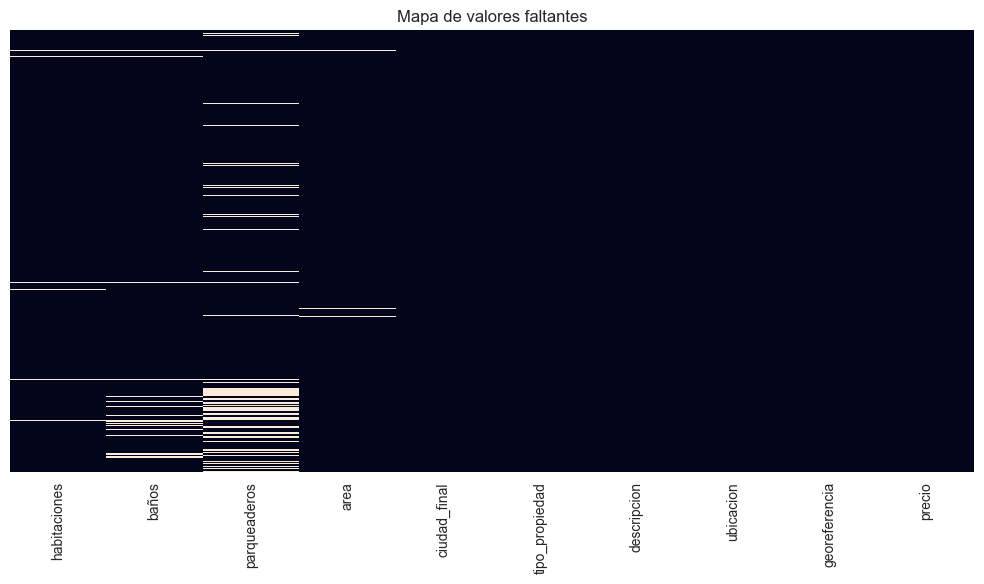

In [384]:
plt.figure(figsize=(10, 6))
sns.heatmap(data_imputed[num_cols + cat_cols + [target]].isnull(), cbar=False, yticklabels=False)
plt.title('Mapa de valores faltantes')
plt.tight_layout()

# porcentaje 
data_imputed.isnull().sum() / len(data_imputed) * 100

Aunque se hizo una imputacion segura siguen habiendo bastantes desconocidos, por la cantidad de datos que tenemos eliminarlos es una accion que evitamos, vamos a proceder a realizar una imputacion de estos datos faltantes sin embargo hacer esto si se hace en la vida real tiene que ser documentado 

KNN imputer o *IterativeImputer* de Scikit-learn para imputer valores faltantes en columnas numericas pero hay que tener cuidado al hacer esto debido a que la imputacion no tiene en cuenta el contexto de las columnas por lo que nosostros somos responsables de pulirlo

In [385]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='uniform') # Aqui se construye el modelo que va a imputar 
data_imputed_knn = data_imputed.copy()
data_imputed_knn[num_cols] = imputer.fit_transform(data_imputed_knn[num_cols])


# Check how many values were imputed
for col in num_cols:
    original_nulls = data_imputed[col].isnull().sum()
    new_nulls = data_imputed_knn[col].isnull().sum()
    print(f"{col}: {original_nulls - new_nulls} values imputed ({original_nulls} → {new_nulls} missing)")

# Identify rows where values were imputed
imputed_rows = data_imputed[num_cols].isnull() & ~data_imputed_knn[num_cols].isnull()

# Create a DataFrame to show the original and imputed values
imputed_data = data_imputed.loc[imputed_rows.any(axis=1), num_cols].copy()
imputed_data['imputed'] = True  # Add a flag to indicate these rows were imputed

# Display the imputed data
print("Rows with imputed values:")
print(imputed_data)

# Optionally, compare original and imputed values side by side
comparison = pd.concat(
    [data_imputed.loc[imputed_rows.any(axis=1), num_cols], 
     data_imputed_knn.loc[imputed_rows.any(axis=1), num_cols]],
    keys=['Original', 'Imputed'],
    axis=1
)

print("\nComparison of original and imputed values:")
print(comparison)

habitaciones: 6 values imputed (6 → 0 missing)
baños: 18 values imputed (18 → 0 missing)
parqueaderos: 60 values imputed (60 → 0 missing)
area: 3 values imputed (3 → 0 missing)
Rows with imputed values:
     habitaciones  baños  parqueaderos    area  imputed
3             3.0    1.0           NaN    78.0     True
5             3.0    2.0           NaN    75.0     True
21            NaN    NaN           NaN     NaN     True
27            NaN    NaN           0.0    29.0     True
72            3.0    2.0           NaN    44.0     True
..            ...    ...           ...     ...      ...
462           5.0    0.0           NaN   615.0     True
464           5.0    0.0           NaN   720.0     True
467           5.0    0.0           NaN   460.0     True
469           5.0    0.0           NaN   432.0     True
473           5.0    5.0           NaN  3000.0     True

[78 rows x 5 columns]

Comparison of original and imputed values:
        Original                                 Imputed  

Hacerlo tan olimpicamente puede darnos errores como que nos agregue datos que no tengan sentido, por ejemplo que nos diga que hay 1.6 parqueaderos

In [386]:
imputer = KNNImputer(n_neighbors=5, weights='uniform')
data_imputed_knn = data_imputed.copy()
data_imputed_knn[num_cols] = imputer.fit_transform(data_imputed_knn[num_cols])

integer_cols = ['habitaciones', 'baños', 'parqueaderos'] # que variables solo pueden tener enteros
data_imputed_knn[integer_cols] = data_imputed_knn[integer_cols].round().astype(int)  # Se redondean y convierten a enteros

# Check how many values were imputed
for col in num_cols:
    original_nulls = data_imputed[col].isnull().sum()
    new_nulls = data_imputed_knn[col].isnull().sum()
    print(f"{col}: {original_nulls - new_nulls} values imputed ({original_nulls} → {new_nulls} missing)")


# Identify rows where values were imputed (using the original nulls for accuracy)
imputed_rows = data_imputed[num_cols].isnull()

# Create a DataFrame to show the original and imputed values
imputed_data = data_imputed.loc[imputed_rows.any(axis=1), num_cols].copy()
imputed_data['imputed'] = data_imputed_knn.loc[imputed_rows.any(axis=1), integer_cols].notna().any(axis=1) # Flag if any of the integer cols were imputed

# Display the imputed data
print("\nRows with imputed values (before integer casting):")
print(data_imputed.loc[imputed_rows.any(axis=1), num_cols])
print("\nRows with imputed values (after integer casting):")
print(data_imputed_knn.loc[imputed_rows.any(axis=1), num_cols])

# Optionally, compare original and imputed values side by side
comparison = pd.concat(
    [data.loc[imputed_rows.any(axis=1), num_cols],
     data_imputed_knn.loc[imputed_rows.any(axis=1), num_cols]],
    keys=['Original', 'Imputed'],
    axis=1
)

print("\nComparison of original and imputed values:")
print(comparison)

habitaciones: 6 values imputed (6 → 0 missing)
baños: 18 values imputed (18 → 0 missing)
parqueaderos: 60 values imputed (60 → 0 missing)
area: 3 values imputed (3 → 0 missing)

Rows with imputed values (before integer casting):
     habitaciones  baños  parqueaderos    area
3             3.0    1.0           NaN    78.0
5             3.0    2.0           NaN    75.0
21            NaN    NaN           NaN     NaN
27            NaN    NaN           0.0    29.0
72            3.0    2.0           NaN    44.0
..            ...    ...           ...     ...
462           5.0    0.0           NaN   615.0
464           5.0    0.0           NaN   720.0
467           5.0    0.0           NaN   460.0
469           5.0    0.0           NaN   432.0
473           5.0    5.0           NaN  3000.0

[78 rows x 4 columns]

Rows with imputed values (after integer casting):
     habitaciones  baños  parqueaderos         area
3               3      1             1    78.000000
5               3      2     

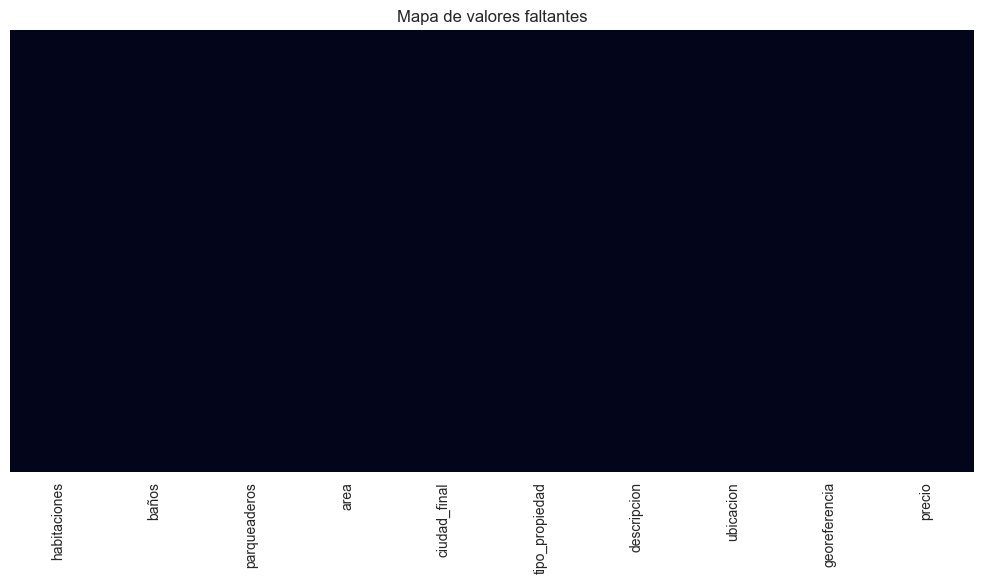

In [387]:
# Eliminar filas con más de 3 valores faltantes
#data_imputed = data_imputed.dropna(thresh=len(data_imputed.columns) - 3)
plt.figure(figsize=(10, 6))
sns.heatmap(data_imputed_knn[num_cols + cat_cols + [target]].isnull(), cbar=False, yticklabels=False)
plt.title('Mapa de valores faltantes')
plt.tight_layout()

La variable descripcion se encuentra normalizada por el proceso anterior, por lo que ahora solo nos queda hacer una tokenizacion <br>
Convertir un conjunto de textos (“descripciones” de propiedades) en una representación numérica (una matriz) que capture la importancia relativa de cada palabra en cada documento, de modo que pueda usarse directamente como entrada a modelos de machine learning (regresores, clasificadores, etc.).




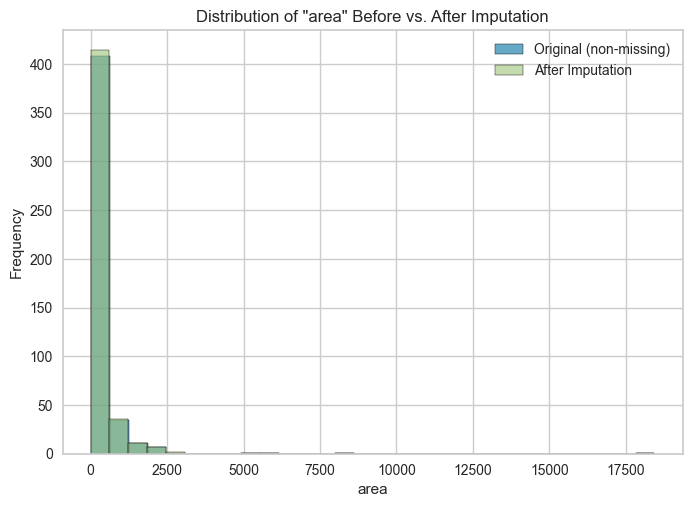

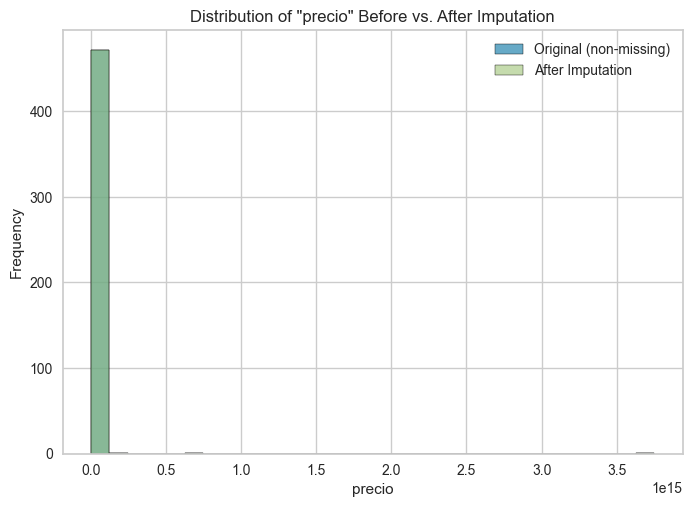

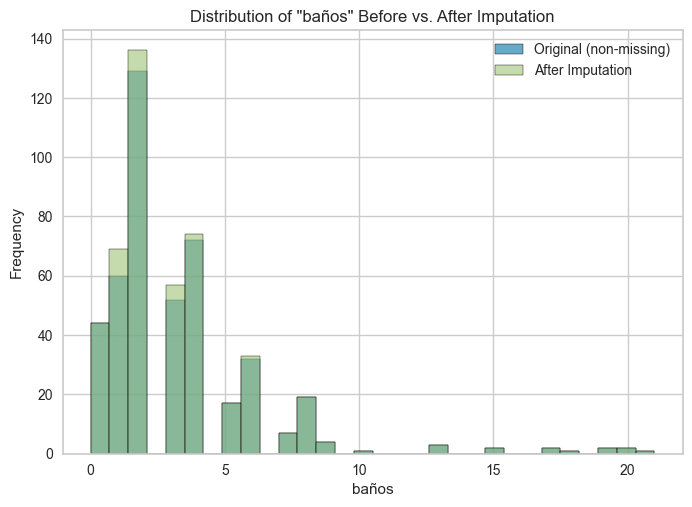

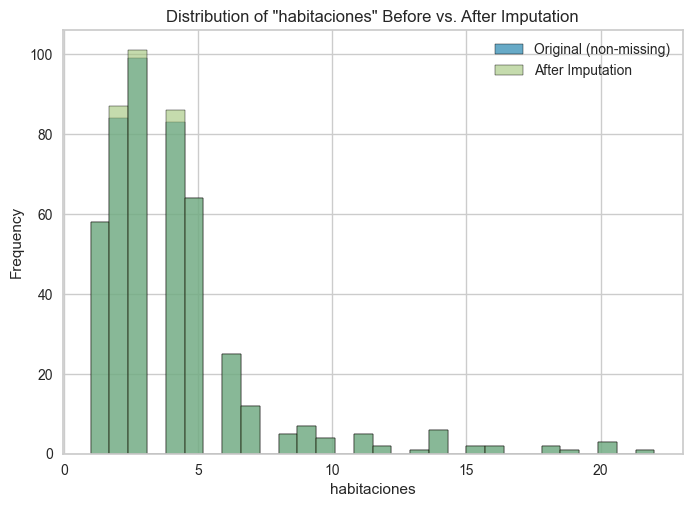

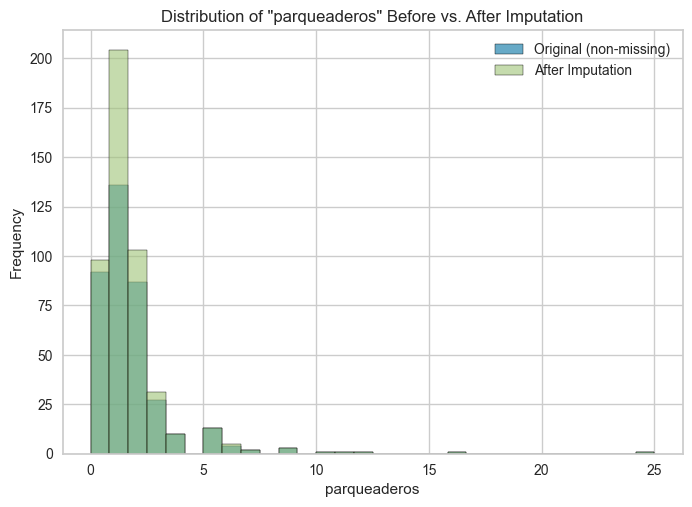

In [388]:
def plot_imputation_distributions(original_df, imputed_df, columns, bins=30):
    """
    Plots the distribution of specified numeric columns before and after imputation.
    
    Parameters:
    - original_df: DataFrame with missing values.
    - imputed_df: DataFrame with imputed values.
    - columns: List of column names to compare.
    - bins: Number of bins for the histograms.
    """
    for col in columns:
        if col not in original_df.columns or col not in imputed_df.columns:
            print(f"Column '{col}' not found in both DataFrames.")
            continue
        
        # Drop missing values from the original for fair comparison
        orig_values = original_df[col].dropna()
        imp_values = imputed_df[col]
        
        sns.histplot(orig_values, bins=bins, alpha=0.6, label='Original (non-missing)')
        sns.histplot(imp_values, bins=bins, alpha=0.6, label='After Imputation')
        plt.title(f'Distribution of "{col}" Before vs. After Imputation')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()


plot_imputation_distributions(data, data_imputed_knn, ['area', 'precio', 'baños', 'habitaciones', 'parqueaderos'], bins=30)



Ver que tanto cambiaron las distribuciones esta bien pero se recomienda tambien hacer un analisis de sensibilidad estadistica despues de realizar hacer imputacion <br>

# Outliers
Antes de realizar cualquier modelamiento es sugerido ver la distribucion de los datos <br>
Realizamos un primer analisis a los datos con los datos faltantes y sin tratamiento para outliers

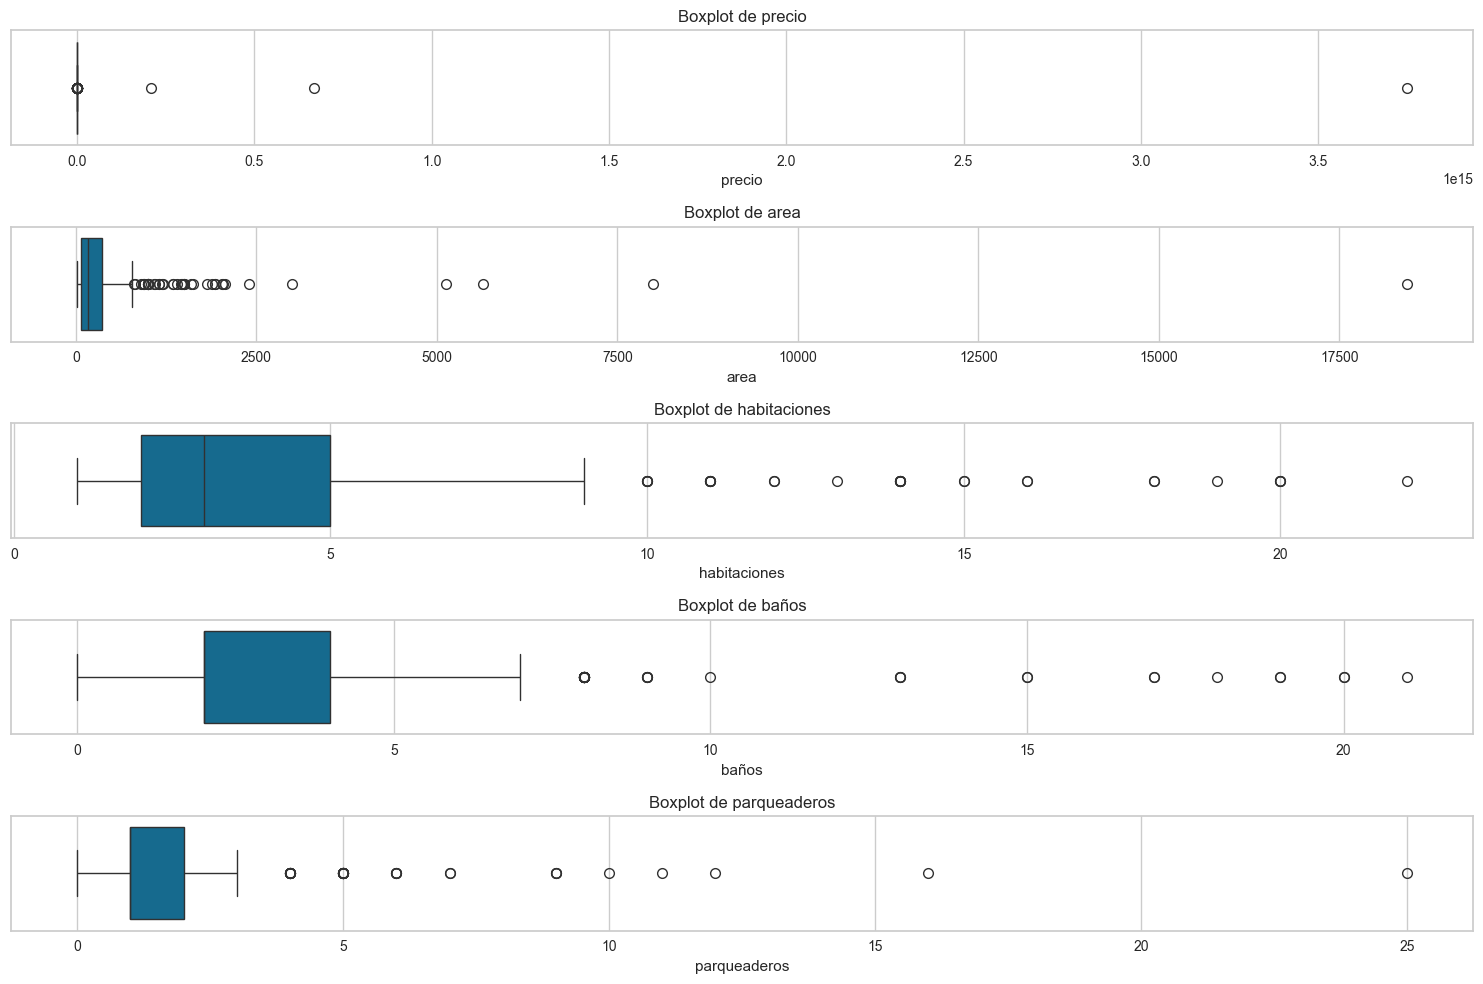

             precio          area  habitaciones       baños  parqueaderos
count  4.740000e+02    466.000000    466.000000  450.000000    379.000000
mean   9.762347e+12    379.333283      4.135193    3.346667      1.675462
std    1.751365e+14   1045.283124      3.250304    3.179108      2.229600
min    7.000000e+05     19.000000      1.000000    0.000000      0.000000
25%    4.500000e+06     70.000000      2.000000    2.000000      1.000000
50%    1.700000e+07    163.900000      3.000000    2.000000      1.000000
75%    3.022500e+08    359.275000      5.000000    4.000000      2.000000
max    3.750000e+15  18433.980000     22.000000   21.000000     25.000000


In [389]:
def plot_outliers(data, cols):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(cols, 1):
        plt.subplot(len(cols), 1, i)
        sns.boxplot(x=data[col])
        plt.title(f'Boxplot de {col}')
    plt.tight_layout()
    plt.show()
    
    # También mostramos estadísticas descriptivas
    print(data[cols].describe())
# Visualizar outliers en variables numéricas
plot_outliers(data, ['precio', 'area', 'habitaciones', 'baños', 'parqueaderos'])

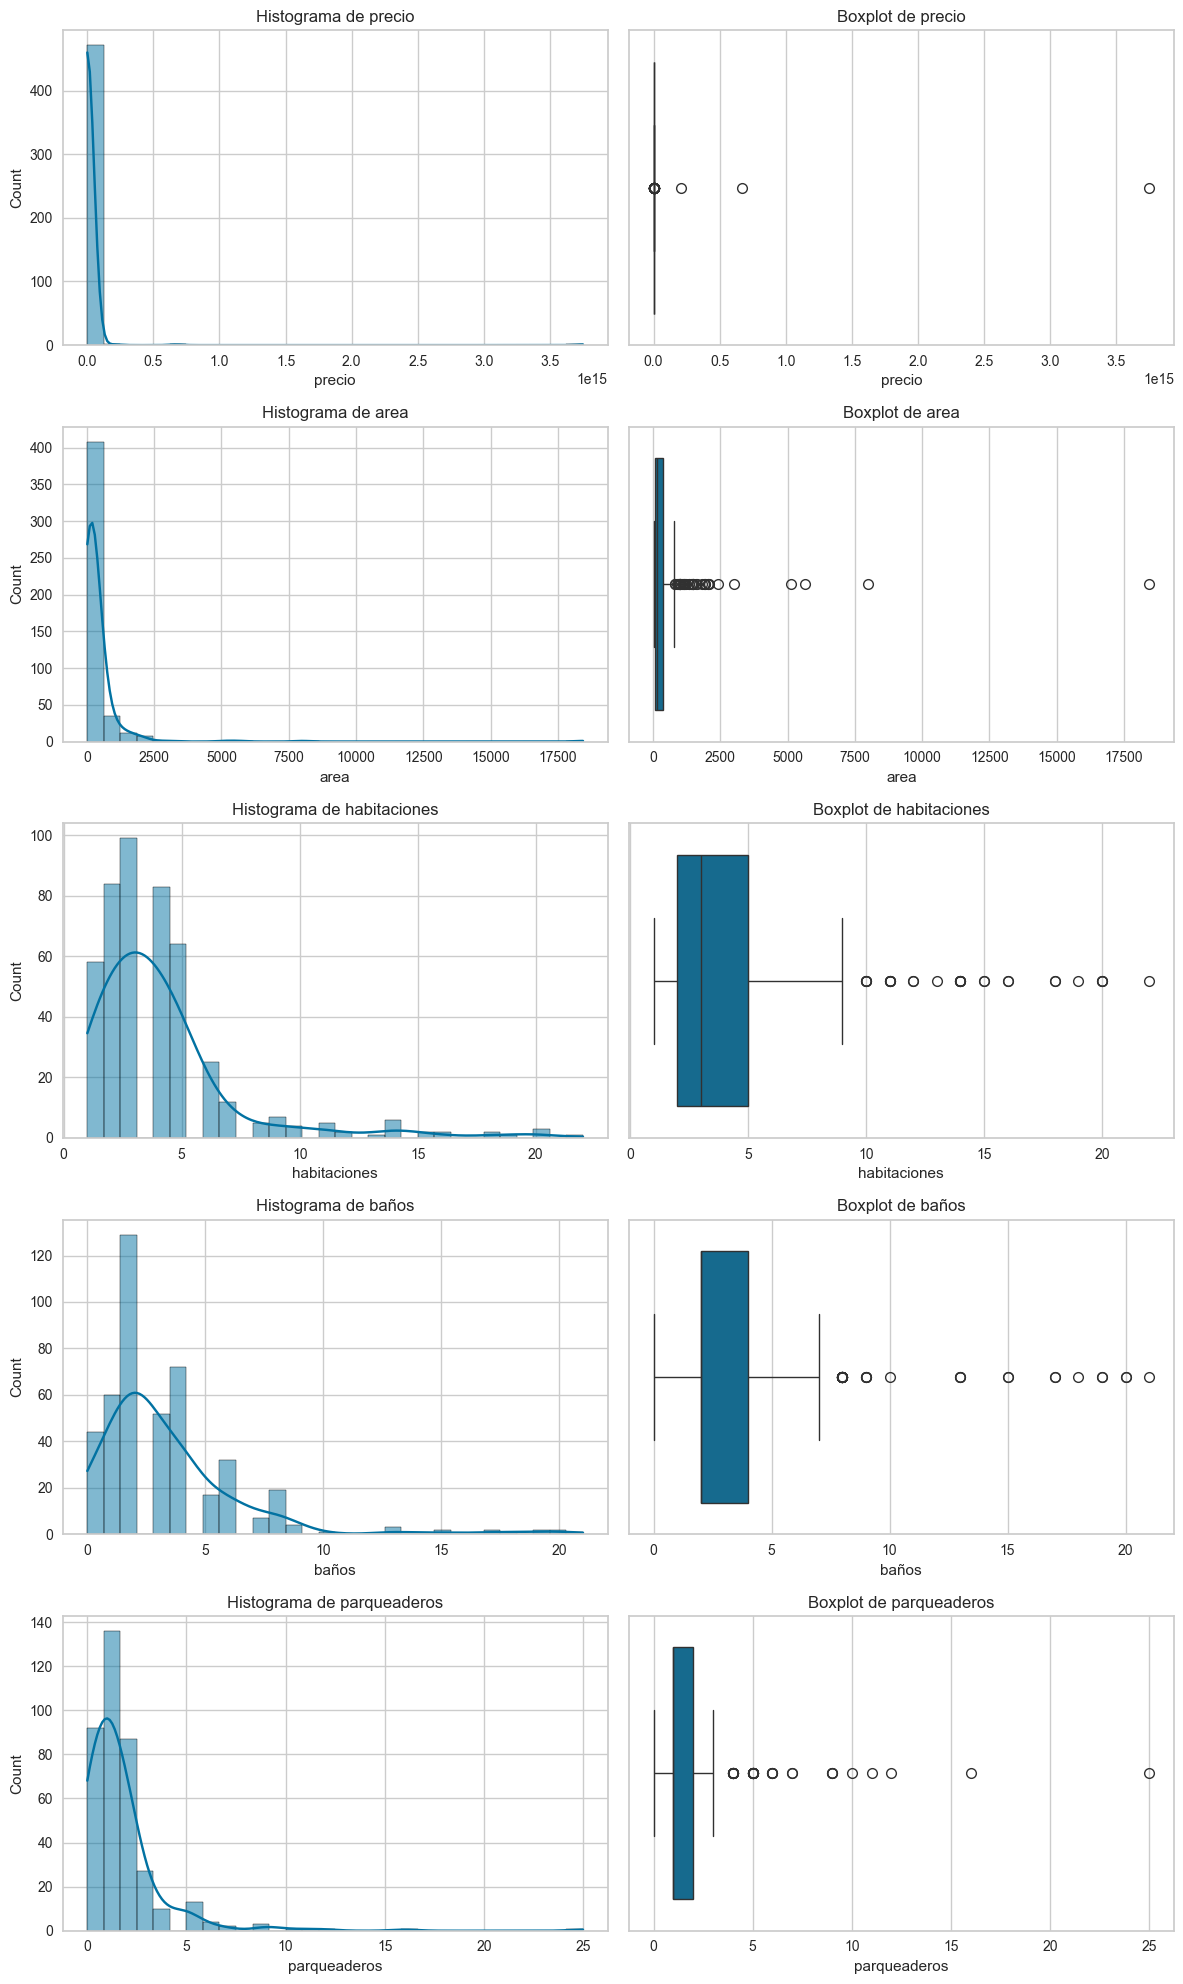

In [390]:
def plot_numerical_distributions(df, cols=None, bins=30):
    """
    Plots histogram and boxplot for each numerical column in the DataFrame.
    If cols is None, uses all numerical columns.
    """
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    n = len(cols)
    plt.figure(figsize=(12, 4 * n))
    for i, col in enumerate(cols):
        # Histogram
        plt.subplot(n, 2, 2 * i + 1)
        sns.histplot(df[col].dropna(), bins=bins, kde=True)
        plt.title(f'Histograma de {col}')
        plt.xlabel(col)
        # Boxplot
        plt.subplot(n, 2, 2 * i + 2)
        sns.boxplot(x=df[col].dropna(), orient='h')
        plt.title(f'Boxplot de {col}')
        plt.xlabel(col)
    plt.tight_layout()
    plt.show()
plot_numerical_distributions(data, cols=['precio', 'area', 'habitaciones', 'baños', 'parqueaderos'])

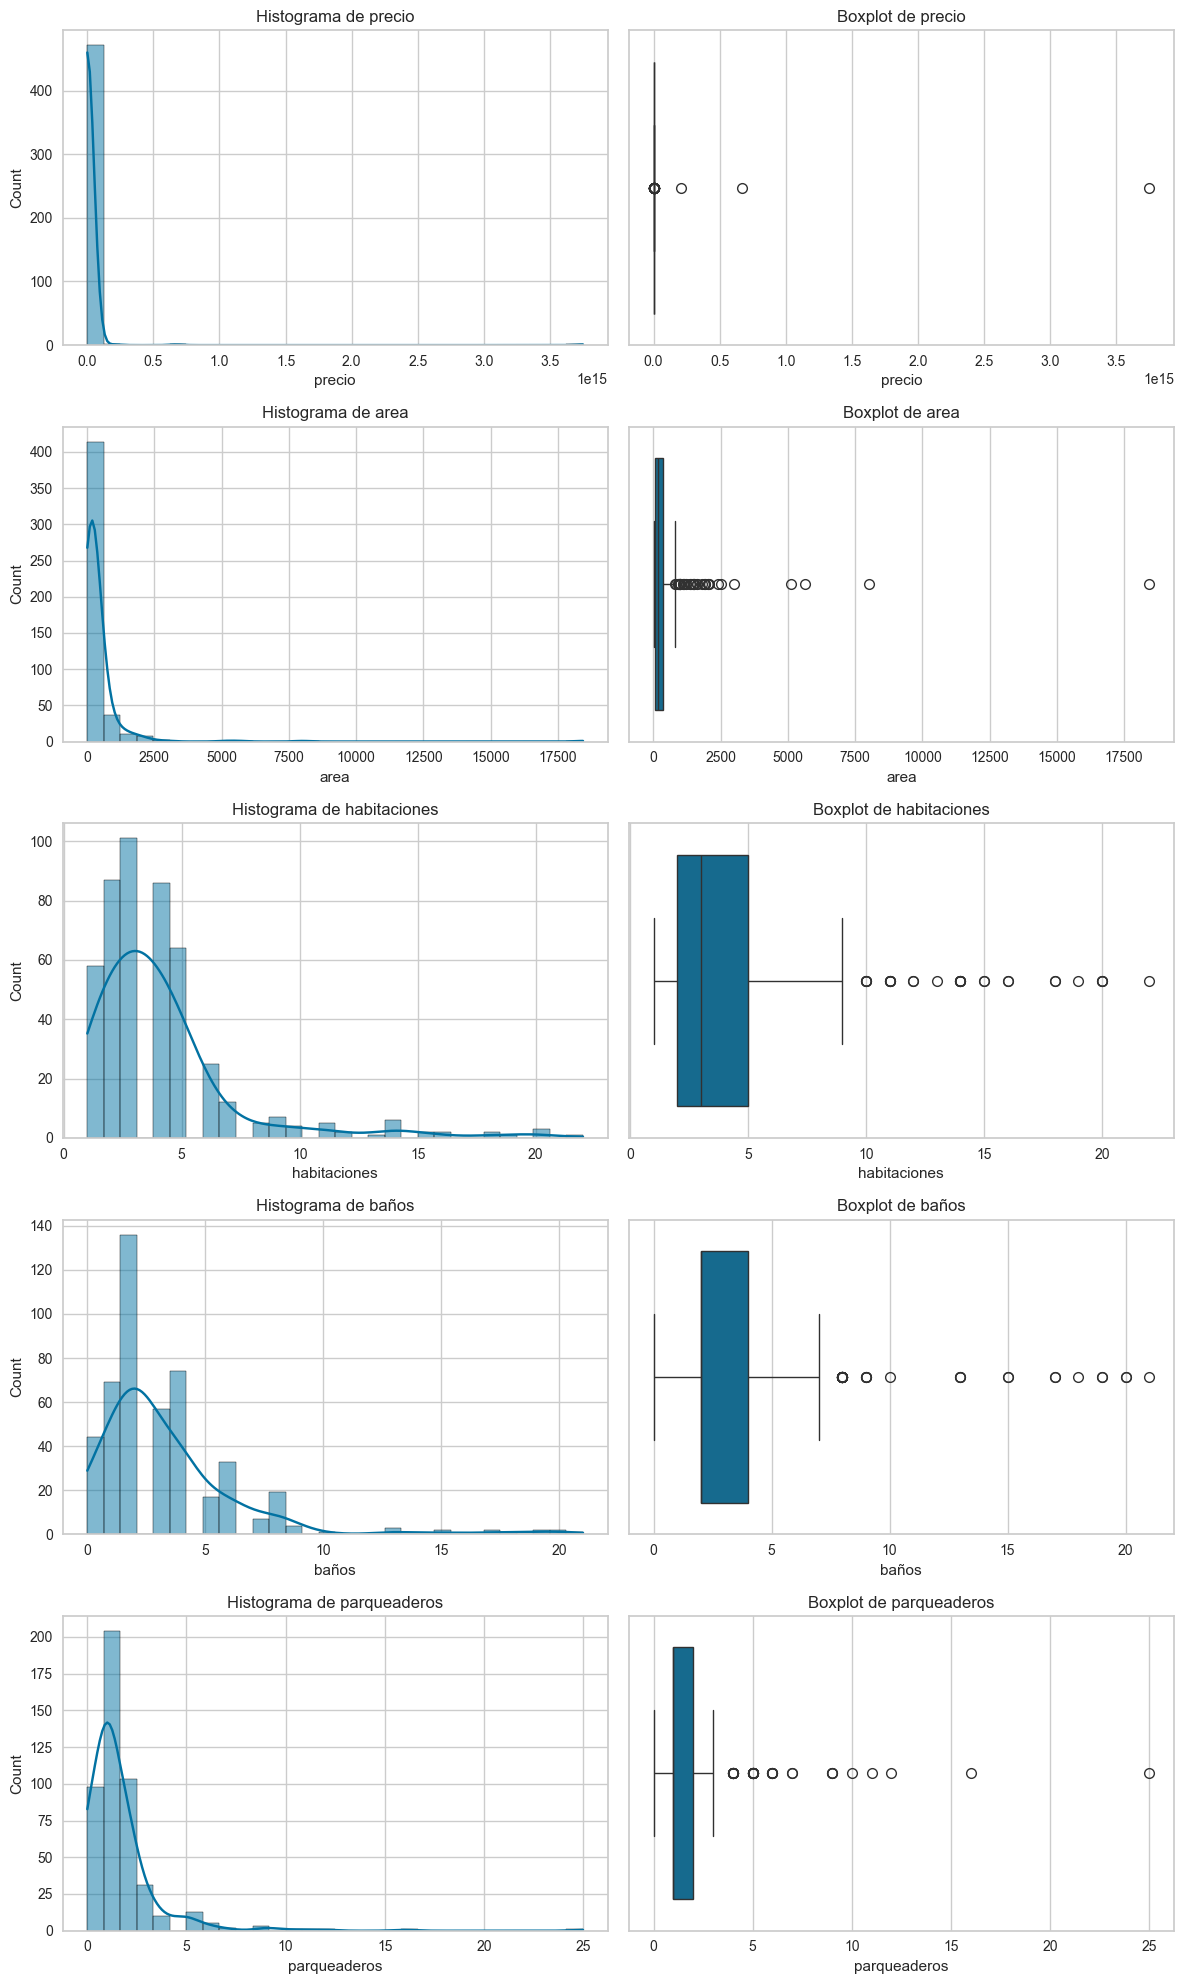

In [391]:
plot_numerical_distributions(data_imputed_knn, cols=['precio', 'area', 'habitaciones', 'baños', 'parqueaderos'])


No pinta bien, se nota una cola muy pesada a la derecha lo que tiene sentido si vemos los boxplots y vemos una gran concetracion de outliers en el extremo derecho, sin tener que pasarlas por un test de normalidad se ve que no cumple pero intenta adoptar la forma de campana de normalidad, igual tener normalidad no es requisito se suele buscar por es de las distribuciones que mejor se dejan modelar, pero con tener una distribucion "suave" es mas que suficiente <br>
Realmente no es una sorpresa debido a que aun no hemos hecho un tratamiento a estos outliers y tambien teniendo en cuenta el contexto de los datos se estan teniendo en cuenta la distribucion de estas variables en todas las ciudades del pais, puede ser que al analizar estas variables de una manera mas granular.


In [392]:
# Detección de outliers usando IQR (Rango Intercuartílico)
def detect_outliers_iqr(data, columns, factor=1.5):
    outliers = {}
    for col in columns:
        if data[col].dtype in ['int64', 'float64']:
            Q1 = data[col].quantile(0.25) # Primer cuartil
            Q3 = data[col].quantile(0.75)  # Tercer cuartil
            IQR = Q3 - Q1 # Rango Intercuartílico
            lower_bound = Q1 - factor * IQR # Banda inferior
            upper_bound = Q3 + factor * IQR  # Banda superior
            outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index.tolist() # todo lo que está fuera de los límites
    return outliers
def plot_and_detect_outliers_per_city(
    data: pd.DataFrame,
    cols: list,
    city_col: str = 'ciudad_final',
    min_count: int = 5,
    factor: float = 1.5 # Puedes ajustar el factor IQR aquí
) -> pd.DataFrame:
    """
    Grafica boxplots por ciudad y calcula CORRECTAMENTE los outliers
    por ciudad usando el método IQR.
    """
    counts = data[city_col].value_counts()
    valid_cities = counts[counts >= min_count].index
    subset = data[data[city_col].isin(valid_cities)].copy()

    n = len(cols)
    fig, axes = plt.subplots(n, 1, figsize=(15, 5 * n), sharex=False)
    if n == 1:
        axes = [axes]

    records = []

    for ax, col in zip(axes, cols):
        sns.boxplot(x=city_col, y=col, data=subset, ax=ax)
        ax.set_title(f'Boxplot de {col} por {city_col}')
        ax.set_xlabel(city_col)
        ax.set_ylabel(col)
        ax.tick_params(axis='x', rotation=90) # Añadir rotación para legibilidad

        for city in valid_cities:
            city_vals = subset.loc[subset[city_col] == city, col].dropna() # Usar subset y dropna
            total = len(city_vals)

            if total < 3: # Necesitas al menos algunos puntos para IQR
                out_count = 0
            else:
                Q1 = city_vals.quantile(0.25)
                Q3 = city_vals.quantile(0.75)
                IQR = Q3 - Q1

                if IQR == 0:
                    out_count = 0 # Si no hay rango, no hay outliers IQR
                else:
                    lower_bound = Q1 - factor * IQR
                    upper_bound = Q3 + factor * IQR
                    out_count = city_vals[(city_vals < lower_bound) | (city_vals > upper_bound)].count()

            records.append({
                city_col: city,
                'variable': col,
                'n_obs': total,
                'outliers_count': out_count,
                'outliers_percentage': (out_count / total * 100) if total > 0 else 0
            })

    plt.tight_layout()
    plt.show()

    summary_df = pd.DataFrame(records)
    return summary_df


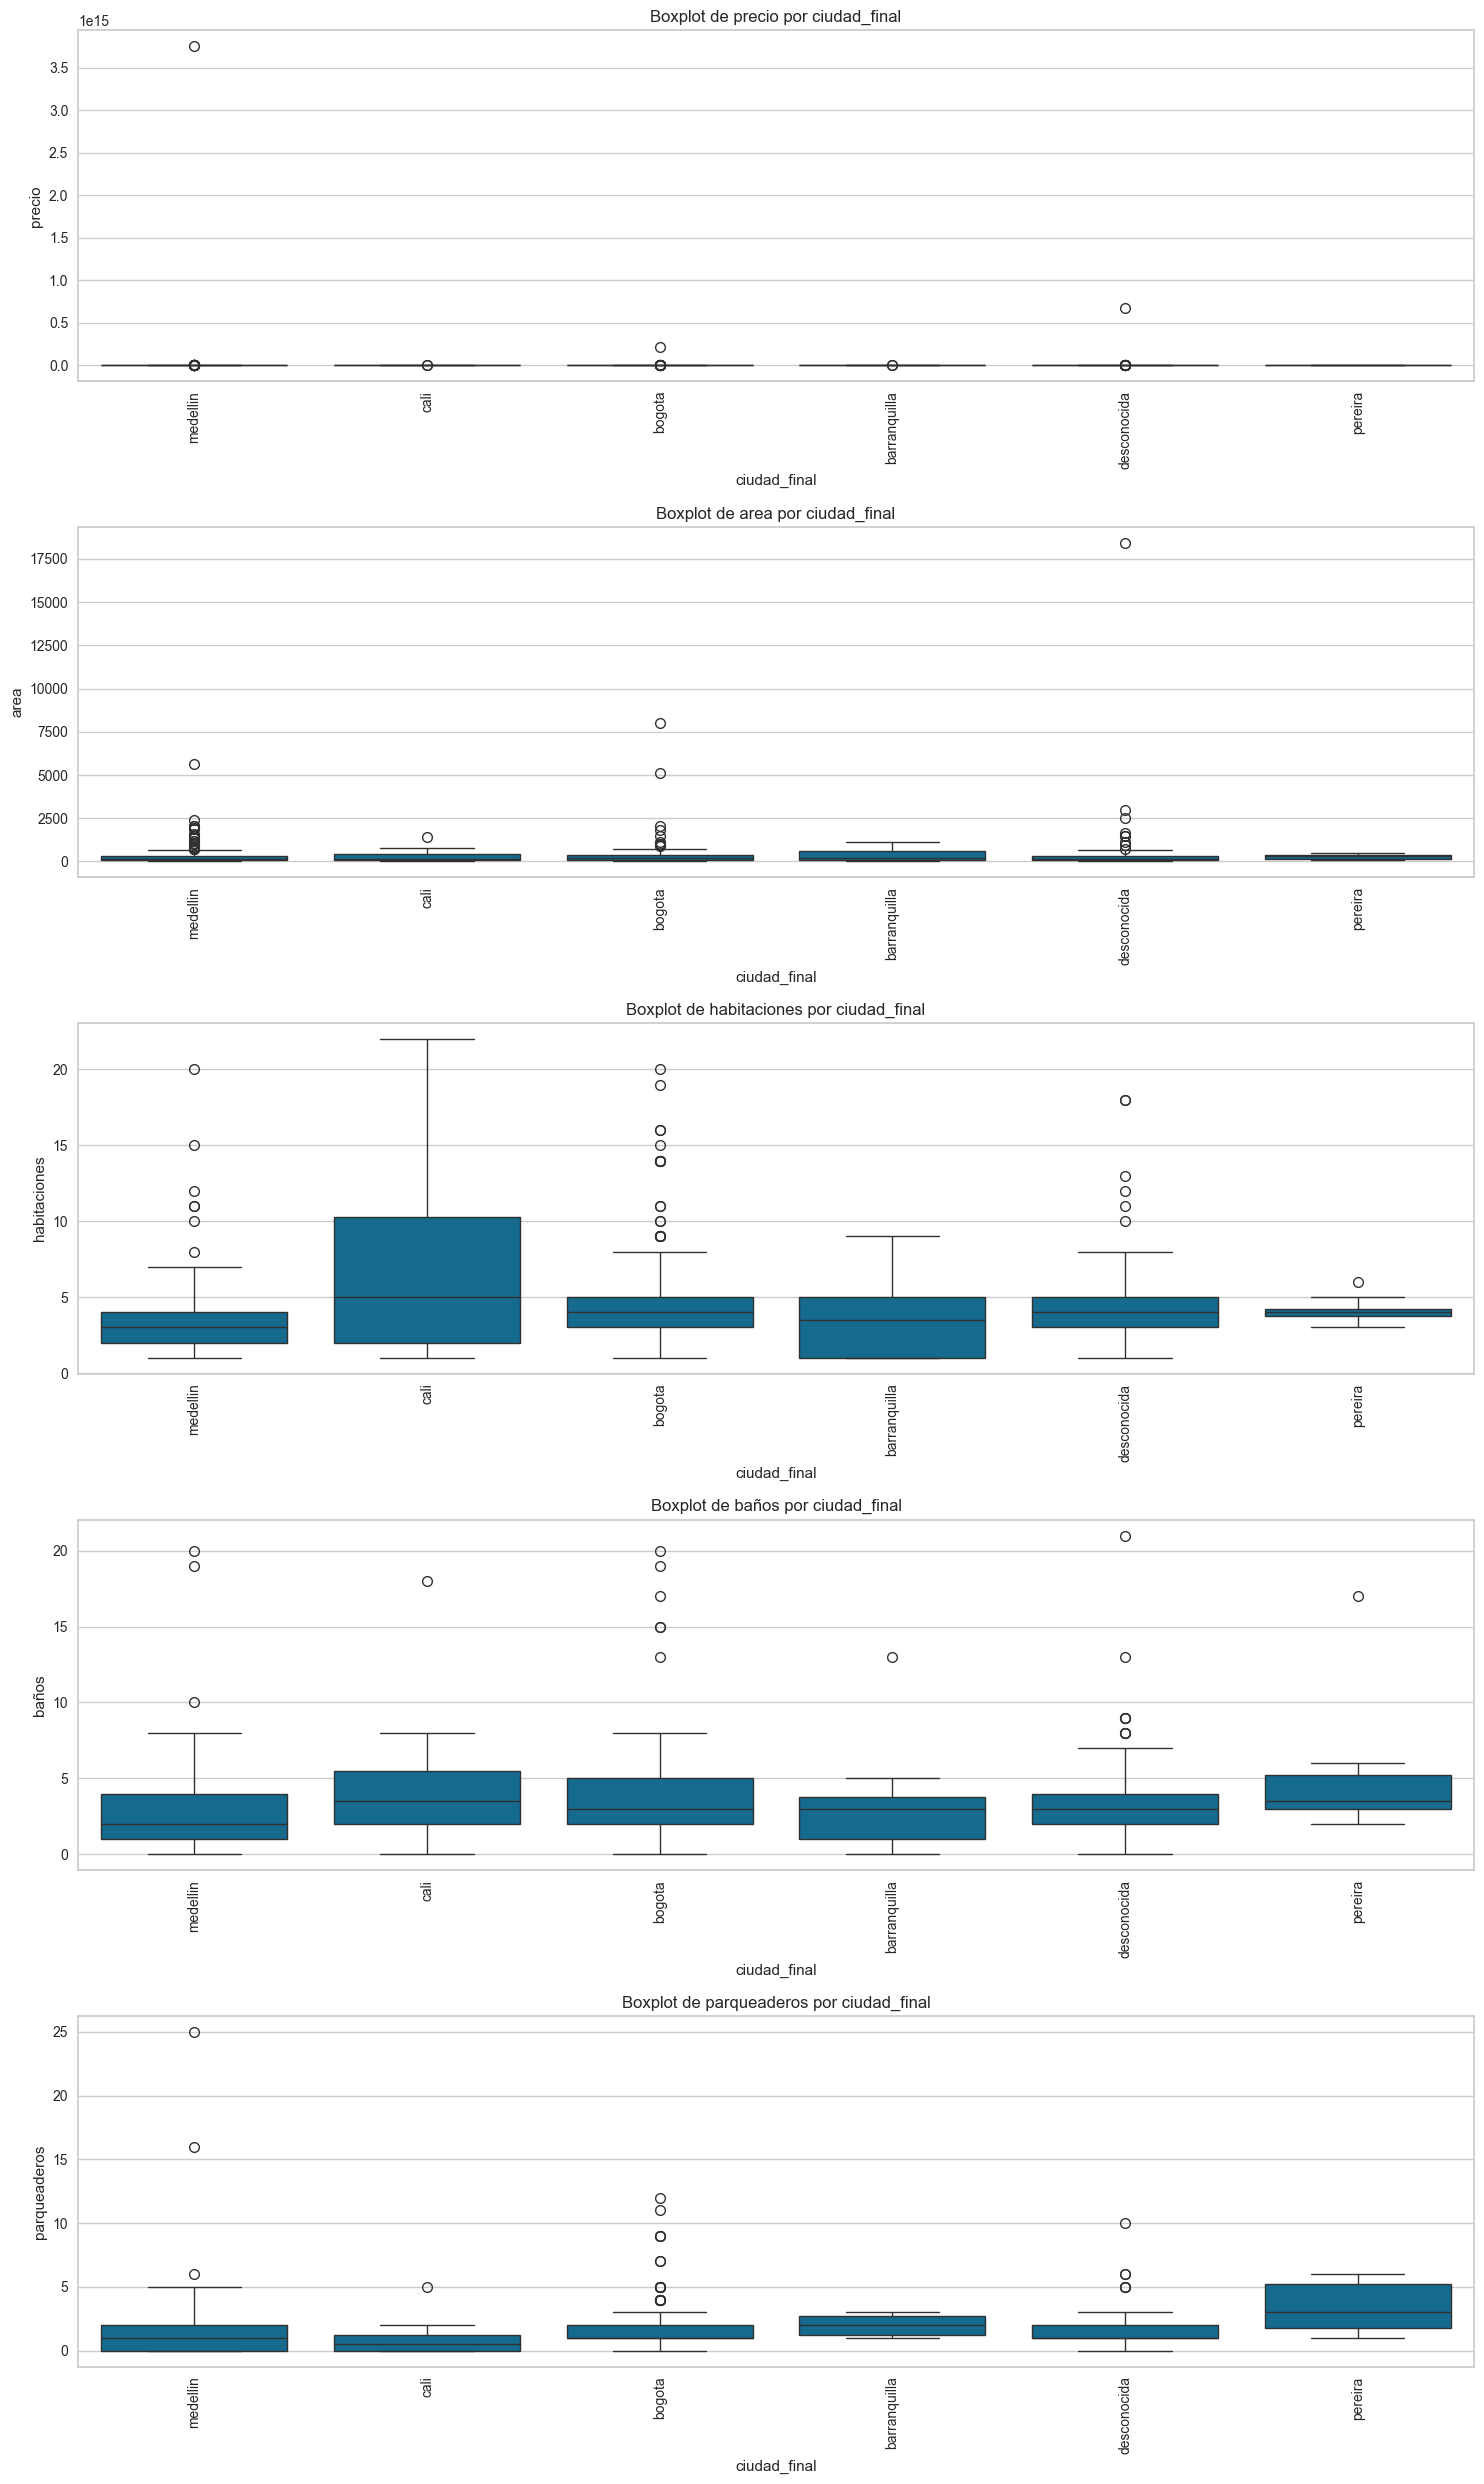

,ciudad_final,variable,n_obs,outliers_count,outliers_percentage
0,medellin,precio,183,39,21.311475
1,bogota,precio,164,17,10.365854
2,desconocida,precio,90,15,16.666667
3,cali,precio,12,2,16.666667
4,barranquilla,precio,10,2,20.000000
5,pereira,precio,8,0,0.000000
6,medellin,area,183,23,12.568306
7,bogota,area,164,12,7.317073
8,desconocida,area,90,9,10.000000
9,cali,area,12,1,8.333333


In [393]:

plot_and_detect_outliers_per_city(data_imputed_knn, ['precio', 'area', 'habitaciones', 'baños', 'parqueaderos'], city_col='ciudad_final', min_count=5)

In [394]:
# Caracteristica extra util para el modelo y para la deteccion de outliers
# Puede que el precio sea muy alto pero el area es muy grande, o viceversa
# Esta funcion es para detectar outliers en base a la relacion entre precio y area
data_imputed_knn['precio_por_m2'] = data_imputed_knn['precio'] / data_imputed_knn['area']
# Detección de outliers usando Z-score
def detect_outliers_zscore(data, columns, threshold=2):
    outliers = {}
    for col in columns:
        if data[col].dtype in ['int64', 'float64']:
            z_scores = stats.zscore(data[col], nan_policy='omit')
            outliers[col] = data[abs(z_scores) > threshold].index.tolist()
    return outliers


In [395]:

# Aplicar ambos métodos
outliers_zscore = detect_outliers_zscore(data_imputed_knn, ['precio', 'area', 'precio_por_m2', 'habitaciones', 'baños', 'parqueaderos'], threshold=3)
outliers_iqr = detect_outliers_iqr(data_imputed_knn, ['precio', 'area', 'precio_por_m2', 'habitaciones', 'baños', 'parqueaderos'], factor=1.5)

print(f"Outliers detectados con Z-score en precio: {len(outliers_zscore['precio'])}")
print(f"Outliers detectados con IQR en precio: {len(outliers_iqr['precio'])}")

Outliers detectados con Z-score en precio: 2
Outliers detectados con IQR en precio: 65



Para el tratamiento de outliers hay que tener en cuenta el contexto, analizar la base de datos completa no esta mal y nos da un primer acercamiento pero es valido segmentar la base de datos por caracteristicas comunes para realizar el tratamiento de outliers, tambien se pueden realizar la creacion de caracteristicas que nos permitan analizar variables de interes pero se tiene que analizar que haya significancia en la relacion, esto se puede hacer con un analisis de regresion simple




1. **Contamos filas iniciales** para medir el impacto de la operación.  
2. **Iteramos** sobre cada columna numérica (`float64`, `int64`).  
3. **Calculamos el Z-score** (valor estándar) de cada punto y marcamos los índices cuyo Z-score supere un umbral (por defecto, 5 o sea que toma como outlier los datos que se encuentre a mas de 5 desviaciones estandar).  Existe una regla empírica que establece que: ~99,7 % de los datos en una distribución normal se encuentran dentro de 3 desviaciones estándar de la media. Entre mas alto el valor menos estricto.
4. **Registramos** para cada fila outlier en qué columna(s) se detectó.  
5. **Creamos un DataFrame** `outliers_df` con esas filas y una columna adicional `outlier_in` que lista las variables responsables.  
6. **Eliminamos** dichas filas del DataFrame original para obtener `data_filtered`.  
7. **Imprimimos** cuántas filas se eliminaron y su porcentaje relativo.  
8. **Devolvemos** el DataFrame limpio y el DataFrame de outliers con sus metadatos.

---


- Separarlos permite:  
  - **Inspección manual** de outliers antes de decidir imputación o corrección.  
  - **Evitar** que esas observaciones extremas influyan desproporcionadamente en el entrenamiento de modelos (sesgo de estimación).  
- Registrar la columna de detección facilita entender **qué variable** está generando el problema.


Se eliminaron 6 filas con outliers extremos (1.27% del dataset)


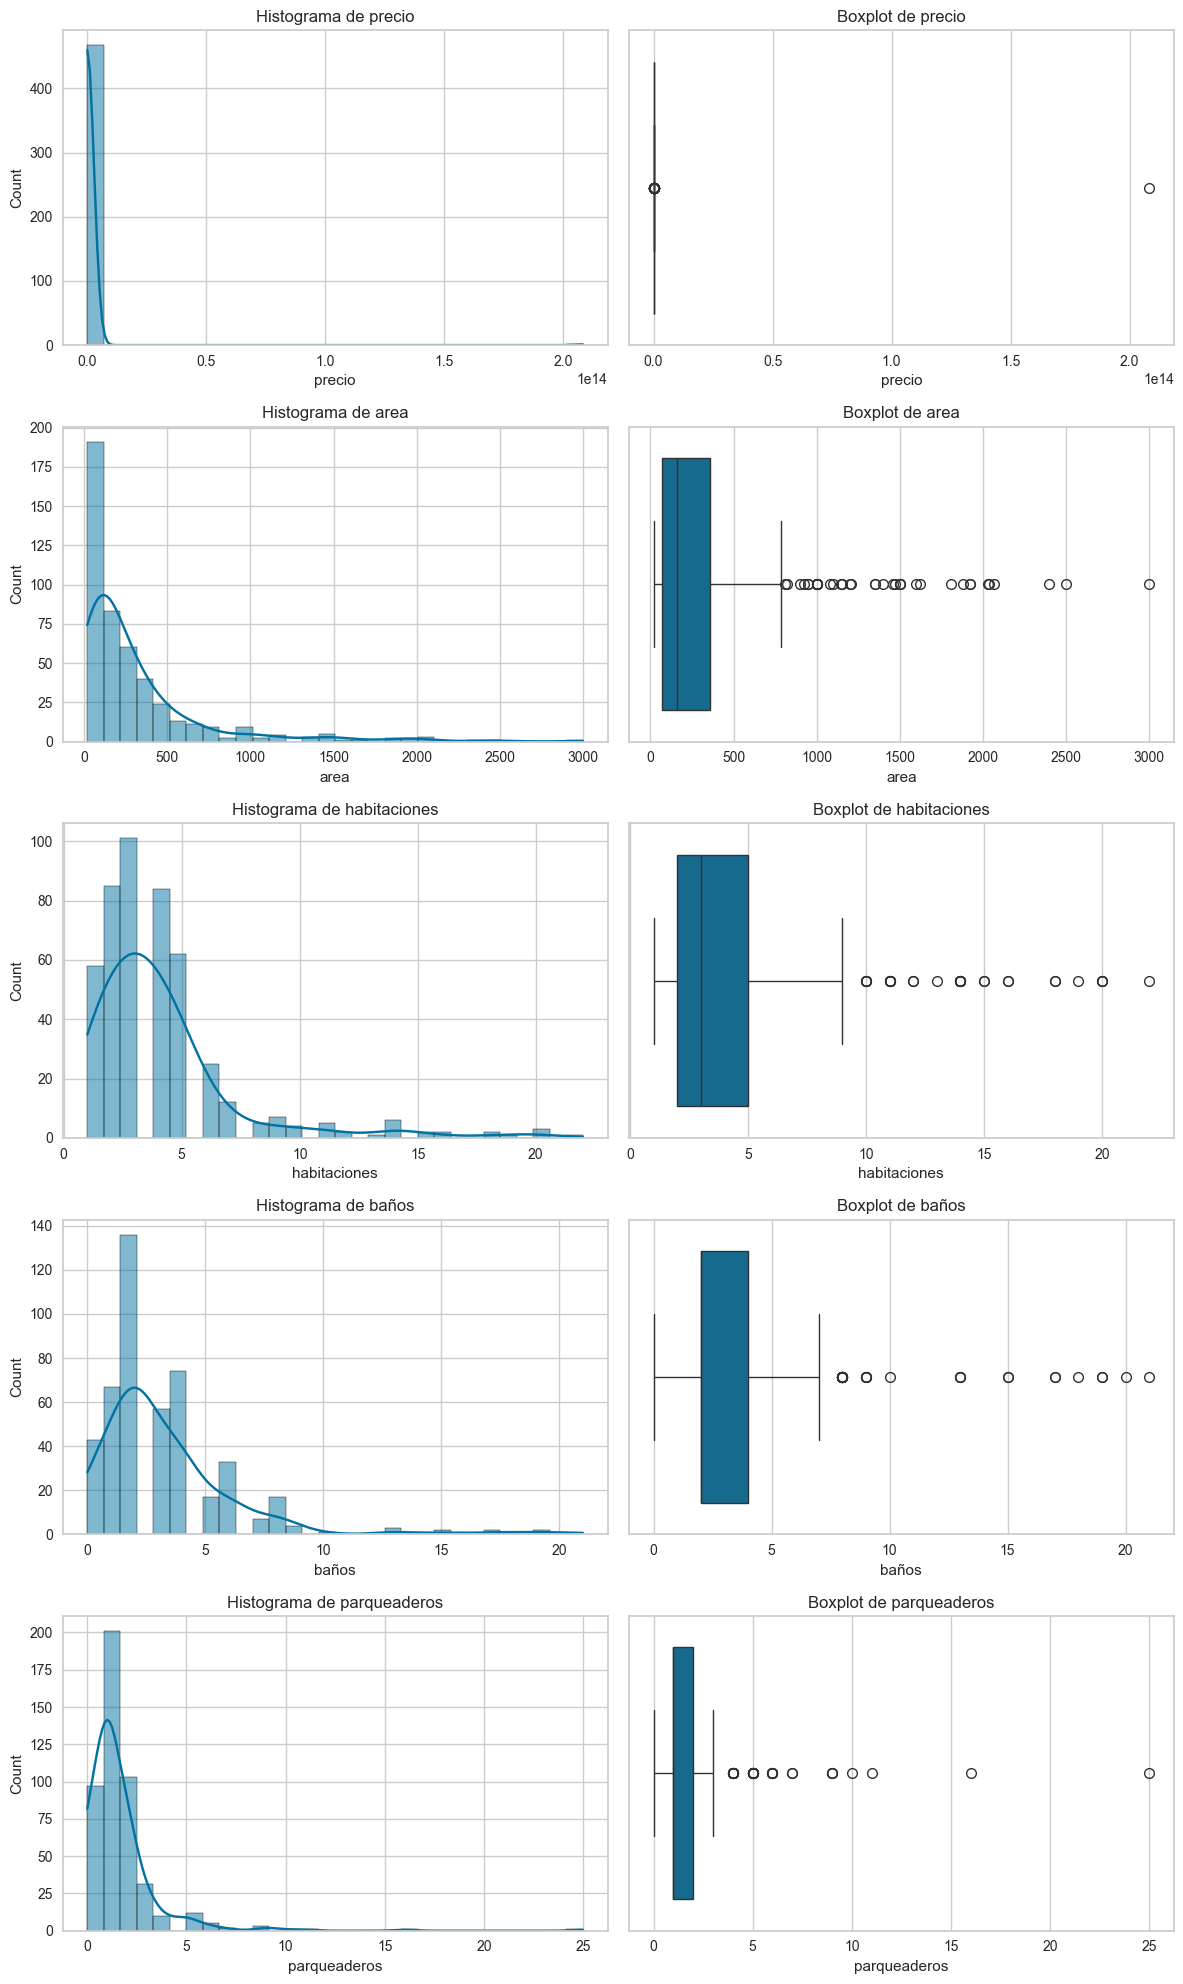

In [396]:
import pandas as pd
import numpy as np
from scipy import stats

def remove_extreme_outliers_with_flag(data, zscore_threshold=3): 
    """
    Elimina outliers extremos basados en Z-score muy alto para todas las columnas numéricas.
    Devuelve un DataFrame con los outliers separados e indica en qué columna(s) fueron detectados.
    """
    initial_rows = len(data)
    outliers_dict = {}

    # Calcular Z-scores para todas las columnas numéricas
    for col in data.select_dtypes(include=['float64', 'int64']):
        z_scores = np.abs(stats.zscore(data[col], nan_policy='omit'))
        col_outliers_indices = data[z_scores > zscore_threshold].index # aquí se obtienen los indices de los outliers
        for index in col_outliers_indices: # for que se va a iterar por los indices de los outliers
            if index not in outliers_dict:
                outliers_dict[index] = {'outlier_in': [col]}# si el indice no está en el diccionario, se crea una nueva entrada
            else:
                outliers_dict[index]['outlier_in'].append(col)  # si el indice ya está en el diccionario, se añade la columna a la lista de columnas con outliers

    outliers_indices = list(outliers_dict.keys())

    # Crear DataFrame de outliers
    outliers_df = data.loc[outliers_indices].copy()  # Usamos .copy() para evitar warnings
    outliers_df['outlier_in'] = [outliers_dict[idx]['outlier_in'] for idx in outliers_indices]

    # Eliminar outliers extremos del DataFrame original
    data_filtered = data.drop(index=outliers_indices)

    removed_rows = initial_rows - len(data_filtered)
    print(f"Se eliminaron {removed_rows} filas con outliers extremos ({removed_rows/initial_rows:.2%} del dataset)")

    return data_filtered, outliers_df



data_filtered, outliers_df = remove_extreme_outliers_with_flag(data_imputed_knn, zscore_threshold=3)
outliers_df.head(10)
# imprimiendo outliers en precio y area
outliers_df[outliers_df['outlier_in'].apply(lambda x: 'precio' in x or 'area' in x)]

plot_numerical_distributions(data_filtered, cols=['precio', 'area', 'habitaciones', 'baños', 'parqueaderos'])

In [397]:
outliers_df.head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2,outlier_in
298,669000002115975,te presentamos esta confortable casa ubicada e...,2,1,1,52.256,,Casa en venta,san cayetano,desconocida,1.280236e+13,[precio]
418,3750000034121000,bodega industrial en dorado area de 1.950 metr...,2,1,1,1.950,,Bodega en arriendo,dorado,medellin,1.923077e+15,"[precio, precio_por_m2]"
2,1200000000,"la calera, la plazuela, alto de la virgen",4,8,12,5127.000,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,centro,bogota,2.340550e+05,[area]
357,4100000000,"cota, parque industrial portos sabana 80, br s...",5,8,5,18433.980,Te presentamos esta confortable casa ubicada e...,Casa en venta,vereda siberia,desconocida,2.224153e+05,[area]
447,70000000,"centro fontibon, campo alegre, villemar fontibon",4,0,1,8000.000,"Bodega industrial a doble altura, dos areas de...",Bodega en arriendo,fontibon,bogota,8.750000e+03,[area]


Nuevamente voy a hacer el proceso de eliminar primero los outliers globales y luego realizarlos por ciudad, aqui podemos personalizar un poco mas el tratamiento, podemos ser mas estrictos en la eliminacion de outliers globales, y mas permisivos en los de por ciudad o viceversa. <br>
Ya se eliminaron los globales, ahora siguen los por ciudad <br>

In [398]:
def remove_outliers_per_city_iqr(df, city_column, cols_to_check, factor=1.5, min_samples_per_city=10):
    """
    Detecta y elimina outliers por ciudad para las columnas especificadas
    usando el método IQR.

    Parameters:
    - df: DataFrame de entrada.
    - city_column: Nombre de la columna que identifica la ciudad.
    - cols_to_check: Lista de columnas numéricas para verificar outliers.
    - factor: Factor para calcular los límites del IQR (usualmente 1.5).
    - min_samples_per_city: Número mínimo de muestras para que una ciudad sea procesada.

    Returns:
    - df_filtered: DataFrame con los outliers eliminados.
    - outliers_df: DataFrame que contiene las filas eliminadas.
    """
    df_copy = df.copy()
    initial_rows = len(df_copy)
    
    all_outlier_indices = set()
    outlier_details_list = [] # Para almacenar detalles de los outliers

    print(f"Iniciando detección y eliminación de outliers por ciudad (método IQR, factor={factor})...")

    for city_name, group_data in df_copy.groupby(city_column):
        if len(group_data) < min_samples_per_city:
            print(f"  - Ciudad '{city_name}': Omitida (menos de {min_samples_per_city} muestras).")
            continue

        print(f"  - Procesando ciudad: '{city_name}' ({len(group_data)} muestras)")
        city_outlier_indices_for_log = set()

        for col in cols_to_check:
            if col in group_data.columns and group_data[col].dtype in ['int64', 'float64']:
                col_data = group_data[col].dropna() # Trabajar solo con valores no nulos para esta columna/ciudad
                if len(col_data) < 3: # IQR necesita al menos algunos puntos
                    continue

                Q1 = col_data.quantile(0.25)
                Q3 = col_data.quantile(0.75)
                IQR = Q3 - Q1

                    
                lower_bound = Q1 - factor * IQR
                upper_bound = Q3 + factor * IQR
                
                # Identificar outliers DENTRO del grupo actual (ciudad) para la columna actual
                outliers_in_group_col = group_data[
                    (group_data[col] < lower_bound) | (group_data[col] > upper_bound)
                ]
                
                current_col_outlier_indices = set(outliers_in_group_col.index)
                
                if current_col_outlier_indices:
                    all_outlier_indices.update(current_col_outlier_indices)
                    city_outlier_indices_for_log.update(current_col_outlier_indices)
                    
                    # Almacenar detalles
                    for idx in current_col_outlier_indices:
                        outlier_details_list.append({
                            'index': idx,
                            city_column: city_name,
                            'outlier_in_col': col,
                            'value': df_copy.loc[idx, col],
                            'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
                            'lower_bound': lower_bound, 'upper_bound': upper_bound
                        })
        if city_outlier_indices_for_log:
             print(f"  - Ciudad '{city_name}': {len(city_outlier_indices_for_log)} filas marcadas como outliers en al menos una columna.")


    outlier_indices_list_final = list(all_outlier_indices)

    # Crear DataFrame de outliers con detalles
    outliers_df = pd.DataFrame(outlier_details_list)
    if not outliers_df.empty:
        # Para tener una fila por outlier original, agrupamos y listamos las columnas donde fue outlier
        outliers_summary_df = outliers_df.groupby('index').agg(
            **{city_column: pd.NamedAgg(column=city_column, aggfunc='first'),
               'outlier_in_cols': pd.NamedAgg(column='outlier_in_col', aggfunc=lambda x: list(set(x)))
              }
        ).reset_index()
        # Unir con los datos originales de los outliers
        outliers_final_df = df_copy.loc[outliers_summary_df['index']].copy()
        outliers_final_df = outliers_final_df.join(outliers_summary_df.set_index('index')[['outlier_in_cols', city_column]], rsuffix='_group')
    else:
        outliers_final_df = pd.DataFrame(columns=df_copy.columns.tolist() + ['outlier_in_cols', city_column + '_group'])


    # Crear el DataFrame filtrado
    df_filtered = df_copy.drop(index=outlier_indices_list_final)

    removed_rows = len(outlier_indices_list_final)
    percentage_removed = (removed_rows / initial_rows) * 100 if initial_rows > 0 else 0
    
    print("\n--- Resumen de Eliminación de Outliers Por Ciudad (IQR) ---")
    print(f"Filas antes del tratamiento por ciudad: {initial_rows}")
    print(f"Filas eliminadas (outliers contextuales): {removed_rows}")
    print(f"Porcentaje eliminado en este paso: {percentage_removed:.2f}%")
    print(f"Filas restantes: {len(df_filtered)}")
    print("---------------------------------------------------------\n")

    return df_filtered, outliers_final_df


Iniciando detección y eliminación de outliers por ciudad (método IQR, factor=5)...
  - Procesando ciudad: 'barranquilla' (10 muestras)
  - Procesando ciudad: 'bogota' (162 muestras)
  - Ciudad 'bogota': 5 filas marcadas como outliers en al menos una columna.
  - Procesando ciudad: 'cali' (12 muestras)
  - Ciudad 'cali': 1 filas marcadas como outliers en al menos una columna.
  - Ciudad 'cartagena': Omitida (menos de 10 muestras).
  - Procesando ciudad: 'desconocida' (88 muestras)
  - Ciudad 'desconocida': 5 filas marcadas como outliers en al menos una columna.
  - Ciudad 'manizales': Omitida (menos de 10 muestras).
  - Procesando ciudad: 'medellin' (181 muestras)
  - Ciudad 'medellin': 46 filas marcadas como outliers en al menos una columna.
  - Ciudad 'pereira': Omitida (menos de 10 muestras).

--- Resumen de Eliminación de Outliers Por Ciudad (IQR) ---
Filas antes del tratamiento por ciudad: 468
Filas eliminadas (outliers contextuales): 57
Porcentaje eliminado en este paso: 12.18%
Fi

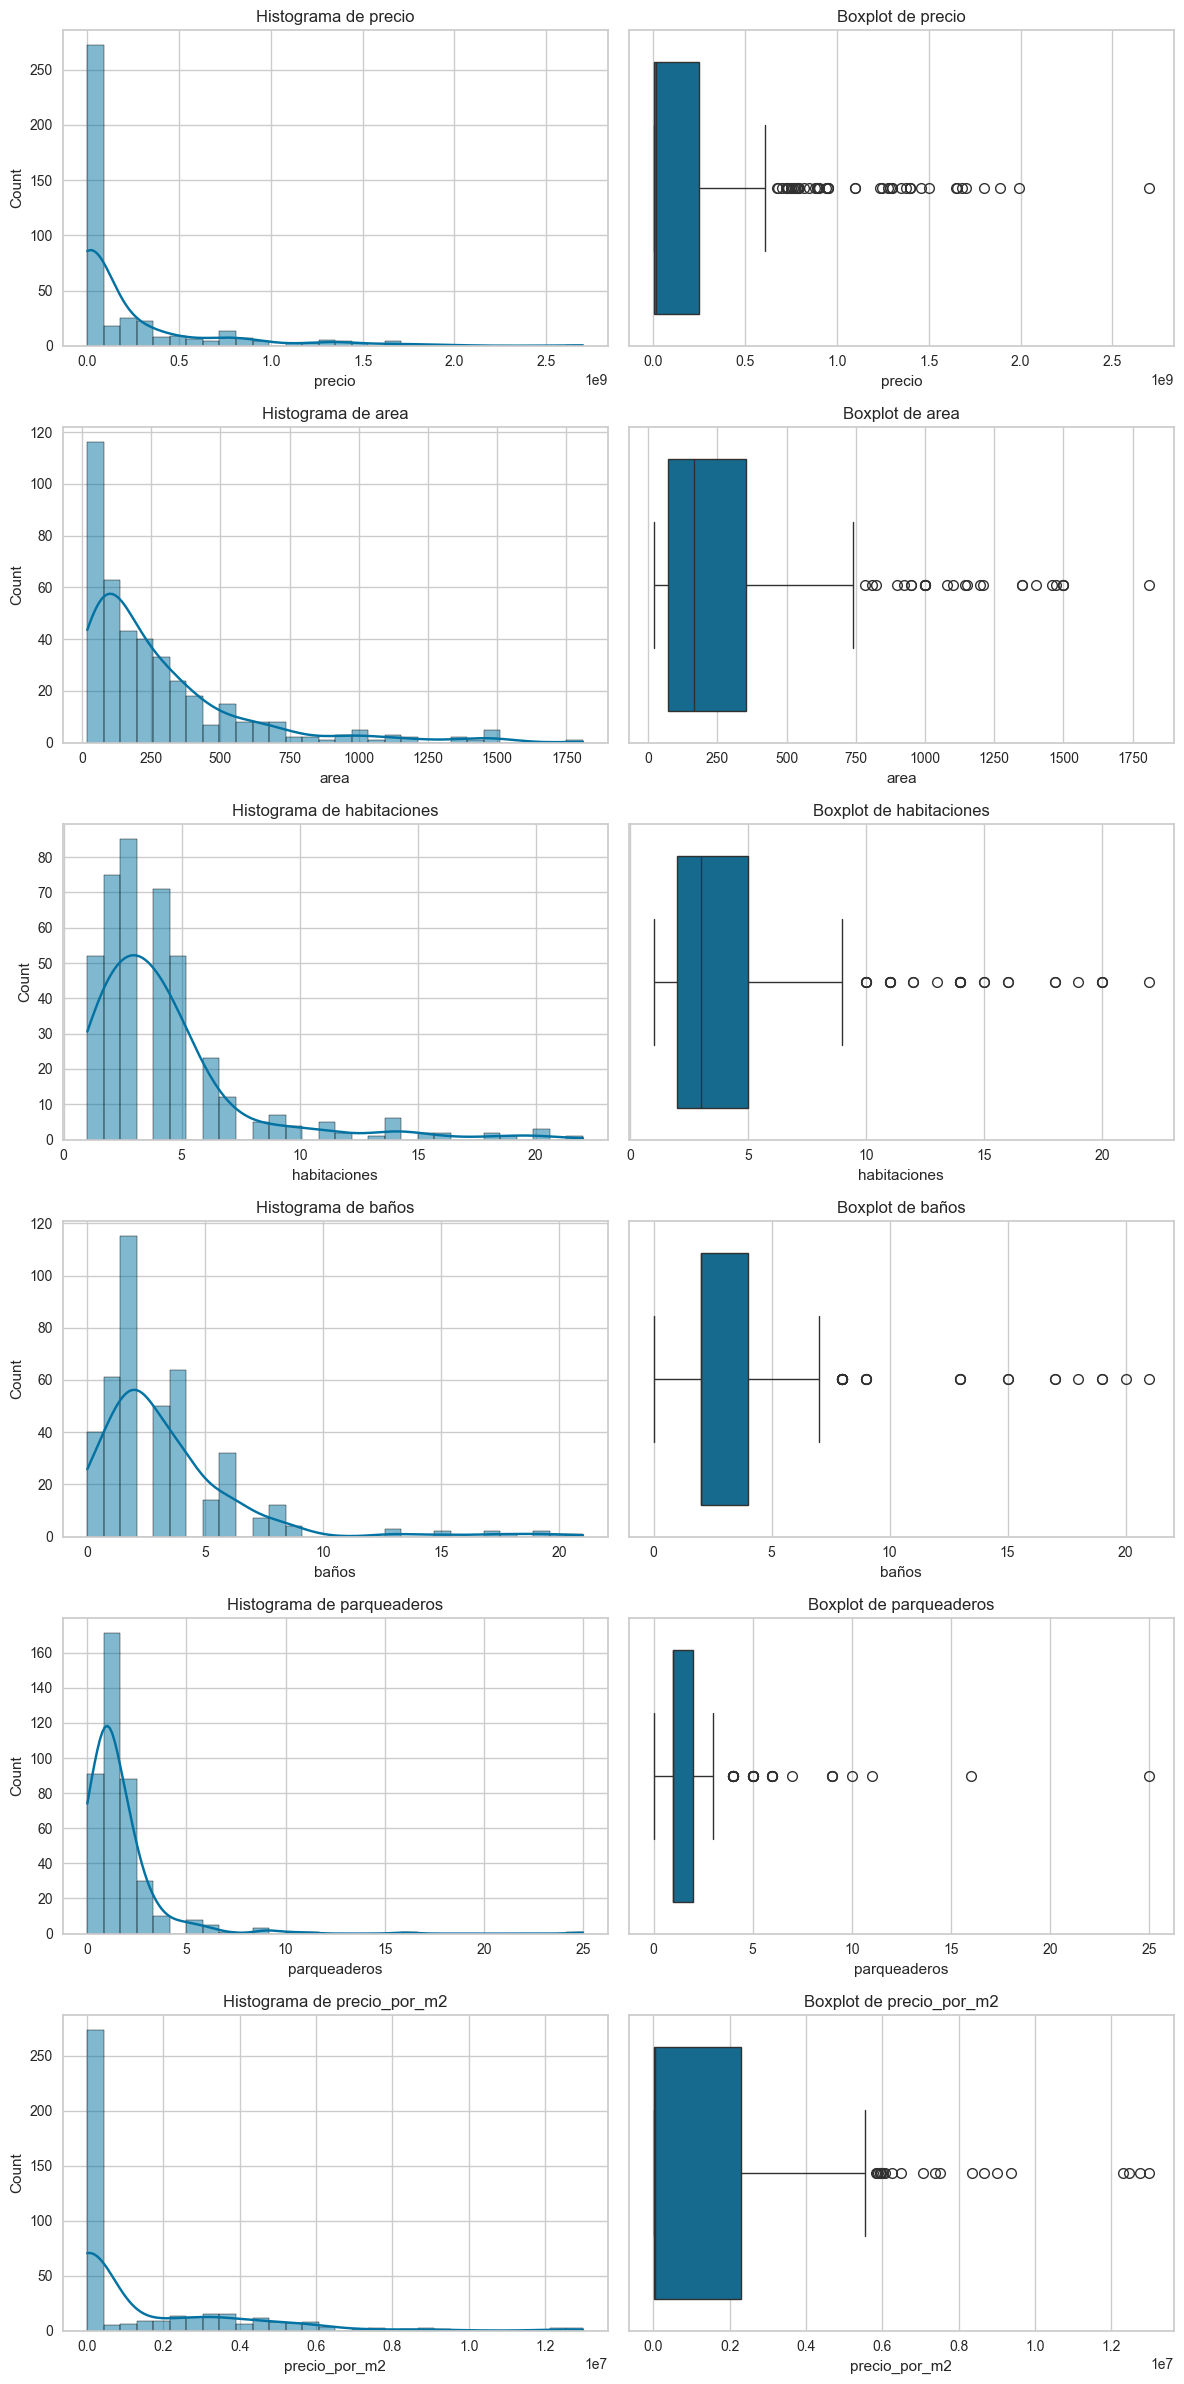

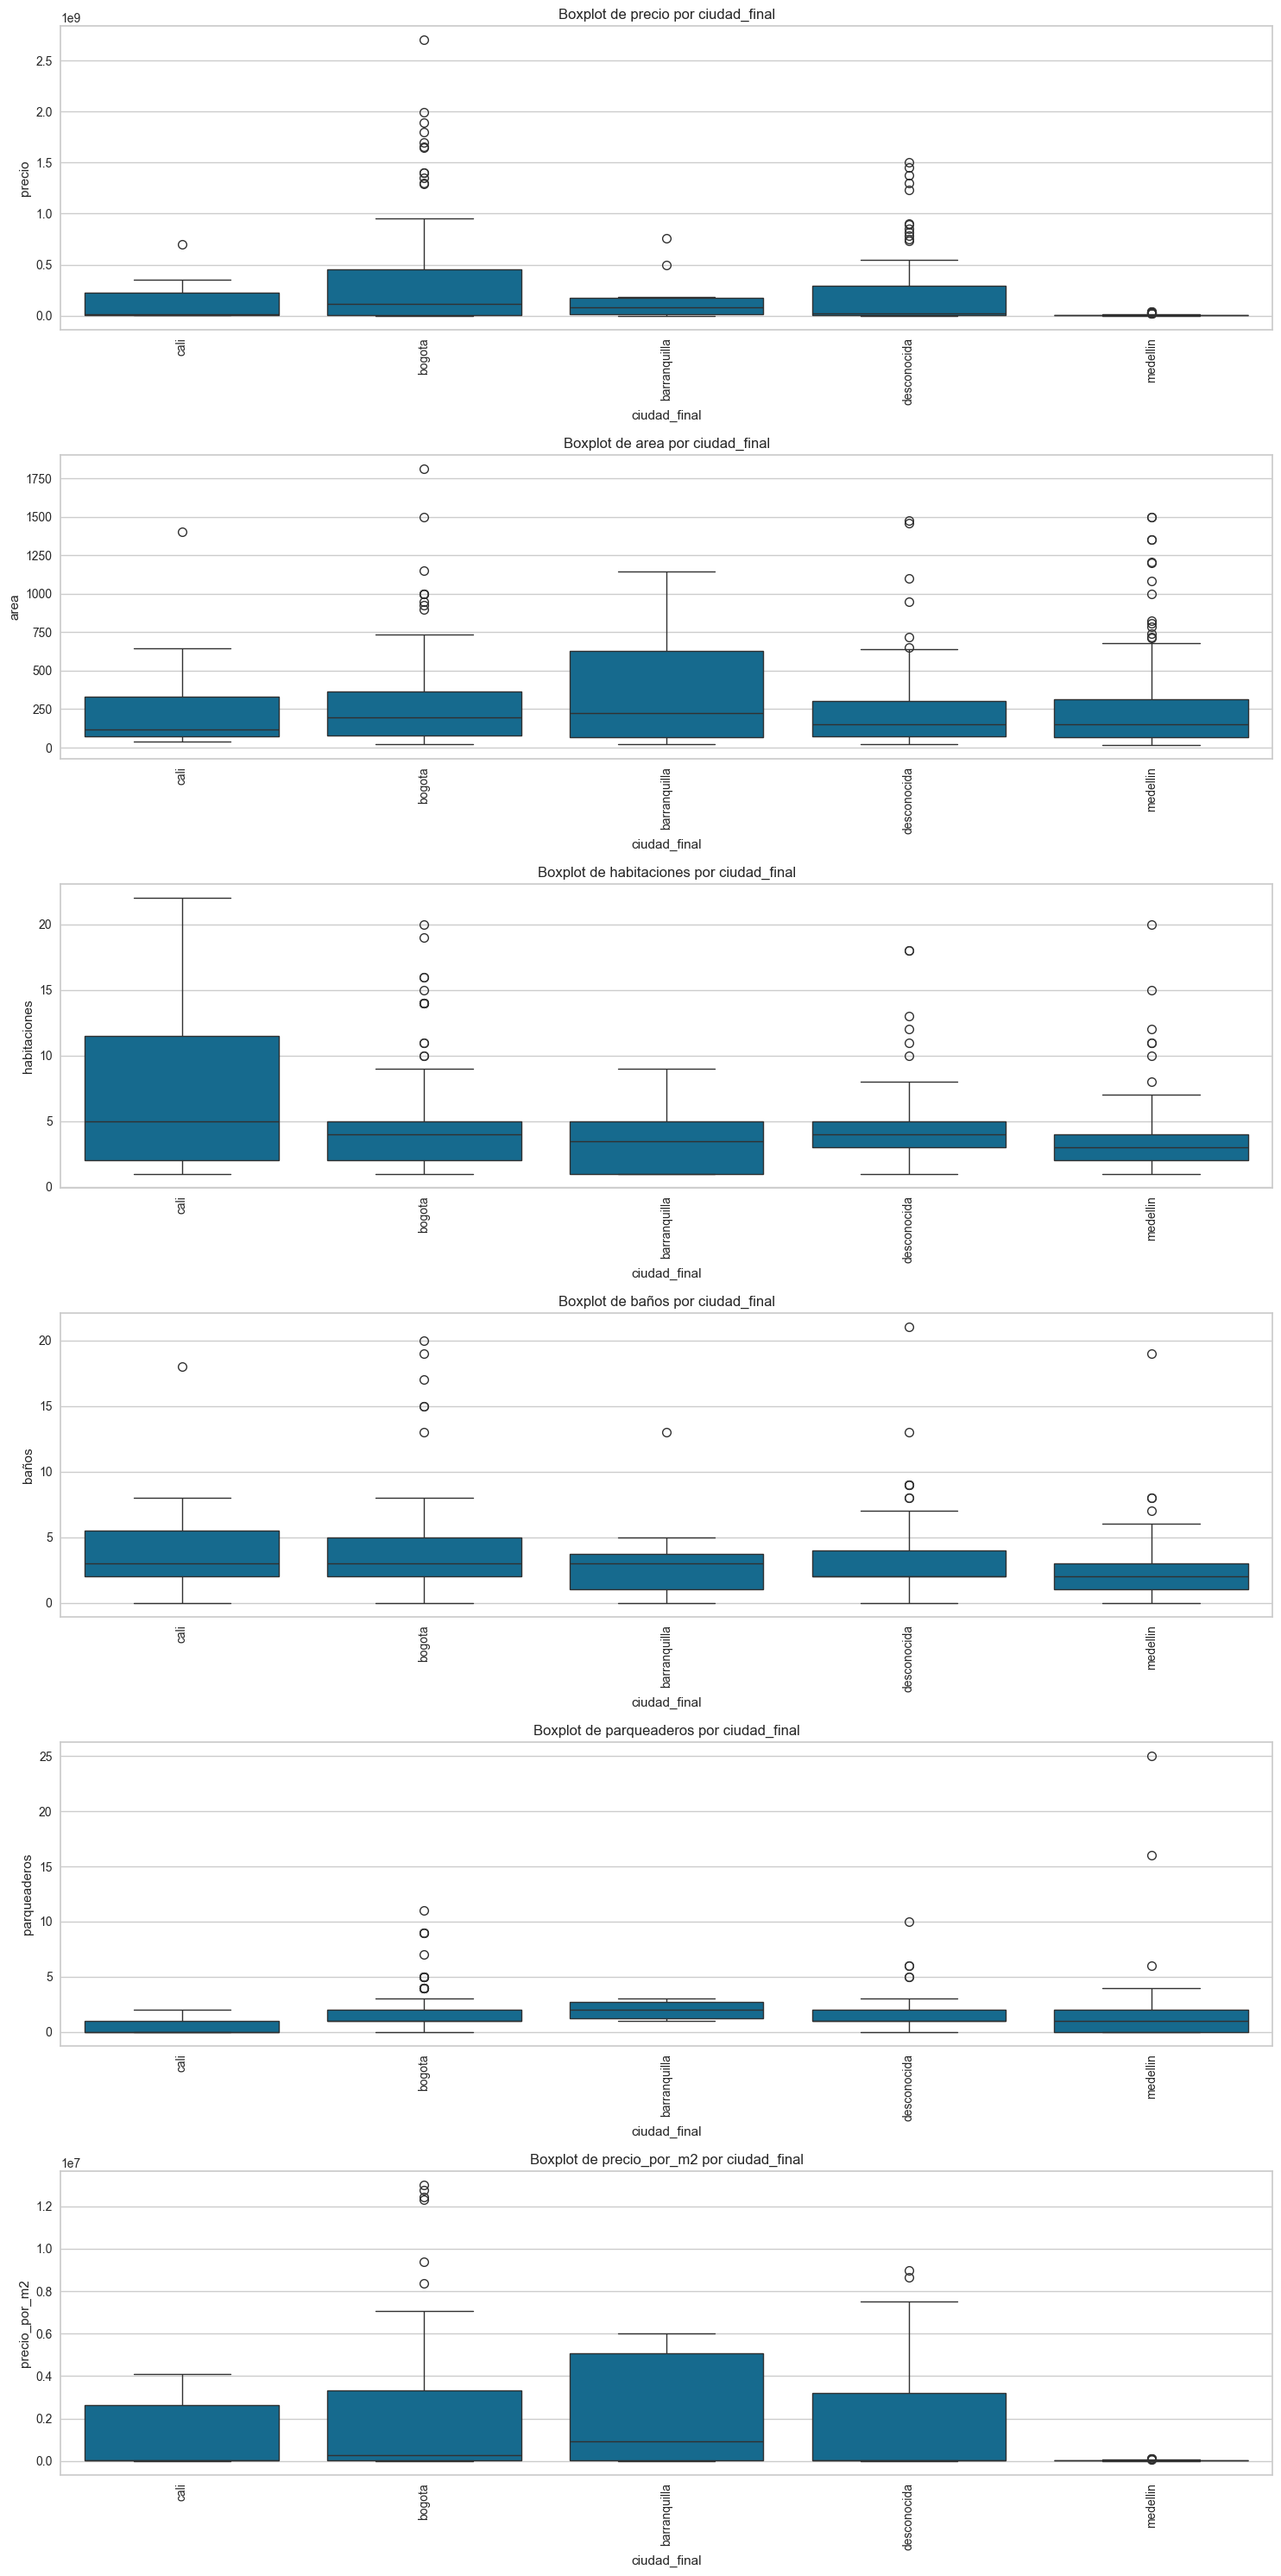

,ciudad_final,variable,n_obs,outliers_count,outliers_percentage
0,bogota,precio,157,12,7.643312
1,medellin,precio,135,15,11.111111
2,desconocida,precio,83,12,14.457831
3,cali,precio,11,1,9.090909
4,barranquilla,precio,10,2,20.000000
5,bogota,area,157,9,5.732484
6,medellin,area,135,14,10.370370
7,desconocida,area,83,6,7.228916
8,cali,area,11,1,9.090909
9,barranquilla,area,10,0,0.000000


In [399]:
cols_para_remover_outliers_ciudad = ['precio', 'habitaciones', 'baños', 'parqueaderos', 'area', 'precio_por_m2']
data_filtrada_por_ciudad, outliers_ciudad_removidos = remove_outliers_per_city_iqr(
    data_filtered, 
    city_column='ciudad_final',
    cols_to_check=cols_para_remover_outliers_ciudad,
    factor=5, # Puedes ajustar este factor. Un valor más alto es menos estricto. No hay una regla fija. con 1.5 se eliminan 28.51% de los datos
    #este % es alto, no tenemos muchos datos por lo que vamos a ser mas permisivos
    min_samples_per_city=10 # Ajusta según la cantidad de datos que tengas por ciudad
)

print("\nAlgunos de los outliers contextuales (por ciudad) que se eliminaron:")
print(outliers_ciudad_removidos.head())
# Usando tu función plot_numerical_distributions
plot_numerical_distributions(data_filtrada_por_ciudad, cols=['precio', 'area', 'habitaciones', 'baños', 'parqueaderos', 'precio_por_m2'])

# También puedes volver a graficar los boxplots por ciudad para ver la reducción de outliers
plot_and_detect_outliers_per_city(data_filtrada_por_ciudad, 
                                  ['precio', 'area', 'habitaciones', 'baños', 'parqueaderos', 'precio_por_m2'], 
                                  city_col='ciudad_final', 
                                  min_count=10) 


Por si no lo he mencionado: <br>
Las metricas con las que se calculan quienes son outliers usan terminos estadisticos por lo que si no hay suficientes datos es mejor no hacerlo, se estaria eliminando datos de los pocos que se tienen y seguramente las estadisticas no sean realistas <br>
Hay que tener en cuenta el contexto de los outliers, se recomienda analizarlos para ver si es un dato erroneo, o si estamos tratando con un dato real que sale mucho de la media <br>
Si estamos con un outlier real podemos dejarlo pero hay que tener en cuenta que este dato no es representativo, es decir no cumple con las caracteristicas de la mayoria del resto de datos <br>
Antes de eliminar un dato es necesario hacer la documentacion de que se elimino y por que, esto solo aplica si quieren conservar el trabajo 👍 <br>

# Modelamiento


Vamos a realizar un modelamiento que nos permita responder la pregunta ¿Cuál es el precio más probable de una propiedad inmobiliaria en Colombia? <br>
<br>
Aca tenemos que ser criticos con la pregunta y con nuestro alcance y hacernos preguntas sobre nuestros objetivos<br>
<br>
Vamos a modelar todo el pais?  <br>
Vamos a modelar todo los tipos de propiedad? <br>
Vamos a modelar el tipo de contrato, ej: Venta, Arriendo?  <br>

In [400]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
# TextBlob para análisis de sentimientos
from textblob import TextBlob


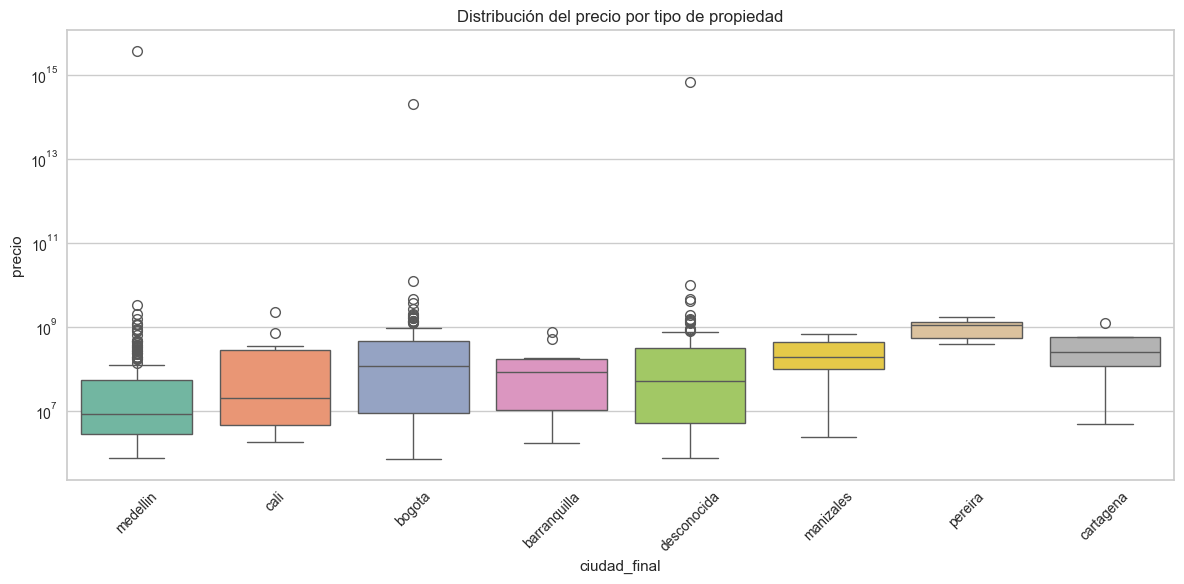

In [401]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='ciudad_final', y='precio', data=data_imputed_knn, palette='Set2')
plt.title('Distribución del precio por tipo de propiedad')
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()


**Distribuciones locales vs. globales**  
   - Cada ciudad puede tener una escala y dispersión de precios muy distinta.

**Mejor conservación de patrones**  
   - Preservas la heterogeneidad real entre zonas: los precios típicos de una comuna no “ensucian” el análisis de otra.  
   - Ayuda a mantener la señal predictiva asociada al contexto geográfico.

**Datos dentro los datos**
   - Estamos trabajando con cuidades que tienen adentro municipios, barrios, comunas, veredas, etc. Analizarlo todo junto puede hacer que el modelo "generalize"



In [402]:
df_medellin = data_imputed_knn[data_imputed_knn['ciudad_final'] == 'medellin']
df_medellin.shape

(183, 11)

In [403]:
df_medellin.columns.tolist()

['precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_final',
 'precio_por_m2']

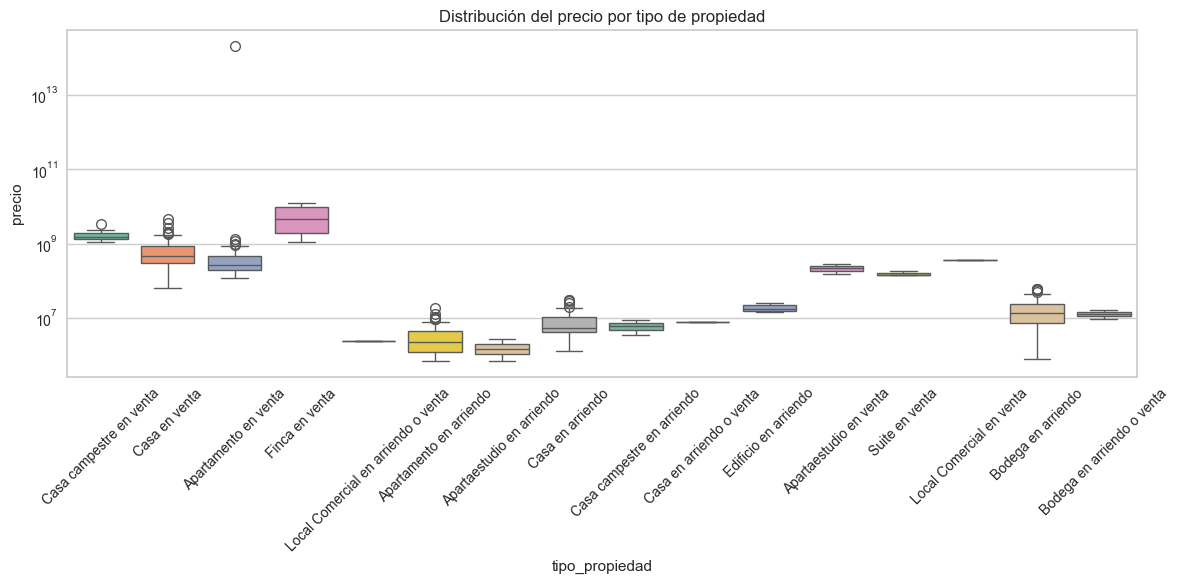

In [404]:
df_medellin['tipo_propiedad'].value_counts()
# Viendo la distribucion del precio en tipo de propiedad Apartamento en arriendo vs Apartamento en venta
plt.figure(figsize=(12, 6))
sns.boxplot(x='tipo_propiedad', y='precio', data=data_filtered, palette='Set2')
plt.title('Distribución del precio por tipo de propiedad')
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()


Se notan diferencias significativas de los precios según los tipos de propiedades, se ve como las medianas de los tipos de venta vs arriendo son muy diferentes.
<br>
Por lo que intentar modelar todos estos tipos de propiedades y transacciones con un único modelo presenta un desafío significativo. Un modelo único podría tener dificultades para capturar las distintas dinámicas de precios y la relevancia variable de las características en cada segmento. Podría resultar en predicciones imprecisas para nichos específicos o en un modelo que promedia los efectos, sin destacar en ningún segmento en particular. La escala de precios tan diferente entre venta y arriendo, por ejemplo, es un reto considerable para las métricas de error y el aprendizaje del modelo. <br>
<br>
Ahora si analizamos no solo por tipo de contrato si no por tipo de propiedad vemos que tambien hay diferenciacion y tenemos que pensar que tal vez hay analisis que se tengan que hacer diferenciados, ejemplo las caracteristicas mas importantes al buscar un local comercial, bodega y relacionados es diferente a las caracteristicas mas importantes cuando se busca una propiedad como casa, deparatamento, apartaestudio, y relacionados, que a la vez es diferente a cuando se busca una finca, suite, casa campestre, etc ...<br>
<br>
Lo recomendado seria considerar una de las siguientes estrategias (o una combinación de ellas) para abordar esta heterogeneidad y mejorar el rendimiento del modelo:<br>
<br>
Desarrollar Modelos Separados: <br>
<br>
Venta vs. Arriendo: Dada la diferencia fundamental en la escala de precios y posiblemente en los factores influyentes, crear modelos completamente separados para propiedades en venta y propiedades en arriendo es a menudo el enfoque más efectivo.
Tipo de Propiedad: Dentro de cada categoría (Venta/Arriendo), se podría considerar subdividir aún más, por ejemplo, un modelo para 'Residencial' (casas, apartamentos) y otro para 'Comercial/Industrial' (locales, bodegas), siempre que se cuente con suficientes datos para cada segmento.
Modelo Unificado con Características Específicas y Potentes:
<br>
Si se prefiere un modelo único, es absolutamente crucial que tipo_propiedad se trate como una característica de alta importancia. El uso de OneHotEncoder es esencial para estas trabajar con las categorias. <br>
Considerar la creación de caracteristicas de interacción: Por ejemplo, area * es_comercial o habitaciones * es_apartamento. Esto ayuda al modelo a entender que el efecto de una característica (como el área) puede ser diferente según el tipo de propiedad. <br>
Utilizar un modelo lo suficientemente complejo y flexible (como el StackingRegressor) que pueda capturar estas relaciones no lineales y segmentadas internamente.<br>
Enfocarse en un Nicho Específico: <br>

Si el objetivo principal es, por ejemplo, predecir el precio de 'Apartamentos en Venta en Medellín', podrías filtrar tus datos para centrarte exclusivamente en ese nicho. Esto permite construir un modelo altamente especializado y potencialmente más preciso para ese segmento particular. <br>


In [405]:
# Filter rows where 'tipo_propiedad' contains 'venta'
venta_medellin = df_medellin[df_medellin['tipo_propiedad'].str.contains('venta', case=False, na=False)]
venta_medellin['tipo_propiedad'] = venta_medellin['tipo_propiedad'].str.replace(r' en arriendo o venta| en venta', '', case=False, regex=True)
# Display the shape of the new DataFrame
print(venta_medellin.shape)

arrienda_medellin = df_medellin[df_medellin['tipo_propiedad'].str.contains('arriendo', case=False, na=False)]
arrienda_medellin['tipo_propiedad'] = arrienda_medellin['tipo_propiedad'].str.replace(r' en arriendo o venta| en arriendo', '', case=False, regex=True)

print(arrienda_medellin.shape)

arrienda_medellin.head()
print(arrienda_medellin['tipo_propiedad'].unique())

# tenemos pocos datos realmente de cada tipo de contrato

(42, 11)
(144, 11)
['Local Comercial' 'Apartamento' 'Apartaestudio' 'Casa' 'Bodega']


# Decision: 
Ya separamos la base de datos y vamos a concentrarnos en medellin para no volver a separarlo vamos a trabajar con todo Medellin independientemente del contexto pero si lo siguen separando van a encontrar mejores modelos :3

Transformar la columna `descripcion` en vectores numéricos que capturen la importancia de términos relevantes, y luego reducir la alta dimensionalidad para mejorar eficiencia y evitar ruido en el modelo.


  
- Creamos `stop_terms`, una lista de palabras muy frecuentes en anuncios inmobiliarios (baños, habitaciones, m², casa, apartamento, etc.) y que no presentan relevancia ya que hay otras columnas con la misma información 
- Combinamos con las stop words generales en español de NLTK (`stopwords.words('spanish')`).  


In [406]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
# recuerden que no se esta haciendo diferenciacion de ningun tipo por lo que las palabras que se eliminen aqui tienen que ser lo mas genericas posibles
stop_terms = [
               'm²', 'metros', 'area', "metros",
              "m2" , "mts", "mt2", "metro"] # Estas palabras aunque fueron utiles en la imputacion no son utiles para el modelo

# Combine custom stop words with NLTK's spanish stop words
nltk_stop_words = stopwords.words('spanish') 
combined_stop_words = stop_terms + nltk_stop_words

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer(
    max_features=200,  # Limit to the 200 most significant words
    min_df=10,         # Ignora términos que aparecen en menos de 10 documentos. Ayuda a eliminar palabras muy raras o errores tipográficos.
    max_df=0.7,        #  Ignora términos que aparecen en más del 70% de los documentos. Ayuda a eliminar palabras demasiado comunes que no aportan información distintiva 
    ngram_range=(1, 2),  # Consider unigrams and bigrams, ejemplo: "habitacion" , "habitacion amplia"
    stop_words=combined_stop_words
)

# Fit and transform the descriptions
descripciones_tfidf = tfidf.fit_transform(df_medellin['descripcion']) #Obtenemos una matriz dispersa (sparse) de tamaño (n_registros, n_features).



Ya que estamos haciendo un analisis global hay que ser conservadores con las palabras que se eliminan, por ejemplo si se hiciera analisis granular podriamos eliminar palabras como baños, habitaciones, parqueaderos, tipos de propiedad, etc. Esto dado a que ya tenemos una variable numerica con esta informacion <br>
Pero como estamos haciendo un analisis global esta informacion es relevante mi recomendacion es comenzar con stop words globales, o de ruido puro, que no tengan nada que ver con lo que intentamos modelar, quitar nombres propios. <br>
Un metodo de hacerlo es dejando una lista de stop words liviana, ver como queda y comenzar a iterar.


In [407]:
tfidf_df = pd.DataFrame(
    descripciones_tfidf.toarray(),
    columns=tfidf.get_feature_names_out()
) # se hace dataframe 
print(f"Número de características extraídas con TF-IDF: {len(tfidf.get_feature_names_out())}")


Número de características extraídas con TF-IDF: 195


In [408]:
# Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=42) #Reducimos a 50 componentes densos.
descripciones_svd = svd.fit_transform(descripciones_tfidf)
print(f"Número de componentes después de SVD: {descripciones_svd.shape[1]}")


Número de componentes después de SVD: 50


In [409]:
# Mostrar las 20 palabras más comunes según TF-IDF
feature_importances = np.mean(descripciones_tfidf.toarray(), axis=0)
palabras_importantes = [(palabra, importancia) 
                         for palabra, importancia in zip(tfidf.get_feature_names_out(), feature_importances)]
palabras_importantes = sorted(palabras_importantes, key=lambda x: x[1], reverse=True)[:20]
print("\nPalabras más importantes según TF-IDF:")
for palabra, importancia in palabras_importantes:
    print(f"{palabra}: {importancia:.4f}") # pueden expandir la lista para ver otras palabras y si consideran que no son relevantes pueden eliminarlas de la lista de stop words


# Imaginense este analisis si se hubiera hecho con todas las ciudades xd


Palabras más importantes según TF-IDF:
bodega: 0.0789
apartamento: 0.0636
cuenta: 0.0630
zona: 0.0581
piso: 0.0561
sector: 0.0557
casa: 0.0529
excelente: 0.0526
baños: 0.0515
arriendo: 0.0485
cocina: 0.0482
cerca: 0.0478
baño: 0.0473
acceso: 0.0460
comedor: 0.0445
sala: 0.0427
comercial: 0.0418
ubicado: 0.0414
sala comedor: 0.0413
habitaciones: 0.0385


In [410]:
# Mostrar las 20 palabras más importantes según SVD
svd_feature_importances = np.mean(descripciones_svd, axis=0)
palabras_svd_importantes = [(f"Componente {i+1}", importancia) 
                             for i, importancia in enumerate(svd_feature_importances)]
palabras_svd_importantes = sorted(palabras_svd_importantes, key=lambda x: x[1], reverse=True)[:20]
print("\nComponentes más importantes según SVD:")
for componente, importancia in palabras_svd_importantes:
    print(f"{componente}: {importancia:.4f}")  # Mostrar los componentes más importantes



Componentes más importantes según SVD:
Componente 1: 0.3470
Componente 3: 0.0271
Componente 13: 0.0073
Componente 11: 0.0061
Componente 5: 0.0050
Componente 8: 0.0039
Componente 19: 0.0036
Componente 6: 0.0032
Componente 36: 0.0029
Componente 16: 0.0026
Componente 35: 0.0025
Componente 42: 0.0025
Componente 38: 0.0023
Componente 17: 0.0021
Componente 15: 0.0020
Componente 30: 0.0020
Componente 22: 0.0020
Componente 37: 0.0019
Componente 50: 0.0018
Componente 9: 0.0018


In [411]:
df_medellin['descripcion_sentiment'] = df_medellin['descripcion'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
) # Analisis de sentimiento rapido para descripciones

El paso siguiente de crear una funcion que se encargue de hacer este proceso suele ser de los ultimos o un extra, lo que se busca es facilitar posteriormente realizar todo este proceso con nuevos datos 

In [412]:
def process_text_features(df, text_col='descripcion', tfidf_obj=None, svd_obj=None, train_mode=True, svd_n_components=50):
    """
    Procesa la columna de texto usando TF-IDF y SVD.
    En modo entrenamiento, ajusta y transforma, y devuelve los objetos entrenados.
    En modo predicción, solo transforma usando los objetos provistos.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame de entrada.
    text_col : str, default='descripcion'
        Nombre de la columna con el texto a procesar.
    tfidf_obj : TfidfVectorizer, optional
        Objeto TfidfVectorizer ya entrenado (para train_mode=False).
    svd_obj : TruncatedSVD, optional
        Objeto TruncatedSVD ya entrenado (para train_mode=False).
    train_mode : bool, default=True
        Si es True, entrena nuevos transformadores TF-IDF y SVD.
        Si es False, usa los tfidf_obj y svd_obj provistos.
    svd_n_components : int, default=50
        Número de componentes para TruncatedSVD.

    Returns:
    --------
    pd.DataFrame
        DataFrame con las características SVD.
    TfidfVectorizer (si train_mode=True)
        El objeto TfidfVectorizer entrenado.
    TruncatedSVD (si train_mode=True)
        El objeto TruncatedSVD entrenado.
    """
    
    # Asegurarse de que la columna de texto exista y manejar NaNs
    if text_col not in df.columns:
        raise ValueError(f"La columna '{text_col}' no se encuentra en el DataFrame.")
    
    text_series = df[text_col].fillna("") # Rellenar NaNs con string vacío
    # Solo va a ser usado si train_mode es True

    '''
    el vectorizador "aprende" las características de tus datos de texto, del dataframe completo y con el que se trabajo
    para cuando se entrene el modelo, se pueda usar el mismo vectorizador para transformar los datos de test o nuevos datos
    y el SVD reduce la dimensionalidad de la matriz TF-IDF resultante, manteniendo las características más importantes.
    Esto es útil para evitar el sobreajuste y mejorar la eficiencia del modelo.
    '''

    if train_mode:
        print(f"Modo Entrenamiento: Ajustando y transformando '{text_col}' con TF-IDF y SVD...")
        
        # Inicializar y entrenar TfidfVectorizer
        # Usamos 'combined_stop_words' que se definió globalmente
        tfidf_obj = TfidfVectorizer(
            max_features=200,
            min_df=10,
            max_df=0.7,
            ngram_range=(1, 2),
            stop_words=combined_stop_words 
        )
        tfidf_matrix = tfidf_obj.fit_transform(text_series)
        print(f"TF-IDF: {tfidf_matrix.shape[1]} características extraídas.")

        # Inicializar y entrenar TruncatedSVD
        # Asegurar que n_components no sea mayor que las características de TF-IDF
        n_components_actual = min(svd_n_components, tfidf_matrix.shape[1] -1)
        if n_components_actual < 1 :
            n_components_actual = 1 # Al menos 1 componente si tfidf_matrix.shape[1] es 1 o 0
            print(f"Advertencia: Número de características TF-IDF ({tfidf_matrix.shape[1]}) es muy bajo. SVD se ajustará a {n_components_actual} componente(s).")
        
        svd_obj = TruncatedSVD(n_components=n_components_actual, random_state=42)
        svd_matrix = svd_obj.fit_transform(tfidf_matrix)
        print(f"SVD: Reducido a {svd_matrix.shape[1]} componentes. Varianza explicada: {svd_obj.explained_variance_ratio_.sum():.2%}")
    # Si ya tenemos un modelo y estamos en modo predicción
    else: # Modo Predicción
        print(f"Modo Predicción: Aplicando transformadores existentes a '{text_col}'...")
        if not tfidf_obj or not svd_obj:
            raise ValueError("Para train_mode=False, se deben proveer 'tfidf_obj' y 'svd_obj'.")
        
        tfidf_matrix = tfidf_obj.transform(text_series)
        svd_matrix = svd_obj.transform(tfidf_matrix)

    # Crear DataFrame con las características SVD
    svd_cols = [f'{text_col[:3]}_svd_{i}' for i in range(svd_matrix.shape[1])] # Prefijo corto del nombre de la columna
    svd_df = pd.DataFrame(svd_matrix, columns=svd_cols, index=df.index)
    
    if train_mode:
        return svd_df, tfidf_obj, svd_obj
    else:
        return svd_df

In [413]:
desc_svd_df, tfidf_entrenado, svd_entrenado = process_text_features(
    df_medellin, 
    text_col='descripcion', 
    train_mode=True  
)
#desc_svd_df es un dataFrame contiene las características numéricas resultantes de procesar el texto de la columna descripcion.
#los otros dos son los objetos entrenados de TfidfVectorizer y TruncatedSVD que se pueden usar para transformar nuevos datos de texto en el futuro.

Modo Entrenamiento: Ajustando y transformando 'descripcion' con TF-IDF y SVD...
TF-IDF: 195 características extraídas.
SVD: Reducido a 50 componentes. Varianza explicada: 81.28%


In [414]:
#feature engineering
df_medellin['room_density'] = df_medellin['habitaciones'] / df_medellin['area']
df_medellin['bathroom_density'] = df_medellin['baños'] / df_medellin['area']
df_medellin['longitud_descripcion'] = df_medellin['descripcion'].apply(
    lambda x: len(str(x)) if isinstance(x, str) else 0
)
corr_longitud_precio = df_medellin[['longitud_descripcion', 'precio']].corr().iloc[0,1]
print(f"\nCorrelación entre longitud de descripción y precio: {corr_longitud_precio:.4f}")


Correlación entre longitud de descripción y precio: -0.1011


In [415]:
def create_features(df):
    """
    Creates engineered features for real estate price prediction.
    
    Parameters:
    df (DataFrame): Input dataframe with real estate data
    
    Returns:
    DataFrame: Dataframe with new engineered features
    """
    df_copy = df.copy()
    
    # Property density metrics
    df_copy['room_density'] = df_copy['habitaciones'] / df_copy['area']
    df_copy['bathroom_density'] = df_copy['baños'] / df_copy['area']
    
    # Property efficiency metrics
    df_copy['rooms_per_bathroom'] = df_copy['habitaciones'] / (df_copy['baños'] + 1)  # +1 to avoid division by zero
    df_copy['parking_per_room'] = df_copy['parqueaderos'] / (df_copy['habitaciones'] + 1)
    
    # Description features
    df_copy['longitud_descripcion'] = df_copy['descripcion'].apply(
        lambda x: len(str(x)) if isinstance(x, str) else 0
    )
    df_copy['descripcion_sentiment'] = df_copy['descripcion'].apply(
        lambda x: TextBlob(str(x)).sentiment.polarity
    )
    
    # Property luxury indicators
    df_copy['has_parking'] = (df_copy['parqueaderos'] > 0).astype(int)
    df_copy['multiple_bathrooms'] = (df_copy['baños'] > 1).astype(int)
    
    # Property type indicators
    df_copy['is_house'] = df_copy['tipo_propiedad'].str.contains('casa', case=False, na=False).astype(int)
    df_copy['is_apartment'] = df_copy['tipo_propiedad'].str.contains('apartamento|apto', case=False, na=False).astype(int)
    df_copy['is_studio'] = df_copy['tipo_propiedad'].str.contains('estudio', case=False, na=False).astype(int)
    
    # Area categories
    df_copy['area_category'] = pd.cut(df_copy['area'], 
                                     bins=[0, 50, 100, 200, float('inf')], 
                                     labels=['small', 'medium', 'large', 'extra_large'])
    
    # Price-based features (only if precio column exists and we're not predicting it)
    if 'precio' in df_copy.columns:
        df_copy['precio_per_room'] = df_copy['precio'] / (df_copy['habitaciones'] + 1)
        df_copy['precio_por_m2'] = df_copy['precio'] / df_copy['area']
    
    return df_copy

# Apply feature engineering to the dataframe
df_medellin = create_features(df_medellin) # estoy haciendo todo sobre un mismo dataframe lo cual es una mala practica pero no quiero crear un nuevo dataframe por cada proceso

print("Feature engineering completed. New features created:")
new_features = ['room_density', 'bathroom_density', 'rooms_per_bathroom', 
               'parking_per_room', 'longitud_descripcion', 'descripcion_sentiment',
               'has_parking', 'multiple_bathrooms', 'is_house', 
               'is_apartment', 'is_studio', 'area_category']

if 'precio' in df_medellin.columns:
    new_features.extend(['precio_per_room', 'precio_por_m2'])

for feature in new_features:
    print(f"- {feature}")

print(f"\nDataframe shape after feature engineering: {df_medellin.shape}")

Feature engineering completed. New features created:
- room_density
- bathroom_density
- rooms_per_bathroom
- parking_per_room
- longitud_descripcion
- descripcion_sentiment
- has_parking
- multiple_bathrooms
- is_house
- is_apartment
- is_studio
- area_category
- precio_per_room
- precio_por_m2

Dataframe shape after feature engineering: (183, 24)


In [416]:
df_medellin.columns.tolist()

['precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_final',
 'precio_por_m2',
 'descripcion_sentiment',
 'room_density',
 'bathroom_density',
 'longitud_descripcion',
 'rooms_per_bathroom',
 'parking_per_room',
 'has_parking',
 'multiple_bathrooms',
 'is_house',
 'is_apartment',
 'is_studio',
 'area_category',
 'precio_per_room']

## Intentando reducir dimensionalidad

In [417]:
#print(data_filtered['ubicacion'].unique())
df_medellin['georeferencia'].value_counts()

georeferencia
san antonio prado    17
rionegro             12
poblado              12
centro                9
medellin              5
                     ..
primavera             1
canaveralejo          1
loma brujas           1
trianon               1
villa olimpica        1
Name: count, Length: 113, dtype: int64

In [418]:
df_medellin['ubicacion'].value_counts()

ubicacion
centro, rionegro, santa ana                             7
la candelaria, los conquistadores, villanueva           6
entre amigos, sabaneta, vegas de la doctora             4
la candelaria, medellin, boston                         4
castropol, el tesoro, alejandria                        4
                                                       ..
rionegro, ub lotus et i, gualanday                      1
calasanz, los colores, calasanz parte alta              1
rionegro, gualanday, santa ana                          1
entre amigos, vegas de la doctora, vegas de san jose    1
los alpes, los angeles, sector plaza de bolivar         1
Name: count, Length: 131, dtype: int64

113 Georeferencias y 131 ubicaciones, si le pasamos esto a un encoder vamos a tener una dimensionalidad considerable, y como estamos trabajando con todo lo de medellin, vamos a realizar nuevamente diccionarios para intentar reducirlo

In [419]:
zona_dict_mejorado = {
    # Zona 1: Nororiental (Comunas 1–4)
    'Nororiental': [
        'popular', 'santo domingo', 'santa cruz', 'manrique', 'aranjuez', 
        'jardín botánico', 'universidad de antioquia', 'campo valdés', 'moravia',
        'playón', 'villa del socorro', 'granizal', 'moscú', 'villa guadalupe',
        'san pablo', 'la salle', 'brasilia', 'la rosa', 'berlín', 'carpinelo',
        'san isidro', 'palermo', 'miranda', 'la frontera', 'la francia', 'andalucía',
        'villa niza', 'la isla', 'el raizal', 'el pomar', 'versalles', 'jardines', 
        'comuna 1', 'comuna 2', 'comuna 3', 'comuna 4'
    ],

    # Zona 2: Noroccidental (Comunas 5–7)
    'Noroccidental': [
        'castilla', 'robledo', 'doce de octubre', 'pedregal', 'la esperanza',
        'san martín de porres', 'alfonso lópez', 'boyacá', 'florencia', 'tejelo',
        'belalcázar', 'girardot', 'tricentenario', 'héctor abad', 'kennedy',
        'picacho', 'picachito', 'mirador', 'aures', 'cuatro esquinas', 'cerro volador',
        'bello horizonte', 'córdoba', 'lópez de mesa', 'altamira', 'Francisco Antonio Zea',
        'plaza de ferias', 'nuevo pascual bravo', 'comuna 5', 'comuna 6', 'comuna 7'
    ],

    # Zona 3: Centrooccidental (Comunas 11–13)
    'Centrooccidental': [
        'la américa', 'san javier', 'laureles', 'estadio', 'floresta', 'santa lucía',
        'los colores', 'carlos e. restrepo', 'suramericana', 'simón bolívar', 'calasanz',
        'santa teresita', 'conquistadores', 'naranjal', 'florida nueva', 'cristóbal',
        'belencito', 'antonio nariño', 'el corazón', 'veinte de julio', 'blanquizal',
        'las independencias', 'nuevos conquistadores', 'el salado', 'betania', 'cuarta brigada',
        'san joaquín', 'la castellana', 'lorena', 'bolivariana', 'comuna 11', 'comuna 12', 'comuna 13'
    ],

    # Zona 4: Centroriental (Comunas 8–10)
    'Centroriental': [
        'villa hermosa', 'buenos aires', 'candelaria', 'prado', 'boston', 'centro',
        'villanueva', 'la ladera', 'san miguel', 'la mansión', 'batallón', 'sucre',
        'los ángeles', 'bomboná', 'el chagualo', 'la candelaria', 'san benito', 'guayaquil',
        'corazón de jesús', 'estación villa', 'san diego', 'perpetuo socorro', 'colón',
        'enciso', 'llanaditas', 'la libertad', 'villatina', 'caicedo', 'la toma',
        'el salvador', 'gerona', 'las palmas', 'comuna 8', 'comuna 9', 'comuna 10', 'palmas'
    ],

    # Zona 5: Suroriental (Comuna 14)
    'Suroriental': [
        'el poblado', 'milla de oro', 'loma de los balsos', 'tesoro', 'castropol',
        'lalinde', 'las lomas', 'altos del poblado', 'patio bonito', 'manila',
        'astorga', 'provenza', 'villa carlota', 'santa maría de los ángeles', 
        'parque lleras', 'alejandría', 'la aguacatala', 'los naranjos', 'el diamante',
        'san lucas', 'la florida', 'el castillo', 'vizcaya', 'santa fe', 'las vegas',
        'los balsos', 'la calera', 'el poblado de oro', 'palmitas', 'los gonzalez',
        'zona rosa', 'la frontera', 'oviedo', 'santafe', 'ciudad del río', 'comuna 14', 'poblado', 'sabaneta', 'envigado', 'naranjos', 'naranjitos'
    ],

    # Zona 6: Suroccidental (Comunas 15–16)
    'Suroccidental': [
        'guayabal', 'belen', 'conquistadores', 'rosales', 'la mota', 'diego echavarría',
        'las mercedes', 'fatima', 'nutibara', 'la gloria', 'aliadas', 'santa fe',
        'san bernardo', 'la palma', 'los alpes', 'la hondonada', 'altavista', 'trinidad',
        'campo amor', 'cristo rey', 'la colinita', 'mallorca', 'los almendros', 'el rodeo',
        'parque juan pablo', 'la nubia', 'el rincón', 'granada', 'zafra', 'villa café',
        'miravalle', 'comuna 15', 'comuna 16', 'itagui', 'ditaires'
    ],
    
    # Corregimientos (áreas rurales de Medellín)
    'Corregimientos': [
        'san antonio de prado', 'san cristóbal', 'altavista', 'san sebastián de palmitas',
        'santa elena', 'corregimiento', 'rural', 'rio negro' , 'rionegro'
    ]
}

In [420]:
def asignar_zona_mejorada(ubicacion_raw, georeferencia_raw, zona_dict):
    """
    Asigna una zona basada en la fusión de 'ubicacion_raw' y 'georeferencia_raw',
    usando un enfoque robusto de normalización y búsqueda de keywords.
    """
    # Si ambos campos están vacíos o NaN
    if pd.isna(ubicacion_raw) and pd.isna(georeferencia_raw):
        return 'Sin ubicación'
    
    # Construir un único texto concatenado
    texto = f"{ubicacion_raw or ''} {georeferencia_raw or ''}"
    texto = texto.lower()
    
    # Eliminar acentos y caracteres especiales
    texto = unicodedata.normalize('NFKD', texto)\
                       .encode('ASCII', 'ignore')\
                       .decode('utf-8')
    texto = re.sub(r'[^\w\s]', ' ', texto)  # Reemplazar símbolos con espacios
    
    # 1) Buscar coincidencias exactas o con sufijos
    for zona, keywords in zona_dict.items():
        for kw in keywords:
            kw_norm = unicodedata.normalize('NFKD', kw)\
                                  .encode('ASCII', 'ignore')\
                                  .decode('utf-8')
            pattern = rf"\b{re.escape(kw_norm)}\b|\b{re.escape(kw_norm)}[a-z]+"
            if re.search(pattern, texto):
                return zona
    
    # 2) Si no halló nada, buscar coincidencias parciales
    for zona, keywords in zona_dict.items():
        for kw in keywords:
            if kw.lower() in texto:
                return zona
    
    return 'Otra'


# Función para analizar los resultados de la clasificación
def analizar_clasificacion_zonas(df, col_ubicacion, col_zona):
    """
    Analiza los resultados de la clasificación de zonas y muestra ejemplos
    de ubicaciones clasificadas en cada zona y de ubicaciones no clasificadas.
    """
    resultados = {
        'total': len(df),
        'clasificados': (df[col_zona] != 'Otra').sum(),
        'no_clasificados': (df[col_zona] == 'Otra').sum(),
        'distribucion': df[col_zona].value_counts(),
        'porcentaje_clasificado': (df[col_zona] != 'Otra').mean() * 100
    }
    
    print(f"Total de registros: {resultados['total']}")
    print(f"Registros clasificados: {resultados['clasificados']} ({resultados['porcentaje_clasificado']:.2f}%)")
    print(f"Registros no clasificados: {resultados['no_clasificados']}")
    print("\nDistribución por zonas:")
    print(resultados['distribucion'])
    
    # Mostrar ejemplos de cada zona
    print("\nEjemplos de ubicaciones por zona:")
    for zona in df[col_zona].unique():
        if zona != 'Otra':
            muestra = df[df[col_zona] == zona][col_ubicacion].sample(min(3, df[df[col_zona] == zona].shape[0]))
            print(f"\n{zona}:")
            for ubicacion in muestra:
                print(f"- {ubicacion}")
    
    # Mostrar ejemplos de no clasificados
    if resultados['no_clasificados'] > 0:
        print("\nEjemplos de ubicaciones no clasificadas ('Otra'):")
        muestra_no_clasificados = df[df[col_zona] == 'Otra'][col_ubicacion].sample(min(10, resultados['no_clasificados']))
        for ubicacion in muestra_no_clasificados:
            print(f"- {ubicacion}")
    
    return resultados

In [421]:
df_medellin['zona'] = df_medellin.apply(
    lambda fila: asignar_zona_mejorada(
        fila['ubicacion'],
        fila['georeferencia'],
        zona_dict_mejorado
    ),
    axis=1
)
resultados = analizar_clasificacion_zonas(df_medellin, 'ubicacion', 'zona')

Total de registros: 183
Registros clasificados: 173 (94.54%)
Registros no clasificados: 10

Distribución por zonas:
zona
Centroriental       76
Centrooccidental    36
Suroriental         35
Corregimientos      12
Otra                10
Nororiental          6
Suroccidental        4
Noroccidental        4
Name: count, dtype: int64

Ejemplos de ubicaciones por zona:

Centroriental:
- miraflores , centro , las quintas
- ditaires, santa catalina, la ferreria
- la ferreria, san antonio de prado, ditaires

Corregimientos:
- rionegro, guarne, barrio obrero
- el porvenir, san antonio, rionegro
- rionegro, ub lotus et i, el porvenir

Suroriental:
- el tesoro, los balsos no.1, la florida
- alejandria, el poblado, patio bonito
- entre amigos, sabaneta, tres esquinas

Centrooccidental:
- castropol, simesa, los conquistadores
- nazareth, medellin, fatima
- entre amigos, sabaneta, vegas de la doctora

Suroccidental:
- bosques de zuniga, el portal, itagui
- ditaires, santa catalina, ancon san martin
-

In [422]:
df_medellin[df_medellin['zona'] == 'Otra']['ubicacion'].unique()

array(['soacha, san luis, ub. terreros',
       'la cabanita, zona industrial no. 1, la cabana',
       'ciudadela del norte, a.s.d., la navarra',
       'villa del rio, madelena iii y iv, venecia',
       'entre amigos, vegas de la doctora, vegas de san jose',
       'conjunto residencial villa campestre, br villa estrella, cr. coralina',
       'el corzo, parcela el porvenir, cr torres el progreso et. i',
       'bosconia, a.s.d., predio caldas',
       'mt cerro campestre alto, vereda samaria',
       'bodega industrial en dorado area de 1.950 metros construccion total, area libre de bodega a triple altura de 1.704 metros, mas oficinas de 200 metros, mas zona de parqueo privado 170 metros, capacitad d energia de 35 kwa, bodega con tres entradas pisos de alta resistencia,'],
      dtype=object)

Yo esos datos los veo muy raros, yo los eliminaria pero como tenemos pocos datos y en la vida real si se eliminan datos toca documentarlos y que pereza asi que los voy a dejar


In [423]:
# Checking if there are negative values on any of the columns
for col in num_cols:
    if (df_medellin[col] < 0).any():
        print(f"Negative values found in {col}")
    else:
        print(f"No negative values in {col}")

No negative values in habitaciones
No negative values in baños
No negative values in parqueaderos
No negative values in area


In [424]:
# Checking for NAs
for col in df_medellin.columns:
    if df_medellin[col].isna().sum() > 0:
        print(f"NAs found in {col}")
    else:
        print(f"No NAs in {col}")

No NAs in precio
No NAs in ubicacion
No NAs in habitaciones
No NAs in baños
No NAs in parqueaderos
No NAs in area
No NAs in descripcion
No NAs in tipo_propiedad
No NAs in georeferencia
No NAs in ciudad_final
No NAs in precio_por_m2
No NAs in descripcion_sentiment
No NAs in room_density
No NAs in bathroom_density
No NAs in longitud_descripcion
No NAs in rooms_per_bathroom
No NAs in parking_per_room
No NAs in has_parking
No NAs in multiple_bathrooms
No NAs in is_house
No NAs in is_apartment
No NAs in is_studio
No NAs in area_category
No NAs in precio_per_room
No NAs in zona


In [425]:
df_medellin.columns.tolist()

['precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_final',
 'precio_por_m2',
 'descripcion_sentiment',
 'room_density',
 'bathroom_density',
 'longitud_descripcion',
 'rooms_per_bathroom',
 'parking_per_room',
 'has_parking',
 'multiple_bathrooms',
 'is_house',
 'is_apartment',
 'is_studio',
 'area_category',
 'precio_per_room',
 'zona']

In [438]:
def build_model(X_train, y_train, numeric_cols, categorical_cols):
    """
    Construye y entrena el pipeline final del modelo.
    Asume que X_train ya tiene todas las características 
    (numéricas, categóricas y SVD). Las columnas SVD (o cualquier otra
    no especificada) pasarán sin cambios gracias a remainder='passthrough'.

    Parameters:
    -----------
    X_train : pd.DataFrame
        DataFrame de entrenamiento con todas las características.
    y_train : pd.Series
        Serie de entrenamiento con el target (log-transformado).
    numeric_cols : list
        Lista de nombres de columnas numéricas a procesar.
    categorical_cols : list
        Lista de nombres de columnas categóricas a procesar.

    Returns:
    --------
    sklearn.pipeline.Pipeline
        El pipeline completo, entrenado.
    """
    print("--- Construyendo y Entrenando Pipeline Final ---")

    # 1. Definir el Preprocesador Final
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', RobustScaler()), 
                ('power', PowerTransformer(method='yeo-johnson')) # Transformación Yeo-Johnson para normalizar
            ]), numeric_cols), 
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols) # Codificación One-Hot para variables categóricas
        ],
        remainder='passthrough' # !Ojito Cualquier columna en X_train que no esté listada ni en numeric_cols ni en categorical_cols pasará sin cambios. IMPORTANTE
    )

    # 2. Definir el Modelo (StackingRegressor) Se busca crear un modelo de ensamble potente que combine las predicciones de varios modelos más simples para obtener un rendimiento potencialmente mejor.
    base_models = [  
        ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)),
        ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)),
        ('lgbm', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)),
        ('ridge', Ridge(alpha=1.0, random_state=42))
    ] # Se podrian hacer grids de hiperparámetros para cada modelo base si se desea
    #Es un modelo que se entrena con las predicciones de los modelos base.
    meta_model = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42) 
    
    stacking_model = StackingRegressor(
        estimators=base_models, # Lista de modelos base
        final_estimator=meta_model, # Meta-modelo que se entrenará con las predicciones de los modelos base
        cv=5,      # Validación cruzada interna para entrenar el meta-modelo
        n_jobs=-1  # Usa todos los procesadores
    ) # Por si se preguntan si se puede hacer grid search de hiperparámetros en el StackingRegressor, la respuesta es sí, pero puede ser costoso computacionalmente. 

    # 3. Crear el Pipeline Completo
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('stacking_regressor', stacking_model)
    ])

    # 4. Entrenar el Pipeline
    print("Entrenando modelo final...")
    model_pipeline.fit(X_train, y_train)
    print("Entrenamiento completado. ")
    return model_pipeline


In [427]:
'''
['precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_final',
 'precio_por_m2',
 'descripcion_sentiment',
 'room_density',
 'bathroom_density',
 'longitud_descripcion',
 'zona',
 'rooms_per_bathroom',
 'parking_per_room',
 'has_parking',
 'multiple_bathrooms',
 'is_house',
 'is_apartment',
 'is_studio',
 'area_category',
 'precio_per_room']
'''

# Asegúrate de crear desc_svd_df primero:
svd_cols = [f'des_svd_{i}' for i in range(descripciones_svd.shape[1])]
desc_svd_df = pd.DataFrame(descripciones_svd, columns=svd_cols, index=df_medellin.index)

# Define tus columnas FINALES
numeric_cols = [ 'habitaciones', 'baños', 'parqueaderos', 'area', 'room_density', 
                 'bathroom_density', 'rooms_per_bathroom', 'parking_per_room', 
                 'longitud_descripcion', 'descripcion_sentiment', 'has_parking', 
                 'multiple_bathrooms' ]
                 
categorical_cols = [ 'tipo_propiedad', 'zona', 'is_house', 'is_apartment', 
                     'is_studio', 'area_category' ]

# Crear 'precio_log' si no existe
if 'precio_log' not in df_medellin.columns:
    df_medellin['precio_log'] = np.log1p(df_medellin['precio'])

# 2. Ahora sí, crea X e y
X = df_medellin[numeric_cols + categorical_cols].join(desc_svd_df)
y = df_medellin['precio_log']

# 3. Divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entrena
trained_pipeline = build_model(X_train, y_train, numeric_cols, categorical_cols)

--- Construyendo y Entrenando Pipeline Final ---
Entrenando modelo final...
Entrenamiento completado. 


In [439]:
joblib.dump(trained_pipeline, 'modelo_entrenado_medellin.pkl')
joblib.dump(tfidf_entrenado, 'mi_tfidf.pkl') # El de process_text_features
joblib.dump(svd_entrenado, 'mi_svd.pkl')     # El de process_text_features
joblib.dump(zona_dict_mejorado, 'zona_dict_mejorado.pkl')

columnas_guardadas = {
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'svd_cols': list(desc_svd_df.columns) 
}
joblib.dump(columnas_guardadas, 'modelo_columnas.pkl')

print("¡Entrenamiento y guardado completo!")

¡Entrenamiento y guardado completo!



--- Evaluando Modelo en Set de Prueba ---
Resultados del Set de Prueba (escala de precio original):
MAE: $46,936,039 COP
RMSE: $161,563,687 COP
R²: 0.3684
MAPE: 0.53%


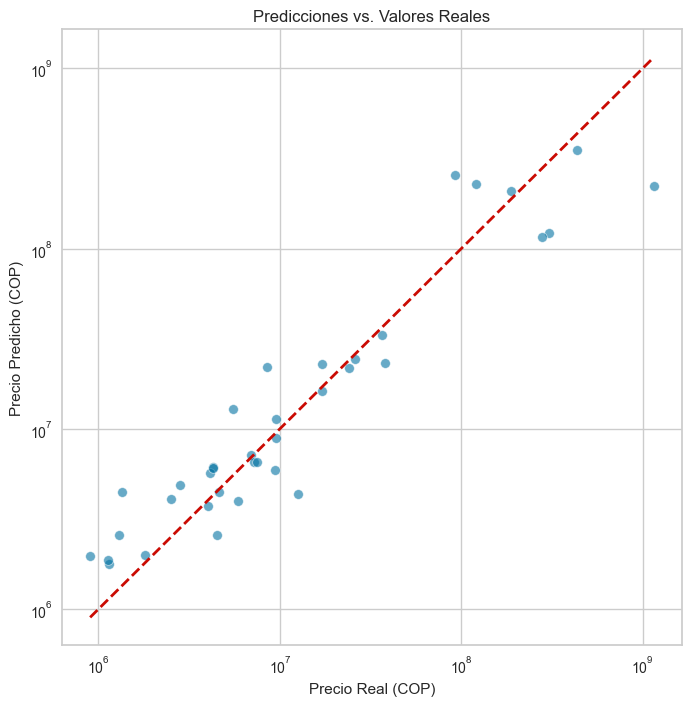

In [440]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


print("\n--- Evaluando Modelo en Set de Prueba ---")

# a) Predecir en X_test (obtendrás precios en escala logarítmica)
y_pred_log = trained_pipeline.predict(X_test)

# b) Revertir y_test y y_pred_log a la escala de precios original
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)

# c) Calcular métricas en la escala original (¡más interpretable!)
mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2_orig = r2_score(y_test_orig, y_pred_orig)
mape_orig = mean_absolute_percentage_error(y_test_orig, y_pred_orig)

print(f"Resultados del Set de Prueba (escala de precio original):")
print(f"MAE: ${mae_orig:,.0f} COP")  # Error Absoluto Medio
print(f"RMSE: ${rmse_orig:,.0f} COP") # Raíz del Error Cuadrático Medio
print(f"R²: {r2_orig:.4f}")         # Coeficiente de Determinación
print(f"MAPE: {mape_orig:.2f}%")       # Error Porcentual Absoluto Medio

# d) (Opcional) Visualizar predicciones vs. valores reales
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_orig, y=y_pred_orig, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Precio Real (COP)')
plt.ylabel('Precio Predicho (COP)')
plt.xscale('log') # Usar escala log puede ayudar a visualizar mejor
plt.yscale('log')
plt.grid(True)
plt.show()

Un modelo feo xd <br>
del R² aproximadamente el 36.84% de la variabilidad en los precios de los inmuebles puede ser explicada por tu modelo. <br>
Un MAPE del 53.19% es alto e indica que las predicciones pueden desviarse significativamente (más de la mitad del valor real, en promedio) del precio verdadero.

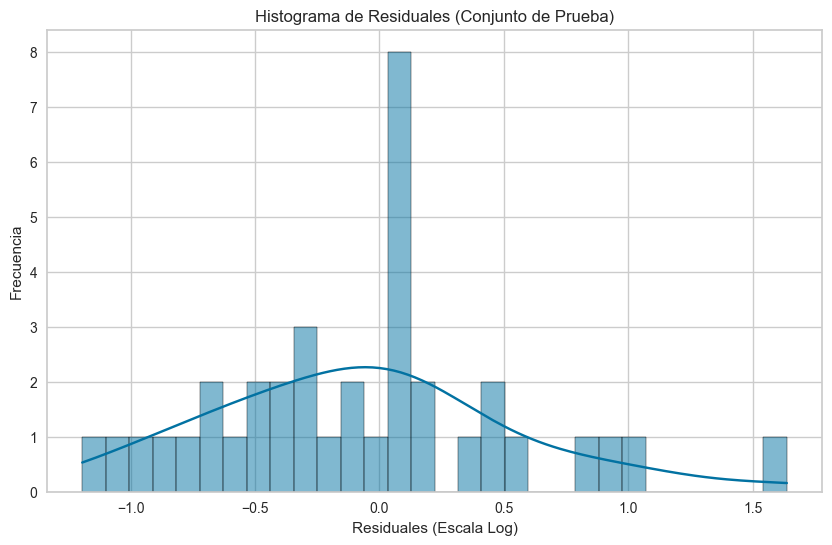

In [441]:
y_pred_log_test = trained_pipeline.predict(X_test)
residuals_test = y_test - y_pred_log_test

plt.figure(figsize=(10, 6))
sns.histplot(residuals_test, kde=True, bins=30) # kde=True añade una estimación de la densidad
plt.title('Histograma de Residuales (Conjunto de Prueba)')
plt.xlabel('Residuales (Escala Log)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [442]:
# Test shapiro
from scipy.stats import shapiro
shapiro_test = shapiro(residuals_test)
print(f"Shapiro-Wilk Test: Estadístico={shapiro_test.statistic:.4f}, p-valor={shapiro_test.pvalue:.4f}")
if shapiro_test.pvalue < 0.05:
    print("Los residuales no siguen una distribución normal (p-valor < 0.05).")
else:
    print("Los residuales siguen una distribución normal (p-valor >= 0.05).")

Shapiro-Wilk Test: Estadístico=0.9722, p-valor=0.4715
Los residuales siguen una distribución normal (p-valor >= 0.05).


In [ ]:
def predict_new_properties(new_data):
    """
    Carga el modelo y los transformadores guardados para predecir precios
    de nuevos inmuebles.

    Parameters:
    -----------
    new_data : list of dict or pandas DataFrame
        Los datos de los nuevos inmuebles. Deben contener las columnas
        originales usadas en el entrenamiento (area, habitaciones, etc.).

    Returns:
    --------
    numpy array
        Un array con los precios predichos.
    """
    print("--- Iniciando Predicción para Nuevos Inmuebles ---")

    try:
        # 1. Cargar objetos guardados
        pipeline = joblib.load('modelo_entrenado_medellin.pkl')
        tfidf = joblib.load('mi_tfidf.pkl')
        svd = joblib.load('mi_svd.pkl')
        zona_dict = joblib.load('zona_dict_mejorado.pkl')
        columnas = joblib.load('modelo_columnas.pkl')
        numeric_cols = columnas['numeric_cols']
        categorical_cols = columnas['categorical_cols']
        svd_cols_names = columnas['svd_cols']
        print("Modelos y transformadores cargados.")

        # 2. Convertir a DataFrame (si es necesario)
        if isinstance(new_data, list):
            df_new = pd.DataFrame(new_data)
        elif isinstance(new_data, pd.DataFrame):
            df_new = new_data.copy()
        else:
            raise TypeError("La entrada debe ser una lista de diccionarios o un DataFrame.")

        # Guardar el índice original si existe, o crear uno nuevo
        original_index = df_new.index

        # 3. Aplicar Ingeniería de Características (con manejo de nulos)
        df_new_fe = create_features(df_new)
        print("Ingeniería de características aplicada.")
        
        # 4. Aplicar Mapeo de Zona
        df_new_fe['zona'] = df_new_fe.apply(
            lambda r: asignar_zona_mejorada(r.get('ubicacion',''), r.get('georeferencia',''), zona_dict),
            axis=1
        )
        print("Mapeo de zonas aplicado.")

        # 5. Aplicar TF-IDF/SVD (¡SOLO TRANSFORM!)
        desc_tfidf = tfidf.transform(df_new_fe['descripcion'].fillna(""))
        desc_svd = svd.transform(desc_tfidf)
        desc_svd_df = pd.DataFrame(desc_svd, columns=svd_cols_names, index=df_new_fe.index)
        print("TF-IDF y SVD aplicados.")

        # 6. Preparar X_pred final
        #    Asegúrate de que 'area_category' sea tratada como string o category
        df_new_fe['area_category'] = df_new_fe['area_category'].astype(str)
        
        X_pred = df_new_fe[numeric_cols + categorical_cols].join(desc_svd_df)
        
        # Verificar que todas las columnas SVD están presentes
        X_pred = X_pred.reindex(columns = numeric_cols + categorical_cols + svd_cols_names, fill_value=0)

        print(f"DataFrame final para predicción: {X_pred.shape}")

        # 7. Predecir (escala log)
        y_pred_log = pipeline.predict(X_pred)

        # 8. Convertir a escala original
        y_pred_original = np.expm1(y_pred_log)
        print("--- Predicción Completada ---")

        return y_pred_original

    except FileNotFoundError as e:
        print(f"Error: No se encontró el archivo {e.filename}. Asegúrate de haber guardado todos los componentes.")
        return None
    except Exception as e:
        print(f"Ocurrió un error inesperado durante la predicción: {e}")
        return None


In [448]:
# Ejemplo de nuevos inmuebles
nuevos_inmuebles = [
    {
        'area': 95,
        'habitaciones': 3,
        'baños': 2,
        'parqueaderos': 1,
        'descripcion': 'Hermoso apartamento remodelado en Belén, con balcón y excelente vista. Cerca a todo.',
        'ubicacion': 'Belén Los Alpes',
        'georeferencia': 'Belén, Medellín',
        'tipo_propiedad': 'Apartamento'
    },
    {
        'area': 250,
        'habitaciones': 4,
        'baños': 4,
        'parqueaderos': 2,
        'descripcion': 'Casa campestre en Santa Elena, ideal para descanso, aire puro y naturaleza.',
        'ubicacion': 'Santa Elena Vereda Mazo',
        'georeferencia': 'Santa Elena, Medellín',
        'tipo_propiedad': 'Casa'
    },
    {
        'area': 50,
        'habitaciones': 1,
        'baños': 1,
        'parqueaderos': 0,
        'descripcion': 'Apartaestudio moderno en Laureles, cerca a la UPB.',
        'ubicacion': 'Laureles',
        'georeferencia': 'Laureles, Medellín',
        'tipo_propiedad': 'Apartaestudio'
    }
]

# Obtener las predicciones
precios = predict_new_properties(nuevos_inmuebles)

# Mostrar resultados
if precios is not None:
    for i, precio in enumerate(precios):
        print(f"Inmueble {i+1}: Precio Predicho = ${precio:,.0f} COP")

--- Iniciando Predicción para Nuevos Inmuebles ---
Modelos y transformadores cargados.
Ingeniería de características aplicada.
Mapeo de zonas aplicado.
TF-IDF y SVD aplicados.
DataFrame final para predicción: (3, 68)
--- Predicción Completada ---
Inmueble 1: Precio Predicho = $8,486,442 COP
Inmueble 2: Precio Predicho = $22,885,309 COP
Inmueble 3: Precio Predicho = $3,039,427 COP


In [449]:
from scipy.stats import randint, uniform # Para definir distribuciones en RandomizedSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# 1. Definir el Preprocesador (igual que en build_model)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', RobustScaler()),
            ('power', PowerTransformer(method='yeo-johnson'))
        ]), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# 2. Definir el StackingRegressor con los modelos base y el meta-modelo
#    (igual que en build_model, pero los hiperparámetros se definirán en el grid)
base_models = [
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1)),
    ('gbr', GradientBoostingRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1)),
    ('lgbm', LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)),
    ('ridge', Ridge(random_state=42))
]
meta_model = ElasticNet(random_state=42)

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5, # CV interna del Stacking
    n_jobs=-1
)

# 3. Crear el Pipeline completo
pipeline_to_tune = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking_regressor', stacking_model)
])

# 4. Definir el Espacio de Búsqueda de Hiperparámetros para RandomizedSearchCV
#    Usa el prefijo 'nombre_paso_pipeline__nombre_modelo_stack__parametro'
#    o 'nombre_paso_pipeline__parametro'
param_distributions = {
    # Hiperparámetros para RandomForestRegressor (modelo base 'rf')
    'stacking_regressor__rf__n_estimators': randint(50, 200),
    'stacking_regressor__rf__max_depth': [10, 15, 20, None],
    'stacking_regressor__rf__min_samples_split': randint(2, 10),
    'stacking_regressor__rf__min_samples_leaf': randint(1, 5),

    # Hiperparámetros para LGBMRegressor (modelo base 'lgbm')
    'stacking_regressor__lgbm__n_estimators': randint(50, 200),
    'stacking_regressor__lgbm__learning_rate': uniform(0.01, 0.2),
    'stacking_regressor__lgbm__num_leaves': randint(20, 50),

    # Hiperparámetros para ElasticNet (meta-modelo)
    # Accedemos a él a través de 'final_estimator' del StackingRegressor
    'stacking_regressor__final_estimator__alpha': uniform(0.1, 1.0),
    'stacking_regressor__final_estimator__l1_ratio': uniform(0.1, 0.9),
    
    # (Opcional) Podrías incluso probar diferentes escaladores en el preprocesador si quisieras
    # 'preprocessor__num__scaler': [RobustScaler(), StandardScaler()],
}

# 5. Configurar RandomizedSearchCV
#    n_iter: Número de combinaciones de parámetros a probar. Ajusta según tu tiempo/recursos.
#    cv: Número de folds para la validación cruzada externa del RandomizedSearch.
#    scoring: Métrica a optimizar. Usaremos 'neg_mean_squared_error' porque RandomizedSearchCV
#             intenta maximizar, y queremos minimizar el MSE. O 'r2'.
random_search = RandomizedSearchCV(
    estimator=pipeline_to_tune,
    param_distributions=param_distributions,
    n_iter=25,  # Prueba 25 combinaciones. Aumenta si tienes más tiempo.
    cv=3,       # Folds de CV para el RandomizedSearch. Podría ser 5.
    scoring='neg_root_mean_squared_error', # O 'r2'
    random_state=42,
    n_jobs=-1,  # Usa todos los procesadores si es posible
    verbose=1   # Muestra progreso
)

print("--- Iniciando RandomizedSearchCV ---")
# Asegúrate de que X_train y y_train estén definidos y listos
# X_train debe tener las columnas SVD ya unidas
random_search.fit(X_train, y_train)

# 6. Mostrar los mejores resultados
print("\n--- Resultados de RandomizedSearchCV ---")
print(f"Mejores Hiperparámetros: {random_search.best_params_}")
print(f"Mejor Puntaje (neg_root_mean_squared_error): {random_search.best_score_:.4f}")
# Si usaste 'r2', el best_score_ será el R2.
# Si usaste 'neg_root_mean_squared_error', el RMSE será -random_search.best_score_

# 7. Obtener el mejor pipeline entrenado
best_pipeline = random_search.best_estimator_

--- Iniciando RandomizedSearchCV ---
Fitting 3 folds for each of 25 candidates, totalling 75 fits

--- Resultados de RandomizedSearchCV ---
Mejores Hiperparámetros: {'stacking_regressor__final_estimator__alpha': 0.6247746602583891, 'stacking_regressor__final_estimator__l1_ratio': 0.45987487454373, 'stacking_regressor__lgbm__learning_rate': 0.019333132642723086, 'stacking_regressor__lgbm__n_estimators': 64, 'stacking_regressor__lgbm__num_leaves': 49, 'stacking_regressor__rf__max_depth': 15, 'stacking_regressor__rf__min_samples_leaf': 3, 'stacking_regressor__rf__min_samples_split': 7, 'stacking_regressor__rf__n_estimators': 100}
Mejor Puntaje (neg_root_mean_squared_error): -1.7306


In [450]:
# 8. Evaluar el mejor pipeline en el conjunto de prueba (como lo hiciste antes)
y_pred_log_best = best_pipeline.predict(X_test)
y_test_orig_best = np.expm1(y_test) # y_test ya está en log, no necesitas revertirlo si es el original
y_pred_orig_best = np.expm1(y_pred_log_best)
joblib.dump(best_pipeline, 'mejor_modelo_pipeline.pkl')


['mejor_modelo_pipeline.pkl']

In [453]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Asegúrate de tener tu función mean_absolute_percentage_error (MAPE)
# y las variables X_test, y_test, best_pipeline disponibles.

print("\n--- Evaluando el MEJOR Modelo (best_pipeline) en Set de Prueba ---")

# a) Predecir en X_test con el best_pipeline
y_pred_log_best = best_pipeline.predict(X_test) # 'best_pipeline' es el random_search.best_estimator_

# b) Revertir y_test (si es necesario) y y_pred_log_best a la escala de precios original
# Si y_test ya está en escala logarítmica (como debería ser), no necesitas np.expm1(y_test) aquí.
# y_test_orig = np.expm1(y_test) # Solo si y_test NO está en log. En tu flujo, y_test ES y_test (log).
y_test_orig = np.expm1(y_test) 
y_pred_orig_best = np.expm1(y_pred_log_best)

# c) Calcular métricas en la escala original
mae_orig_best = mean_absolute_error(y_test_orig, y_pred_orig_best)
rmse_orig_best = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig_best))
r2_orig_best = r2_score(y_test_orig, y_pred_orig_best)
mape_orig_best = mean_absolute_percentage_error(y_test_orig, y_pred_orig_best) # Tu función MAPE

print(f"Resultados del Set de Prueba con best_pipeline (escala de precio original):")
print(f"MAE: ${mae_orig_best:,.0f} COP")
print(f"RMSE: ${rmse_orig_best:,.0f} COP")
print(f"R²: {r2_orig_best:.4f}")
print(f"MAPE: {mape_orig_best:.2f}%")



--- Evaluando el MEJOR Modelo (best_pipeline) en Set de Prueba ---
Resultados del Set de Prueba con best_pipeline (escala de precio original):
MAE: $49,629,444 COP
RMSE: $171,256,357 COP
R²: 0.2904
MAPE: 0.56%


empeoro :(

In [330]:
def build_advanced_model(df, target_col='precio', test_size=0.2, random_state=42, 
                    svd_components=50, outlier_zscore_threshold=2.5,
                    text_cols=['descripcion'], location_cols=['zona']):
    """
    Build and evaluate an advanced real estate pricing model 
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe containing real estate data
    target_col : str, default='precio'
        The target column to predict
    test_size : float, default=0.2
        The proportion of the dataset to include in the test split
    random_state : int, default=42
        Random state for reproducibility
    svd_components : int, default=50
        Number of components to keep in SVD dimensionality reduction
    outlier_zscore_threshold : float, default=2.5
        Z-score threshold for outlier removal
    text_cols : list, default=['descripcion']
        Columns containing text descriptions to apply TF-IDF vectorization
    location_cols : list, default=['ubicacion', 'georeferencia']
        Columns containing location information to apply TF-IDF vectorization
        
    Returns:
    --------
    dict
        Contains the trained pipeline and evaluation metrics
    """
    print(f"Initial data shape: {df.shape}")
    
    # Step 1: Preprocess the target variable
    # Real estate prices often follow a log-normal distribution
    df['precio_log'] = np.log1p(df[target_col])
    
    # Step 2: Handle outliers for numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target_col and col != 'precio_log']
    
    print(f"Original data shape: {df.shape}")
    initial_rows = len(df)
    outliers_info = {}
    
    # Process outliers for each numeric column individually
    for col in numeric_cols:
        if df[col].nunique() > 5:  # Only process columns with sufficient unique values
            # Calculate Z-scores for this specific column
            z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))
            # Identify outliers for this column
            outliers_mask = z_scores > outlier_zscore_threshold
            outliers_count = outliers_mask.sum()
            
            if outliers_count > 0:
                outliers_info[col] = outliers_count
                # Replace outliers with NaN (to be imputed later) instead of dropping rows
                df.loc[outliers_mask, col] = np.nan
                print(f"  - Identified {outliers_count} outliers in '{col}' ({outliers_count/len(df):.2%})")
    
    # Remove global outliers from price (this will actually drop rows)
    df, outliers_df = remove_extreme_outliers_with_flag(
        df,
        zscore_threshold=outlier_zscore_threshold)
    
    # Impute the NaN values we created when handling column-specific outliers
    if any(df[numeric_cols].isna().sum() > 0):
        print("Imputing missing values created during outlier handling...")
        # Use KNN imputer for better accuracy
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    print(f"Data shape after outlier processing: {df.shape} ({(initial_rows-len(df))/initial_rows:.2%} rows removed)")


    # Steps 3: Feature Enginering
    print("\n--- Feature Engineering ---")
    df['room_density'] = df['habitaciones'] / df['area']
    df['bathroom_density'] = df['baños'] / df['area']
    df['longitud_descripcion'] = df['descripcion'].apply(
        lambda x: len(str(x)) if isinstance(x, str) else 0
    )
    df['descripcion_sentiment'] = df['descripcion'].apply(
        lambda x: TextBlob(str(x)).sentiment.polarity
    )

    # Step 4: Identify variable types
    # Exclude the target variables and processed description
    exclude_cols = [target_col, 'precio_log', "ciudad_final", 'georeferencia']
    
    # Update numeric columns after feature engineering
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Get categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in exclude_cols]
    
    # Step 5: Process text features with TF-IDF and apply dimensionality reduction
    
    # Function to safely get text from various column types
    def safe_text(x):
        if pd.isna(x):
            return ""
        return str(x)
    
    # Dictionary to store all text transformers
    text_transformers = {}
    all_text_features = []
    
    # Process main text description columns
    if text_cols:
        print(f"Creating TF-IDF features from text columns: {text_cols}")
        for text_col in text_cols:
            if text_col in df.columns:
                # Create a TF-IDF vectorizer for this column
                tfidf = TfidfVectorizer(
                    max_features=200,      # Limit to the 200 most significant words
                    min_df=5,              # Ignore terms that appear in fewer than 5 documents
                    max_df=0.7,            # Ignore terms that appear in more than 70% of documents
                    ngram_range=(1, 2),    # Consider unigrams and bigrams
                    stop_words=combined_stop_words
                )
                
                # Apply TF-IDF transformation
                tfidf_matrix = tfidf.fit_transform(df[text_col].apply(safe_text))
                
                # Apply SVD for dimensionality reduction
                print(f"  - {text_col}: {tfidf_matrix.shape[1]} TF-IDF features extracted")
                svd = TruncatedSVD(
                    n_components=min(svd_components, tfidf_matrix.shape[1]-1, 50),
                    random_state=random_state
                )
                tfidf_svd = svd.fit_transform(tfidf_matrix)
                
                # Create DataFrame with SVD components
                col_prefix = f"{text_col[:3]}"  # Use a short prefix based on column name
                svd_cols = [f'{col_prefix}_svd_{i}' for i in range(tfidf_svd.shape[1])]
                svd_df = pd.DataFrame(tfidf_svd, columns=svd_cols, index=df.index)
                all_text_features.append(svd_df)
                
                # Store transformers for later use
                text_transformers[text_col] = {
                    'tfidf': tfidf,
                    'svd': svd
                }
                
                # Print explained variance information
                explained_variance = svd.explained_variance_ratio_.sum()
                print(f"    SVD components: {tfidf_svd.shape[1]}, Explained variance: {explained_variance:.2%}")
                
                # Show the most important words for the top SVDs
                if tfidf_matrix.shape[1] > 0:
                    print(f"    Top words in the first 3 SVD components for {text_col}:")
                    feature_names = tfidf.get_feature_names_out()
                    for i, comp in enumerate(svd.components_[:min(3, len(svd.components_))]):
                        terms = zip(feature_names, comp)
                        sorted_terms = sorted(terms, key=lambda x: abs(x[1]), reverse=True)[:5]
                        print(f"    Component {i+1}:", ", ".join([term for term, _ in sorted_terms]))
    
    # Process location columns (different parameters for location-specific text)
    if location_cols:
        print(f"\nCreating TF-IDF features from location columns: {location_cols}")
        for loc_col in location_cols:
            if loc_col in df.columns:
                # Create a TF-IDF vectorizer optimized for location data
                loc_tfidf = TfidfVectorizer(
                    max_features=100,      # Fewer features for location text
                    min_df=3,              # Allow terms that appear in just a few documents
                    max_df=0.9,            # More lenient with common location terms
                    ngram_range=(1, 3),    # Up to trigrams for street names, neighborhoods
                    stop_words=None        # Don't use stop words for location data
                )
                
                # Apply TF-IDF transformation
                loc_matrix = loc_tfidf.fit_transform(df[loc_col].apply(safe_text))
                
                # Apply SVD for dimensionality reduction
                print(f"  - {loc_col}: {loc_matrix.shape[1]} TF-IDF features extracted")
                loc_svd = TruncatedSVD(
                    n_components=min(30, loc_matrix.shape[1]-1), # Fewer components for location
                    random_state=random_state
                )
                loc_svd_features = loc_svd.fit_transform(loc_matrix)
                
                # Create DataFrame with SVD components
                col_prefix = f"{loc_col[:3]}"  # Short prefix based on column name
                loc_svd_cols = [f'{col_prefix}_svd_{i}' for i in range(loc_svd_features.shape[1])]
                loc_svd_df = pd.DataFrame(loc_svd_features, columns=loc_svd_cols, index=df.index)
                all_text_features.append(loc_svd_df)
                
                # Store transformers for later use
                text_transformers[loc_col] = {
                    'tfidf': loc_tfidf,
                    'svd': loc_svd
                }
                
                # Print explained variance information
                loc_explained_variance = loc_svd.explained_variance_ratio_.sum()
                print(f"    SVD components: {loc_svd_features.shape[1]}, Explained variance: {loc_explained_variance:.2%}")
                
                # Show the most important location terms
                if loc_matrix.shape[1] > 0:
                    print(f"    Top location terms in the first SVD component for {loc_col}:")
                    loc_features = loc_tfidf.get_feature_names_out()
                    terms = zip(loc_features, loc_svd.components_[0])
                    sorted_terms = sorted(terms, key=lambda x: abs(x[1]), reverse=True)[:10]
                    print(f"    Component 1:", ", ".join([term for term, _ in sorted_terms]))
    
    # Combine all text features
    if all_text_features:
        text_features_df = pd.concat(all_text_features, axis=1)
        print(f"\nTotal text-derived features: {text_features_df.shape[1]}")
    
    # Step 6: Combine all features
    print(f"Combining features: {len(numeric_cols)} numeric, {len(categorical_cols)} categorical, {text_features_df.shape[1]} text features")
    # Combine with the engineered features
    X = pd.concat([
        df[numeric_cols + categorical_cols].copy(), 
        text_features_df
    ], axis=1)
    y = df['precio_log']  # Use log-transformed target
    
    # Verify no duplicated columns
    if X.columns.duplicated().any():
        print("Warning: Duplicated columns found. Removing duplicates.")
        X = X.loc[:, ~X.columns.duplicated()]
    
    # Step 7: Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    
    # Step 8: Create preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('scaler', RobustScaler()),
            ('power', PowerTransformer(method='yeo-johnson'))
        ]), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ], remainder='passthrough')  # Pass through SVD features
    
    # Step 9: Create base models for stacking
    base_models = [
        ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=random_state)),
        ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)),
        ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)),
        ('lgbm', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)),
        ('ridge', Ridge(alpha=1.0, random_state=random_state))
    ]
    
    # Step 10: Create meta-model for stacking
    meta_model = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=random_state)
    
    # Step 11: Create stacking ensemble
    stacking = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
    
    # Step 12: Create complete pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', stacking)
    ])
    
    # Step 13: Train and evaluate with cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    scoring = {
        'mae': make_scorer(mean_absolute_error),
        'rmse': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))),
        'r2': make_scorer(r2_score),
        'mape': make_scorer(mean_absolute_percentage_error)
    }
    
    # Perform cross-validation
    print("Performing 5-fold cross-validation...")
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Print cross-validation results
    print("\nCross-validation results (log scale):")
    print(f"MAE: {np.mean(cv_results['test_mae']):.4f} ± {np.std(cv_results['test_mae']):.4f}")
    print(f"RMSE: {np.mean(cv_results['test_rmse']):.4f} ± {np.std(cv_results['test_rmse']):.4f}")
    print(f"R²: {np.mean(cv_results['test_r2']):.4f} ± {np.std(cv_results['test_r2']):.4f}")
    print(f"MAPE: {np.mean(cv_results['test_mape']):.4f} ± {np.std(cv_results['test_mape']):.4f}")
    
    # Train final model on entire dataset
    print("\nTraining final model on full dataset...")
    pipeline.fit(X, y)
    
    # Step 14: Evaluate on test set
    y_pred = pipeline.predict(X_test)
    
    # Convert predictions back to original scale
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    
    # Calculate metrics in original scale
    mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)  
    rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mape_orig = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    r2_orig = r2_score(y_test_orig, y_pred_orig)
    
    print("\nTest set results (original price scale):")
    print(f"MAE: {mae_orig:.2f}")
    print(f"RMSE: {rmse_orig:.2f}")
    print(f"MAPE: {mape_orig:.4f}")
    print(f"R²: {r2_orig:.4f}")
    
    # Step 15: Feature importance analysis
    print("\nAnalyzing feature importance...")
    try:
        # First try to get feature names after preprocessing
        feature_names_after_preprocessing = preprocessor.get_feature_names_out()
        
        # Extract the RandomForest model from the stack
        rf_model = pipeline.named_steps['model'].estimators_[0][1]
        
        # Get feature importances
        importances = rf_model.feature_importances_
        
        # Combine feature names with their importances
        feature_importances = list(zip(feature_names_after_preprocessing, importances))
        
        # Sort by importance (descending)
        feature_importances.sort(key=lambda x: x[1], reverse=True)
        
        # Print top 20 features
        print("\nTop 20 features by importance:")
        for feature, importance in feature_importances[:20]:
            print(f"{feature}: {importance:.4f}")
            
    except Exception as e:
        print(f"\nCouldn't extract feature importances: {str(e)}")
        
        # Alternative approach: analyze coefficients from the meta-model
        try:
            meta_model = pipeline.named_steps['model'].final_estimator_
            if hasattr(meta_model, 'coef_'):
                print("\nMeta-model coefficients for base models:")
                for model_name, coef in zip([m[0] for m in base_models], meta_model.coef_):
                    print(f"{model_name}: {coef:.4f}")
        except:
            print("Couldn't extract meta-model coefficients either.")
    
    # Return the pipeline and evaluation metrics
    return {
        'pipeline': pipeline,
        'text_transformers': text_transformers,
        'metrics': {
            'mae_log': np.mean(cv_results['test_mae']),
            'rmse_log': np.mean(cv_results['test_rmse']),
            'r2': np.mean(cv_results['test_r2']),
            'mape': np.mean(cv_results['test_mape']),
            'mae_orig': mae_orig,
            'rmse_orig': rmse_orig,
            'mape_orig': mape_orig,
            'r2_orig': r2_orig
        },
        'feature_columns': {
            'numeric': numeric_cols,
            'categorical': categorical_cols,
            'text': text_cols,
            'location': location_cols
        }
    }


In [331]:
results = build_advanced_model(
    df=df_medellin,
    target_col='precio',
    text_cols=['descripcion'],
    location_cols=['zona'],
    outlier_zscore_threshold=3
)
results

Initial data shape: (183, 26)
Original data shape: (183, 26)
  - Identified 5 outliers in 'habitaciones' (2.73%)
  - Identified 2 outliers in 'baños' (1.09%)
  - Identified 2 outliers in 'parqueaderos' (1.09%)
  - Identified 2 outliers in 'area' (1.09%)
  - Identified 1 outliers in 'precio_por_m2' (0.55%)
  - Identified 1 outliers in 'room_density' (0.55%)
  - Identified 2 outliers in 'bathroom_density' (1.09%)
  - Identified 3 outliers in 'longitud_descripcion' (1.64%)
  - Identified 3 outliers in 'rooms_per_bathroom' (1.64%)
  - Identified 2 outliers in 'parking_per_room' (1.09%)
  - Identified 1 outliers in 'precio_per_room' (0.55%)
Se eliminaron 25 filas con outliers extremos (13.66% del dataset)
Imputing missing values created during outlier handling...
Data shape after outlier processing: (158, 26) (13.66% rows removed)

--- Feature Engineering ---
Creating TF-IDF features from text columns: ['descripcion']
  - descripcion: 200 TF-IDF features extracted
    SVD components: 50, Ex

{'pipeline': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    RobustScaler()),
                                                                   ('power',
                                                                    PowerTransformer())]),
                                                   ['habitaciones', 'baños',
                                                    'parqueaderos', 'area',
                                                    'precio_por_m2',
                                                    'descripcion_sentiment',
                                                    'room_density',
                                                    'bathroom_density',
                                                    'longitud_des

Métricas en el set de prueba (escala real)
MAE: $4,349,938 COP

RMSE: $13,533,167 COP

MAPE: 0.0498 (4.98%)

R²: 0.9789

Interpretación:

R² de 0.9789: El modelo esta siendo muy preciso en datos nuevos (sospecho que es por la variable de zona).

MAPE de 4.98% significa que el error promedio entre el precio real y el estimado es menor al 5% → esto es excelente en precios inmobiliarios.

MAE y RMSE en pesos pueden parecer grandes, pero hay que considerar que el mercado inmobiliario maneja valores altos. Un error de 4 millones puede ser razonable si los inmuebles cuestan 200 o 300 millones.

In [332]:
modelo_entrenado = results['pipeline']
modelo_entrenado

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['habitaciones', 'baños',
                                                   'parqueaderos', 'area',
                                                   'precio_por_m2',
                                                   'descripcion_sentiment',
                                                   'room_density',
                                                   'bathroom_density',
                                                   'longitud_descripcion',
                                                   'rooms_per_bathroom',
                                                   'parking_per_room'...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)),
                                               ('lgbm',
                                                LGBMRegressor(random_state=42)),
                                               ('ridge',
                                                Ridge(random_state=42))],
                                   final_estimator=ElasticNet(alpha=0.5,
                                                              random_state=42),
                                   n_jobs=-1))])

In [339]:
def predict_prices(new_data, model_results, log_transform=True):
    """
    Make price predictions on new real estate data
    
    Parameters:
    -----------
    new_data : pandas DataFrame
        New real estate data to predict prices for
    model_results : dict
        Results dictionary from build_advanced_model function
    log_transform : bool, default=True
        Whether to convert predictions from log scale
        
    Returns:
    --------
    numpy.ndarray
        Predicted prices
    """
    import pandas as pd
    import numpy as np
    import re
    import unicodedata
    
    pipeline = model_results['pipeline']
    text_transformers = model_results['text_transformers']
    feature_cols = model_results['feature_columns']
    
    # Create a copy of the input data to avoid modifying the original
    new_data_processed = new_data.copy()
    
    # Step 1: Apply feature engineering to match the training data
    
    # Add room_density and bathroom_density
    new_data_processed['room_density'] = new_data_processed['habitaciones'] / new_data_processed['area']
    new_data_processed['bathroom_density'] = new_data_processed['baños'] / new_data_processed['area']
    
    # Add description length
    new_data_processed['longitud_descripcion'] = new_data_processed['descripcion'].apply(
        lambda x: len(str(x)) if isinstance(x, str) else 0
    )
    
    # Add sentiment analysis if needed (uncomment if you have TextBlob installed)
    from textblob import TextBlob
    new_data_processed['descripcion_sentiment'] = new_data_processed['descripcion'].apply(
        lambda x: TextBlob(str(x)).sentiment.polarity if isinstance(x, str) else 0
    )
    
    # If sentiment analysis is not available, use a neutral value
    new_data_processed['descripcion_sentiment'] = 0
    
    # Step 2: Assign zones using the existing function
    # Define the zone dictionary (same as in your original code)
    zona_dict_mejorado = {
        # Zona 1: Nororiental (Comunas 1–4)
        'Nororiental': [
            'popular', 'santo domingo', 'santa cruz', 'manrique', 'aranjuez', 
            'jardín botánico', 'universidad de antioquia', 'campo valdés', 'moravia',
            'playón', 'villa del socorro', 'granizal', 'moscú', 'villa guadalupe',
            'san pablo', 'la salle', 'brasilia', 'la rosa', 'berlín', 'carpinelo',
            'san isidro', 'palermo', 'miranda', 'la frontera', 'la francia', 'andalucía',
            'villa niza', 'la isla', 'el raizal', 'el pomar', 'versalles', 'jardines', 
            'comuna 1', 'comuna 2', 'comuna 3', 'comuna 4'
        ],

        # Zona 2: Noroccidental (Comunas 5–7)
        'Noroccidental': [
            'castilla', 'robledo', 'doce de octubre', 'pedregal', 'la esperanza',
            'san martín de porres', 'alfonso lópez', 'boyacá', 'florencia', 'tejelo',
            'belalcázar', 'girardot', 'tricentenario', 'héctor abad', 'kennedy',
            'picacho', 'picachito', 'mirador', 'aures', 'cuatro esquinas', 'cerro volador',
            'bello horizonte', 'córdoba', 'lópez de mesa', 'altamira', 'Francisco Antonio Zea',
            'plaza de ferias', 'nuevo pascual bravo', 'comuna 5', 'comuna 6', 'comuna 7'
        ],

        # Zona 3: Centrooccidental (Comunas 11–13)
        'Centrooccidental': [
            'la américa', 'san javier', 'laureles', 'estadio', 'floresta', 'santa lucía',
            'los colores', 'carlos e. restrepo', 'suramericana', 'simón bolívar', 'calasanz',
            'santa teresita', 'conquistadores', 'naranjal', 'florida nueva', 'cristóbal',
            'belencito', 'antonio nariño', 'el corazón', 'veinte de julio', 'blanquizal',
            'las independencias', 'nuevos conquistadores', 'el salado', 'betania', 'cuarta brigada',
            'san joaquín', 'la castellana', 'lorena', 'bolivariana', 'comuna 11', 'comuna 12', 'comuna 13'
        ],

        # Zona 4: Centroriental (Comunas 8–10)
        'Centroriental': [
            'villa hermosa', 'buenos aires', 'candelaria', 'prado', 'boston', 'centro',
            'villanueva', 'la ladera', 'san miguel', 'la mansión', 'batallón', 'sucre',
            'los ángeles', 'bomboná', 'el chagualo', 'la candelaria', 'san benito', 'guayaquil',
            'corazón de jesús', 'estación villa', 'san diego', 'perpetuo socorro', 'colón',
            'enciso', 'llanaditas', 'la libertad', 'villatina', 'caicedo', 'la toma',
            'el salvador', 'gerona', 'las palmas', 'comuna 8', 'comuna 9', 'comuna 10', 'palmas'
        ],

        # Zona 5: Suroriental (Comuna 14)
        'Suroriental': [
            'el poblado', 'milla de oro', 'loma de los balsos', 'tesoro', 'castropol',
            'lalinde', 'las lomas', 'altos del poblado', 'patio bonito', 'manila',
            'astorga', 'provenza', 'villa carlota', 'santa maría de los ángeles', 
            'parque lleras', 'alejandría', 'la aguacatala', 'los naranjos', 'el diamante',
            'san lucas', 'la florida', 'el castillo', 'vizcaya', 'santa fe', 'las vegas',
            'los balsos', 'la calera', 'el poblado de oro', 'palmitas', 'los gonzalez',
            'zona rosa', 'la frontera', 'oviedo', 'santafe', 'ciudad del río', 'comuna 14', 'poblado', 'sabaneta', 'envigado', 'naranjos', 'naranjitos'
        ],

        # Zona 6: Suroccidental (Comunas 15–16)
        'Suroccidental': [
            'guayabal', 'belen', 'conquistadores', 'rosales', 'la mota', 'diego echavarría',
            'las mercedes', 'fatima', 'nutibara', 'la gloria', 'aliadas', 'santa fe',
            'san bernardo', 'la palma', 'los alpes', 'la hondonada', 'altavista', 'trinidad',
            'campo amor', 'cristo rey', 'la colinita', 'mallorca', 'los almendros', 'el rodeo',
            'parque juan pablo', 'la nubia', 'el rincón', 'granada', 'zafra', 'villa café',
            'miravalle', 'comuna 15', 'comuna 16', 'itagui', 'ditaires'
        ],
        
        # Corregimientos (áreas rurales de Medellín)
        'Corregimientos': [
            'san antonio de prado', 'san cristóbal', 'altavista', 'san sebastián de palmitas',
            'santa elena', 'corregimiento', 'rural', 'rio negro', 'rionegro'
        ]
    }
    
    # Define the zone assignment function
    def asignar_zona_mejorada(ubicacion_raw, zona_dict):
        """
        Asigna una zona basada en la ubicación usando un enfoque robusto de normalización y búsqueda de keywords.
        """
        # Si está vacío o NaN
        if pd.isna(ubicacion_raw):
            return 'Sin ubicación'
        
        # Preparar texto
        texto = str(ubicacion_raw).lower()
        
        # Eliminar acentos y caracteres especiales
        texto = unicodedata.normalize('NFKD', texto)\
                        .encode('ASCII', 'ignore')\
                        .decode('utf-8')
        texto = re.sub(r'[^\w\s]', ' ', texto)  # Reemplazar símbolos con espacios
        
        # 1) Buscar coincidencias exactas o con sufijos
        for zona, keywords in zona_dict.items():
            for kw in keywords:
                kw_norm = unicodedata.normalize('NFKD', kw)\
                                    .encode('ASCII', 'ignore')\
                                    .decode('utf-8')
                pattern = rf"\b{re.escape(kw_norm)}\b|\b{re.escape(kw_norm)}[a-z]+"
                if re.search(pattern, texto):
                    return zona
        
        # 2) Si no halló nada, buscar coincidencias parciales
        for zona, keywords in zona_dict.items():
            for kw in keywords:
                if kw.lower() in texto:
                    return zona
        
        return 'Otra'
    
    # Assign zones to new data (assuming georeferencia is not available)
    new_data_processed['zona'] = new_data_processed['ubicacion'].apply(
        lambda x: asignar_zona_mejorada(x, zona_dict_mejorado)
    )
    
    # If missing precio_por_m2, add a placeholder (will be overwritten by the model)
    if 'precio_por_m2' not in new_data_processed.columns:
        new_data_processed['precio_por_m2'] = 0  # Default value
    
    # Step 3: Ensure all required columns are present
    required_numeric_cols = feature_cols['numeric']
    required_cat_cols = feature_cols['categorical']
    
    # Add any missing numeric columns with default values
    for col in required_numeric_cols:
        if col not in new_data_processed.columns:
            print(f"Warning: Adding missing numeric column '{col}' with default value 0")
            new_data_processed[col] = 0
    
    # Add any missing categorical columns
    for col in required_cat_cols:
        if col not in new_data_processed.columns:
            print(f"Warning: Adding missing categorical column '{col}' with default value 'Unknown'")
            new_data_processed[col] = 'Unknown'
    
    # Step 4: Process text features
    text_dfs = []
    
    # Process each text column
    for col_type in ['text', 'location']:
        for col in feature_cols[col_type]:
            if col in new_data_processed.columns and col in text_transformers:
                # Apply the same transformations as during training
                tfidf = text_transformers[col]['tfidf']
                svd = text_transformers[col]['svd']
                
                # Apply TF-IDF transformation
                tfidf_matrix = tfidf.transform(new_data_processed[col].apply(
                    lambda x: str(x) if not pd.isna(x) else ""
                ))
                
                # Apply SVD transformation
                tfidf_svd = svd.transform(tfidf_matrix)
                
                # Create DataFrame with SVD components
                col_prefix = f"{col[:3]}"
                svd_cols = [f'{col_prefix}_svd_{i}' for i in range(tfidf_svd.shape[1])]
                svd_df = pd.DataFrame(tfidf_svd, columns=svd_cols, index=new_data_processed.index)
                
                text_dfs.append(svd_df)
    
    # Step 5: Create final feature set
    # Process numeric and categorical columns
    X_new = new_data_processed[required_numeric_cols + required_cat_cols].copy()
    
    # Combine all features
    if text_dfs:
        text_features_df = pd.concat(text_dfs, axis=1)
        X_new = pd.concat([X_new, text_features_df], axis=1)
        
    # Make predictions
    print(f"Making predictions with features: {X_new.shape}")
    
    try:
        y_pred_log = pipeline.predict(X_new)
        
        # Convert from log scale if needed
        if log_transform:
            y_pred = np.expm1(y_pred_log)
        else:
            y_pred = y_pred_log
            
        return y_pred
        
    except Exception as e:
        print(f"Error making predictions: {str(e)}")
        print(f"Available columns: {list(X_new.columns)}")
        print(f"Expected columns: {pipeline.named_steps['preprocessor'].get_feature_names_out()}")
        raise

In [340]:

new_properties_df = pd.DataFrame({
    'area': [80, 120, 150],
    'habitaciones': [2, 3, 4],
    'baños': [1, 2, 3],
    'parqueaderos': [1, 1, 2],
    'descripcion': [
        'Apartamento moderno con vista a la ciudad',
        'Casa amplia con jardín y terraza',
        'Penthouse de lujo con acabados de alta calidad'
    ],
    'ubicacion': [
        'El Poblado, cerca del Parque Lleras',
        'Laureles, cerca del estadio',
        'Envigado, sector la frontera'
    ],
    'tipo_propiedad': ['Apartamento Arriendo', 'Casa Arriendo', 'Apartamento Venta']
})

predicted_prices = predict_prices(new_properties_df, results)
predicted_prices

Making predictions with features: (3, 78)


array([1211211.64303491, 1312618.89817207, 1602822.01464551])

In [341]:
build_advanced_model(arrienda_medellin, target_col='precio')

Initial data shape: (144, 11)
Original data shape: (144, 12)
  - Identified 5 outliers in 'habitaciones' (3.47%)
  - Identified 2 outliers in 'baños' (1.39%)
  - Identified 2 outliers in 'parqueaderos' (1.39%)
  - Identified 4 outliers in 'area' (2.78%)
  - Identified 1 outliers in 'precio_por_m2' (0.69%)
Se eliminaron 21 filas con outliers extremos (14.58% del dataset)
Imputing missing values created during outlier handling...
Data shape after outlier processing: (123, 12) (14.58% rows removed)

--- Feature Engineering ---
Creating TF-IDF features from text columns: ['descripcion']
  - descripcion: 200 TF-IDF features extracted
    SVD components: 50, Explained variance: 85.31%
    Top words in the first 3 SVD components for descripcion:
    Component 1: bodega, apartamento, zona, excelente, arriendo
    Component 2: bodega, arrienda, ideal, almacenamiento, apartamento
    Component 3: excelente, rutas acceso, cómodas rutas, excelente ubicación, ubicación cómodas

Creating TF-IDF feat

{'pipeline': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    RobustScaler()),
                                                                   ('power',
                                                                    PowerTransformer())]),
                                                   ['habitaciones', 'baños',
                                                    'parqueaderos', 'area',
                                                    'precio_por_m2',
                                                    'room_density',
                                                    'bathroom_density',
                                                    'longitud_descripcion',
                                                    'descripcion_s

# Low code

In [209]:
from pycaret.regression import *

s = setup(
    data=df_medellin,
    target='precio',
    session_id=123,
    log_experiment=False,  # <<<< Cambiado
    log_plots=False,       # <<<< Evita logging de gráficos
    log_data=False         # <<<< Evita logging de datos
)

best = compare_models()

,Description,Value
0,Session id,123
1,Target,precio
2,Target type,Regression
3,Original data shape,"(183, 26)"
4,Transformed data shape,"(183, 45)"
5,Transformed train set shape,"(128, 45)"
6,Transformed test set shape,"(55, 45)"
7,Numeric features,18
8,Categorical features,7
9,Rows with missing values,8.7%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,28846265874330.5391,108173071681885647748334616576.0000,104006548391466.2188,-0.1906,2.2607,2.9607,0.0260
ada,AdaBoost Regressor,28846596848776.9805,108173053644948627640570347520.0000,104006804329492.7344,-32.8475,3.5432,92.1670,0.0350
knn,K Neighbors Regressor,28846792089388.6836,108173068924362100759980933120.0000,104007079080952.2188,-50.6086,3.8087,117.3830,0.0240
dt,Decision Tree Regressor,28846858559317.7734,108172992355183869981569843200.0000,104007139407445.5000,-110.0441,2.4384,130.7306,0.0310
gbr,Gradient Boosting Regressor,28847565537710.3750,108173039856505572882714198016.0000,104007731210279.4844,-162.9605,4.9235,296.3798,0.0360
xgboost,Extreme Gradient Boosting,28847661461971.5391,108173058601113574190643937280.0000,104008009425071.3125,-241.3949,4.0570,279.1425,0.2580
et,Extra Trees Regressor,31442342599507.4688,108292047205476099605399601152.0000,108335358170678.2188,-2074559694.7010,2.3422,1144582.9856,0.0570
par,Passive Aggressive Regressor,36570321075492.2891,109283800571720837977088196608.0000,123191069709884.1562,-19620541661.6917,10.4659,2322342.8606,0.0290
rf,Random Forest Regressor,30288951546961.8438,108292042051728350594025390080.0000,107456304342399.9688,-21265927459.1762,4.2837,1157984.9027,0.0590
llar,Lasso Least Angle Regression,51580663751478.2500,108918728059501909560902287360.0000,129825520404750.7500,-46919119352.3831,13.1218,4707699.7416,0.0250


In [210]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [211]:
pred_holdout= s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,139757212.3442,143964924790107952.0000,379427100.7586,-0.1190,2.0974,3.8541
